<div style= "background-color: #f8f9fa; color: #333; padding: 15px;">
    <a class="anchor" id="1st-bullet"></a>
    <h3 style="color: #198754;font-weight: bold;">Group Project</h3>
    <h2 style="color: #198754; font-weight: bold;">To Grant or Not to Grant: Deciding on Compensation Benefits</h2>
    <h3 style="color: #198754;">Machine Learning 2024/2025</h3>
</div>

**Group 18**
|Name| Student ID|
|----|-----------|
|Catarina Silva | 20240558 |
|Margarida Raposo | 20241020 |
|Martim António | 20240601 |
|Moeko Mitani | 20240670 |
|Salvador Domingues | 20240597 |

# **I. Introduction**

This project aims to automate the New York Workers’ Compensation Board’s (WCB) decision-making process for reviewing and classifying injury claims. 

The given training set assembled claims from **start of 2020 until end of 2022**, and the test data set **from January 2023 onward**. 

Main goal: **build an accurate multiclass classification model that can accurately predict the injury type for each claim**. 

# Libraries

In [1]:
import pandas as pd
import sqlite3
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from itertools import product

# For better resolution plots (optionally, you can change 'svg' to 'retina')
%config InlineBackend.figure_format = 'retina' 

# Data partition
from sklearn.model_selection import train_test_split

#　Filter methods
    # Spearman 
    # Chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Embedded methods
from sklearn.linear_model import LassoCV

# Standard scaler
from sklearn.preprocessing import StandardScaler

# Label Encoder 
from sklearn.preprocessing import LabelEncoder

# Modeling
from sklearn.tree import DecisionTreeClassifier

# Performance measures
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Setting seaborn style
sns.set()


# Metadata

Training dataset description
| *Feature* | Feature description |
|---------|---------------------|
|*Accident Date* |Injury date of the claim.|
|*Age at Injury* | Age of injured worker when the injury occurred.|
|*Alternative Dispute Resolution* | Adjudication processes external to the Board.|
|*Assembly Date* | The date the claim was first assembled.|
|*Attorney/Representative* | Is the claim being represented by an Attorney?|
|*Average Weekly Wage* | The wage used to calculate workers’ compensation, disability, or an Paid Leave wage replacement benefits.|
|*Birth Year* | The reported year of birth of the injured worker.|
|*C-2 Date* | Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2).|
|*C-3 Date* | Date Form C-3 (Employee Claim Form) was received.|
|*Carrier Name* | Name of primary insurance provider responsible for providing workers’ compensation coverage to the injured worker’s employer.|
|*Carrier Type* | Type of primary insurance provider responsible for providing workers’ compensation coverage.|
|*Claim Identifier* | Unique identifier for each claim, assigned by WCB.|
|*County of Injury* | Name of the New York County where the injury occurred.|
|*COVID-19 Indicator* | Indication that the claim may be associated with COVID-19.|
|*District Name* | Name of the WCB district office that oversees claims for that region or area of the state.|
|*First Hearing Date* | Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held.|
|*Gender* | The reported gender of the injured worker.|
|*IME-4 Count* | Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner's Report of Independent Medical Examination” form.|
|*Industry Code* | NAICS code and descriptions are available at: https://www.naics.com/search-naics-codes-by-industry/.|
|*Industry Code Description* | 2-digit NAICS industry code description used to classify businesses according to their economic activity.|
|*Medical Fee Region* | Approximate region where the injured worker would receive medical service.|
|*OIICS Nature of Injury Description* | The OIICS nature of injury codes & descriptions are available at https://www.bls.gov/iif/oiics_manual_2007.pdf.|
|*WCIO Cause of Injury Code* | The WCIO cause of injury codes & descriptions are  at https://www.wcio.org/Active%20PNC/WCIO_Cause_Table.pdf.|
|*WCIO Cause of Injury Description* | See description of field above.|
|*WCIO Nature of Injury Code* | The WCIO nature of injury are available at https://www.wcio.org/Active%20PNC/WCIO_Nature_Table.pdf.| 
|*WCIO Nature of Injury Description* | See description of field above.|
|*WCIO Part Of Body Code* | The WCIO part of body codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf.|
|*WCIO Part Of Body Description* | See description of field above.|
|*Zip Code* | The reported ZIP code of the injured worker’s home address.|
|*Agreement Reached* | **Binary variable**: Yes if there is an agreement without the involvement of the WCB -> **unknown** at the start of a claim.|
|*WCB Decision* | **Multiclass variable**: Decision of the WCB relative to the claim: “Accident” means that claim refers to workplace accident, “Occupational Disease” means illness from the workplace. -> **requires WCB deliberation** so it is unknown at start of claim.|
|*Claim Injury Type* | **Main target variable**: Deliberation of the WCB relative to benefits awarded to the claim. **Numbering indicates severity**.|

# **II. Data Exploration and Preprocessing**

# __`1. Check The Dataset`__

In [2]:
# Open the train dataset
df = pd.read_csv('project_data/train_data.csv', sep=',')

/var/folders/5m/jst39_tx1sbb3kmt0vyf82lw0000gq/T/ipykernel_609/120064587.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('project_data/train_data.csv', sep=',')


In [3]:
# Open the test dataset
test = pd.read_csv('project_data/test_data.csv', sep=',')

In [4]:
# Show all columns
pd.set_option('display.max_columns', None)  
# Show all rows
pd.set_option('display.max_rows', None) 

# Check dataset
df.head()

Accident Date  Age at Injury Alternative Dispute Resolution Assembly Date  \
0    2019-12-30           31.0                              N    2020-01-01   
1    2019-08-30           46.0                              N    2020-01-01   
2    2019-12-06           40.0                              N    2020-01-01   
3           NaN            NaN                            NaN    2020-01-01   
4    2019-12-30           61.0                              N    2020-01-01   

  Attorney/Representative  Average Weekly Wage  Birth Year    C-2 Date  \
0                       N                 0.00      1988.0  2019-12-31   
1                       Y              1745.93      1973.0  2020-01-01   
2                       N              1434.80      1979.0  2020-01-01   
3                     NaN                  NaN         NaN         NaN   
4                       N                  NaN      1958.0  2019-12-31   

     C-3 Date                  Carrier Name Carrier Type  Claim Identifier  \
0         NaN    NEW HAMPSHIRE INSURANCE CO  1A. PRIVATE           5393875   
1  2020-01-14  ZURICH AMERICAN INSURANCE CO  1A. PRIVATE           5393091   
2         NaN     INDEMNITY INSURANCE CO OF  1A. PRIVATE           5393889   
3         NaN                           NaN          NaN         957648180   
4         NaN          STATE INSURANCE FUND      2A. SIF           5393887   

  Claim Injury Type County of Injury COVID-19 Indicator District Name  \
0       2. NON-COMP     ST. LAWRENCE                  N      SYRACUSE   
1      4. TEMPORARY          WYOMING                  N     ROCHESTER   
2      4. TEMPORARY           ORANGE                  N        ALBANY   
3               NaN              NaN                NaN           NaN   
4       2. NON-COMP         DUTCHESS                  N        ALBANY   

  First Hearing Date Gender  IME-4 Count  Industry Code  \
0                NaN      M          NaN           44.0   
1         2020-02-21      F          4.0           23.0   
2                NaN      M          NaN           56.0   
3                NaN    NaN          NaN            NaN   
4                NaN      M          NaN           62.0   

                           Industry Code Description Medical Fee Region  \
0                                       RETAIL TRADE                  I   
1                                       CONSTRUCTION                  I   
2  ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...                 II   
3                                                NaN                NaN   
4                  HEALTH CARE AND SOCIAL ASSISTANCE                 II   

   OIICS Nature of Injury Description  WCIO Cause of Injury Code  \
0                                 NaN                       27.0   
1                                 NaN                       97.0   
2                                 NaN                       79.0   
3                                 NaN                        NaN   
4                                 NaN                       16.0   

  WCIO Cause of Injury Description  WCIO Nature of Injury Code  \
0     FROM LIQUID OR GREASE SPILLS                        10.0   
1                REPETITIVE MOTION                        49.0   
2   OBJECT BEING LIFTED OR HANDLED                         7.0   
3                              NaN                         NaN   
4  HAND TOOL, UTENSIL; NOT POWERED                        43.0   

  WCIO Nature of Injury Description  WCIO Part Of Body Code  \
0                         CONTUSION                    62.0   
1                    SPRAIN OR TEAR                    38.0   
2                        CONCUSSION                    10.0   
3                               NaN                     NaN   
4                          PUNCTURE                    36.0   

  WCIO Part Of Body Description Zip Code  Agreement Reached      WCB Decision  \
0                      BUTTOCKS    13662                0.0  Not Work Related   
1                   S

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [6]:
df.describe(include = "all")

Accident Date  Age at Injury Alternative Dispute Resolution  \
count         570337  574026.000000                         574026   
unique          5539            NaN                              3   
top       2020-03-01            NaN                              N   
freq            1245            NaN                         571412   
mean             NaN      42.114270                            NaN   
std              NaN      14.256432                            NaN   
min              NaN       0.000000                            NaN   
25%              NaN      31.000000                            NaN   
50%              NaN      42.000000                            NaN   
75%              NaN      54.000000                            NaN   
max              NaN     117.000000                            NaN   

       Assembly Date Attorney/Representative  Average Weekly Wage  \
count         593471                  574026         5.453750e+05   
unique          1096                       2                  NaN   
top       2020-03-06                       N                  NaN   
freq            1422                  392291                  NaN   
mean             NaN                     NaN         4.910883e+02   
std              NaN                     NaN         6.092918e+03   
min              NaN                     NaN         0.000000e+00   
25%              NaN                     NaN         0.000000e+00   
50%              NaN                     NaN         0.000000e+00   
75%              NaN                     NaN         8.410000e+02   
max              NaN                     NaN         2.828079e+06   

           Birth Year    C-2 Date    C-3 Date          Carrier Name  \
count   544948.000000      559466      187245                574026   
unique            NaN        2475        1648                  2046   
top               NaN  2021-05-11  2021-04-21  STATE INSURANCE FUND   
freq              NaN        1847         350                111144   
mean      1886.767604         NaN         NaN                   NaN   
std        414.644423         NaN         NaN                   NaN   
min          0.000000         NaN         NaN                   NaN   
25%       1965.000000         NaN         NaN                   NaN   
50%       1977.000000         NaN         NaN                   NaN   
75%       1989.000000         NaN         NaN                   NaN   
max       2018.000000         NaN         NaN                   NaN   

       Carrier Type  Claim Identifier Claim Injury Type County of Injury  \
count        574026      5.934710e+05            574026           574026   
unique            8               NaN                 8               63   
top     1A. PRIVATE               NaN       2. NON-COMP          SUFFOLK   
freq         285368               NaN            291078            60430   
mean            NaN      2.366760e+07               NaN              NaN   
std             NaN      1.079271e+08               NaN              NaN   
min             NaN      5.393066e+06               NaN              NaN   
25%             NaN      5.593414e+06               NaN              NaN   
50%             NaN      5.791212e+06               NaN              NaN   
75%             NaN      5.991000e+06               NaN              NaN   
max             NaN      9.998917e+08               NaN              NaN   

       COVID-19 Indicator District Name First Hearing Date  Gender  \
count              574026        574026             150798  574026   
unique                  2             8               1094       4   
top                     N           NYC         2022-04-15       M   
freq               546505        270779                440  335218   
mean                  NaN           NaN                NaN     NaN   
std                   NaN           NaN                NaN     NaN   
min                   NaN           NaN                NaN     NaN   
25%        

In [7]:
# Check the number of missing values
df.isna().sum()

Accident Date                          23134
Age at Injury                          19445
Alternative Dispute Resolution         19445
Assembly Date                              0
Attorney/Representative                19445
Average Weekly Wage                    48096
Birth Year                             48523
C-2 Date                               34005
C-3 Date                              406226
Carrier Name                           19445
Carrier Type                           19445
Claim Identifier                           0
Claim Injury Type                      19445
County of Injury                       19445
COVID-19 Indicator                     19445
District Name                          19445
First Hearing Date                    442673
Gender                                 19445
IME-4 Count                           460668
Industry Code                          29403
Industry Code Description              29403
Medical Fee Region                     19445
OIICS Natu

It was identified that many features have 19445 missing values.

## Checking The Test Dataset

In [8]:
# Identify columns present in the train dataset but not in the test dataset
train_columns = set(df.columns)
test_columns = set(test.columns)

# Compute the difference between the columns of the train and test datasets
not_in_train = train_columns - test_columns

# Display the columns that are present in the train dataset but missing in the test dataset
print(f'Columns in train but not in test: {not_in_train}')

Columns in train but not in test: {'WCB Decision', 'Claim Injury Type', 'Agreement Reached'}


## About The Main Target Feature

In [9]:
df['Claim Injury Type'].value_counts()

Claim Injury Type
2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: count, dtype: int64

There are 8 unique values in the target feature.

### Claim Injury Type Metadata
|Claim Injury Type | Description |
|---------|---------------------|
|**Non-Comp** | indicates that, after the claim was evaluated, the claimer was not compensated for the injury|
|**Temporary** | indicates that the injury may require temporary recovery but the worker should be able to return to work as normal|
|**Med Only** | indicates that the injuries require medical attention but should not result in any lost work time|
|**PPD SCH loss** | stands for "Permanent Partial Disability - Schedule Loss" and indicates that the worker suffered a permanent partial injury and will be compensated according to the affected body part|
|**Cancelled** | indicates that the claim process was stopped for some reason|
|**PPD NSL** | stands for "Permanent Partial Disability - Non-schedule Loss" and indicates that the worker suffered a permanent partial injury to a body part for which compensation is not 'Scheduled', thus the compensation will be calculated based on the impact of the impairment|
|**Death** | indicates that the injury resulted in the worker's death|
|**PTD** | stands for "Permanent Total Disability", indicating that the injury prevents the worker to return to any form of work|

# __`2. Data Processing　- Phase 1`__

## Remarks for issues in the dataset
- **Features with no missing values**: 
    - *Assembly Date*
    - *Claim Identifier*<br>
<font color='#900C3F'>-->  **All other features present large numbers of missing values**<br/> </font>
- **Features with empty rows**:
    - *OIICS Nature of Injury Description*
- **Feature with one value**: 
    - *WCB Decision*
- **Features with wrong dtypes**:
    - *Alternative Dispute Resolution* should be **boolean**
    - *Attorney/Representative* should be **boolean**
    - *Agreement Reached* should be **boolean**
    - *COVID-19 Indicator* should be **boolean**
    - *Claim Identifier* should be **object**
    - *Industry Code* should be **object**
    - *WCIO Cause of Injury Code* should be **object**
    - *WCIO Nature of Injury Code* should be **object**
    - *WCIO Part Of Body Code* should be **object**
- **Features with unknown values**:
    - *Alternative Dispute Resolution* (5) 
    - *Gender* (4711-U and 46-X)
- **Features with wrong values**:
    - *Birth year* (has 0 as values)
    - *Age at Injury* (min=0 & max=117)

## 2.1. Drop The Empty Rows

In [10]:
# Returns the number of non empty values in each row
non_empty_rows = df.notnull().sum(axis=1) 

# Since we have 2 columns with no missing values (The features Assembly Date and Claim Identifier), we want to identify how many rows are empty except the values from these fetures
empty_rows = df[non_empty_rows == 2].index
print(len(empty_rows.tolist()))

19445


As it was mentioned above, many features have 19445 missing values. Here it was confirmed that these missing values are actually empty.<br>
Thus, we decided to drop these empty rows.

In [11]:
# Drop empty rows
df = df.drop(empty_rows)
df.isna().sum()

Accident Date                           3689
Age at Injury                              0
Alternative Dispute Resolution             0
Assembly Date                              0
Attorney/Representative                    0
Average Weekly Wage                    28651
Birth Year                             29078
C-2 Date                               14560
C-3 Date                              386781
Carrier Name                               0
Carrier Type                               0
Claim Identifier                           0
Claim Injury Type                          0
County of Injury                           0
COVID-19 Indicator                         0
District Name                              0
First Hearing Date                    423228
Gender                                     0
IME-4 Count                           441223
Industry Code                           9958
Industry Code Description               9958
Medical Fee Region                         0
OIICS Natu

## 2.2. Drop Features: *OIICS Nature of Injury Description*, *WCB Decision* and *Agreement Reached*
We decided to drop the feature *OIICS Nature of Injury Description* since it has no values.<br>
We also decided to drop the feature *WCB Decision* since it is invariate.<br>
Finally, we decided to drop the feature *Agreement Reached* since it isn't on the test dataset.

In [12]:
df.drop("OIICS Nature of Injury Description", axis=1, inplace=True)
df.drop("WCB Decision", axis=1, inplace=True)
df.drop("Agreement Reached", axis=1, inplace=True)

## 2.3. Treat Missing Values in The Feature: *First Hearing Date*
We decided to change missing values to "1900-01-01" in the feature *First Hearing Date* because since this feature is the date that the first hearing was held, we assumed that a missing value here would mean that the hearing was still not held, so we defined a generic date 0000-00-00 to clarify this.

In [13]:
# Replace NAN with "1900-01-01" in First Hearing Date
df['First Hearing Date'] = df['First Hearing Date'].fillna(pd.Timestamp("1900-01-01"))

# Also for the test dataset
test['First Hearing Date'] = test['First Hearing Date'].fillna(pd.Timestamp("1900-01-01"))

## 2.4. Drop The Features: *IME-4 Count* and *C-3 Date*
We decided to drop features *C-3 Date* and *IME-4 Count* because of the percentage of missing values superior to 65%.

In [14]:
# Check the percentage of missing values per feature
(df.isna().sum()/len(df))*100

Accident Date                         0.642654
Age at Injury                         0.000000
Alternative Dispute Resolution        0.000000
Assembly Date                         0.000000
Attorney/Representative               0.000000
Average Weekly Wage                   4.991237
Birth Year                            5.065624
C-2 Date                              2.536470
C-3 Date                             67.380397
Carrier Name                          0.000000
Carrier Type                          0.000000
Claim Identifier                      0.000000
Claim Injury Type                     0.000000
County of Injury                      0.000000
COVID-19 Indicator                    0.000000
District Name                         0.000000
First Hearing Date                    0.000000
Gender                                0.000000
IME-4 Count                          76.864637
Industry Code                         1.734765
Industry Code Description             1.734765
Medical Fee R

In [15]:
# Drop the features C-3 Date and IME-4 Count
df.drop("C-3 Date", axis=1, inplace=True)
df.drop("IME-4 Count", axis=1, inplace=True)

In [16]:
# Set claim identifier as index and check the train dataset
df.set_index("Claim Identifier", inplace=True)
df.head() 

Accident Date  Age at Injury Alternative Dispute Resolution  \
Claim Identifier                                                               
5393875             2019-12-30           31.0                              N   
5393091             2019-08-30           46.0                              N   
5393889             2019-12-06           40.0                              N   
5393887             2019-12-30           61.0                              N   
5393863             2019-12-26           67.0                              N   

                 Assembly Date Attorney/Representative  Average Weekly Wage  \
Claim Identifier                                                              
5393875             2020-01-01                       N                 0.00   
5393091             2020-01-01                       Y              1745.93   
5393889             2020-01-01                       N              1434.80   
5393887             2020-01-01                       N                  NaN   
5393863             2020-01-01                       N                 0.00   

                  Birth Year    C-2 Date                  Carrier Name  \
Claim Identifier                                                         
5393875               1988.0  2019-12-31    NEW HAMPSHIRE INSURANCE CO   
5393091               1973.0  2020-01-01  ZURICH AMERICAN INSURANCE CO   
5393889               1979.0  2020-01-01     INDEMNITY INSURANCE CO OF   
5393887               1958.0  2019-12-31          STATE INSURANCE FUND   
5393863               1952.0  2019-12-31   INDEMNITY INS. OF N AMERICA   

                 Carrier Type Claim Injury Type County of Injury  \
Claim Identifier                                                   
5393875           1A. PRIVATE       2. NON-COMP     ST. LAWRENCE   
5393091           1A. PRIVATE      4. TEMPORARY          WYOMING   
5393889           1A. PRIVATE      4. TEMPORARY           ORANGE   
5393887               2A. SIF       2. NON-COMP         DUTCHESS   
5393863           1A. PRIVATE       3. MED ONLY          SUFFOLK   

                 COVID-19 Indicator District Name   First Hearing Date Gender  \
Claim Identifier                                                                
5393875                           N      SYRACUSE  1900-01-01 00:00:00      M   
5393091                           N     ROCHESTER           2020-02-21      F   
5393889                           N        ALBANY  1900-01-01 00:00:00      M   
5393887                           N        ALBANY  1900-01-01 00:00:00      M   
5393863                           N     HAUPPAUGE  1900-01-01 00:00:00      M   

                  Industry Code  \
Claim Identifier                  
5393875                    44.0   
5393091                    23.0   
5393889                    56.0   
5393887                    62.0   
5393863                    44.0   

                                          Industry Code Description  \
Claim Identifier                                                      
5393875                                                RETAIL TRADE   
5393091                                                CONSTRUCTION   
5393889           ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...   
5393887                           HEALTH CARE AND SOCIAL ASSISTANCE   
5393863                                                RETAIL TRADE   

                 Medical Fee Region  WCIO Cause of Injury Code  \
Claim Identifier                                                 
5393875                           I                       27.0   
5393091                           I                       97.0   
5393889                          II                       79.0   
5393887                          II                       16.0   
5393863                          IV                       31.0   

                 WCIO Cause of Injury Description  WCIO Nature of Injury Code  \
Claim Identifier                                  

In [17]:
# Set claim identifier as index and check the test dataset
test.set_index("Claim Identifier", inplace=True)
test.head() 

Accident Date  Age at Injury Alternative Dispute Resolution  \
Claim Identifier                                                               
6165911             2022-12-24             19                              N   
6166141             2022-11-20             19                              N   
6165907             2022-12-26             59                              N   
6166047             2022-12-28             55                              N   
6166102             2022-12-20             25                              N   

                 Assembly Date Attorney/Representative  Average Weekly Wage  \
Claim Identifier                                                              
6165911             2023-01-02                       N                  NaN   
6166141             2023-01-02                       N                  NaN   
6165907             2023-01-02                       N                  0.0   
6166047             2023-01-02                       N                  0.0   
6166102             2023-01-02                       N                  0.0   

                  Birth Year    C-2 Date C-3 Date  \
Claim Identifier                                    
6165911               2003.0  2023-01-02      NaN   
6166141               2003.0  2023-01-02      NaN   
6165907               1963.0  2022-12-31      NaN   
6166047                  0.0  2023-01-02      NaN   
6166102               1997.0  2022-12-31      NaN   

                                 Carrier Name Carrier Type County of Injury  \
Claim Identifier                                                              
6165911             INDEMNITY INSURANCE CO OF  1A. PRIVATE            BRONX   
6166141               A I U INSURANCE COMPANY  1A. PRIVATE           QUEENS   
6165907             AMGUARD INSURANCE COMPANY  1A. PRIVATE      WESTCHESTER   
6166047           INDEMNITY INS. OF N AMERICA  1A. PRIVATE           QUEENS   
6166102            NEW HAMPSHIRE INSURANCE CO  1A. PRIVATE            KINGS   

                 COVID-19 Indicator District Name   First Hearing Date Gender  \
Claim Identifier                                                                
6165911                           N           NYC  1900-01-01 00:00:00      M   
6166141                           N           NYC  1900-01-01 00:00:00      F   
6165907                           N           NYC  1900-01-01 00:00:00      F   
6166047                           N           NYC  1900-01-01 00:00:00      F   
6166102                           N           NYC  1900-01-01 00:00:00      M   

                  IME-4 Count  Industry Code  \
Claim Identifier                               
6165911                   NaN           48.0   
6166141                   NaN           45.0   
6165907                   NaN           56.0   
6166047                   NaN           48.0   
6166102                   NaN           55.0   

                                          Industry Code Description  \
Claim Identifier                                                      
6165911                              TRANSPORTATION AND WAREHOUSING   
6166141                                                RETAIL TRADE   
6165907           ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...   
6166047                              TRANSPORTATION AND WAREHOUSING   
6166102                     MANAGEMENT OF COMPANIES AND ENTERPRISES   

                 Medical Fee Region  OIICS Nature of Injury Description  \
Claim Identifier                                                          
6165911                          IV                                 NaN   
6166141                          IV                                 NaN   
6165907                         III                                 NaN   
6166047                          IV                                 NaN   
6166102                          IV                                 NaN   

                  WCIO Cause of Injury Code  WC

## 2.5. Change dtypes
## Remarks for changing dtypes
- **Object to Boolean**
    - *Alternative Dispute Resolution*: Since 'N' is the mode, we decided to consider 'U', which we believe that stands for Unknown, as 'N'. 
    - *Attorney/Representative* and *COVID-19 Indicator*
- **Float to Boolean**
    - *Agreement Reached* 
- **Float to Object**
    - *Industry Code*, *WCIO Cause of Injury Code*, *WCIO Nature of Injury Code* and *WCIO Part Of Body Code*: Since they would not give us any relevant information numerically speaking, we decided to change them to object.
- **Object to Datetimes**
    - *Accident Date*, *Assembly Date*, and *C-2 Date*

In [18]:
# Check unique values in Alternative Dispute Resolution
df['Alternative Dispute Resolution'].value_counts() 

Alternative Dispute Resolution
N    571412
Y      2609
U         5
Name: count, dtype: int64

### Change dtype to boolean (*Alternative Dispute Resolution, Attorney/Representative, Agreement Reached, and COVID-19 Indicator*)

In [19]:
# We've considered 0 values for N and with 1 for Y
df['Alternative Dispute Resolution'] = np.where(df['Alternative Dispute Resolution'] == 'Y', True, False)  
df['Attorney/Representative'] = np.where(df['Attorney/Representative'] == 'Y', True, False)

 # We've considered 0 values for 0.0 and with 1 for 0.1
 #df['Agreement Reached'] = np.where(df['Agreement Reached'] == 0.0, False, True) 
df['COVID-19 Indicator'] = np.where(df['COVID-19 Indicator'] == "N", False, True)

# Also on the test set
test['Alternative Dispute Resolution'] = np.where(test['Alternative Dispute Resolution'] == 'Y', True, False)  
test['Attorney/Representative'] = np.where(test['Attorney/Representative'] == 'Y', True, False)
test['COVID-19 Indicator'] = np.where(test['COVID-19 Indicator'] == "N", False, True)    

### Change dtypes to object (*Industry Code*, *WCIO Cause of Injury Code*, *WCIO Nature of Injury Code* and *WCIO Part Of Body Code*)

In [20]:
df['Industry Code'] = df['Industry Code'].astype('object')
df['WCIO Cause of Injury Code'] = df['WCIO Cause of Injury Code'].astype('object')
df['WCIO Part Of Body Code'] = df['WCIO Part Of Body Code'].astype('object')
df['WCIO Nature of Injury Code'] = df['WCIO Nature of Injury Code'].astype('object')

# Also on the test set
test['Industry Code'] = test['Industry Code'].astype('object')
test['WCIO Cause of Injury Code'] = test['WCIO Cause of Injury Code'].astype('object')
test['WCIO Part Of Body Code'] = test['WCIO Part Of Body Code'].astype('object')
test['WCIO Nature of Injury Code'] = test['WCIO Nature of Injury Code'].astype('object')

### Change dtypes to datetimes (*Accident Date*, *Assembly Date*, and *C-2 Date*)

In [21]:
df['Accident Date'] = pd.to_datetime(df['Accident Date'])
df['Assembly Date'] = pd.to_datetime(df['Assembly Date'])
df['C-2 Date'] = pd.to_datetime(df['C-2 Date'])

# Also on the test set
test['Accident Date'] = pd.to_datetime(test['Accident Date'])
test['Assembly Date'] = pd.to_datetime(test['Assembly Date'])
test['C-2 Date'] = pd.to_datetime(test['C-2 Date'])

In [22]:
# Check the train dataset if they have correct dtypes after changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 574026 entries, 5393875 to 6165075
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Accident Date                      570337 non-null  datetime64[ns]
 1   Age at Injury                      574026 non-null  float64       
 2   Alternative Dispute Resolution     574026 non-null  bool          
 3   Assembly Date                      574026 non-null  datetime64[ns]
 4   Attorney/Representative            574026 non-null  bool          
 5   Average Weekly Wage                545375 non-null  float64       
 6   Birth Year                         544948 non-null  float64       
 7   C-2 Date                           559466 non-null  datetime64[ns]
 8   Carrier Name                       574026 non-null  object        
 9   Carrier Type                       574026 non-null  object        
 10  Claim Injury Type 

# __`3. Data Visualization`__ 

In [23]:
# Define metric and non-metric features
metric_features = ['Age at Injury', 'Average Weekly Wage', 'Birth Year','Number of Dependents']  
non_metric_features = df.columns.drop(metric_features).to_list()

In [24]:
print(metric_features)

['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Number of Dependents']


In [25]:
print(non_metric_features)

['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'Carrier Name', 'Carrier Type', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code']


## 3.1. Numeric Features Distribution

## 3.1.1. Histograms
### Remarks
* *Age at injury*: It seems like fairly distributed, with a majority of people in between the ages of 30 and 60. There are clearly incorrect data for children under 10 years old in our data set.
* *Average weekly wage*: The plot does not give us much information. The bar appears to be positioned at about 0$/week, even though the x axis extends far from that, indicating the presence of outliers. 
* *Birth year*: On a similar note, the plot shows a huge gap between two bars. It possibly indicates the presence of outliers that are twisting significantly the visualization of this feature.
* *Number of Dependents*: The plot shows a very uniform distribution. There might be a portrait of missinformation or wrong data. 

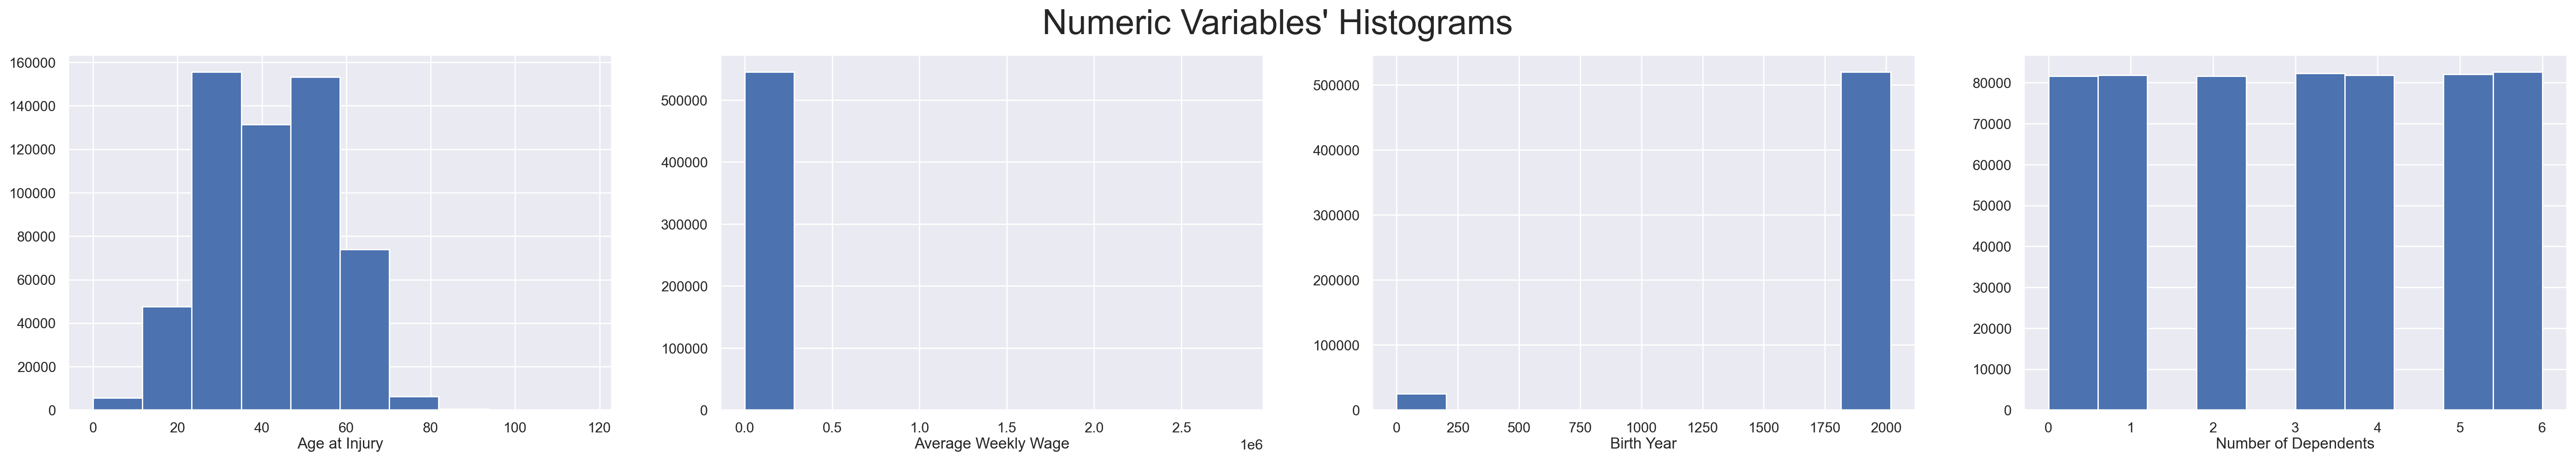

In [26]:
sp_rows = 1
sp_cols = 4

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(35, 5)) 

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): 
    # Notice the zip() function and flatten() method
    ax.hist(df[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title, fontsize = 27)

if not os.path.exists(os.path.join('..', 'figures', 'eda')):
    # If the exp_analysis directory is not present then create it first
    os.makedirs(os.path.join('..', 'figures', 'eda'))
    
plt.savefig(os.path.join('..', 'figures', 'eda', 'numeric_variables_histograms.png'), dpi=200)

plt.show()

## 3.1.2. Box plots
### Remarks
- *Age at injury*: The values between 0 and 16 should be ignored. We should also establish a superior frontier to remove the numerous outliers present.
- *Average weekly wage*: As concluded previously, this feature has a large amount of outliers, that is twisting largely the visualization of the main data.
- *Birth year*: On a similar note as the feature *Average weekly wage*, there are some values that should be ignored in order to see the distribution of the data, namingly the zero values; these should not be taken as outliers, but as wrong values, given the context of the feature itself (it is impossible someone was born on year 0).
- *Number of Dependents*: It seems like fairly distributed, sustaining the conclusions taken with the analysis of the histograms.


**Attention:**
- The outliers are really visible. It is very useful to define a treshold to perhaps remove them.
- People with a 0 weekly wage do not necessarily need to be removed. They can be simply unemployed.

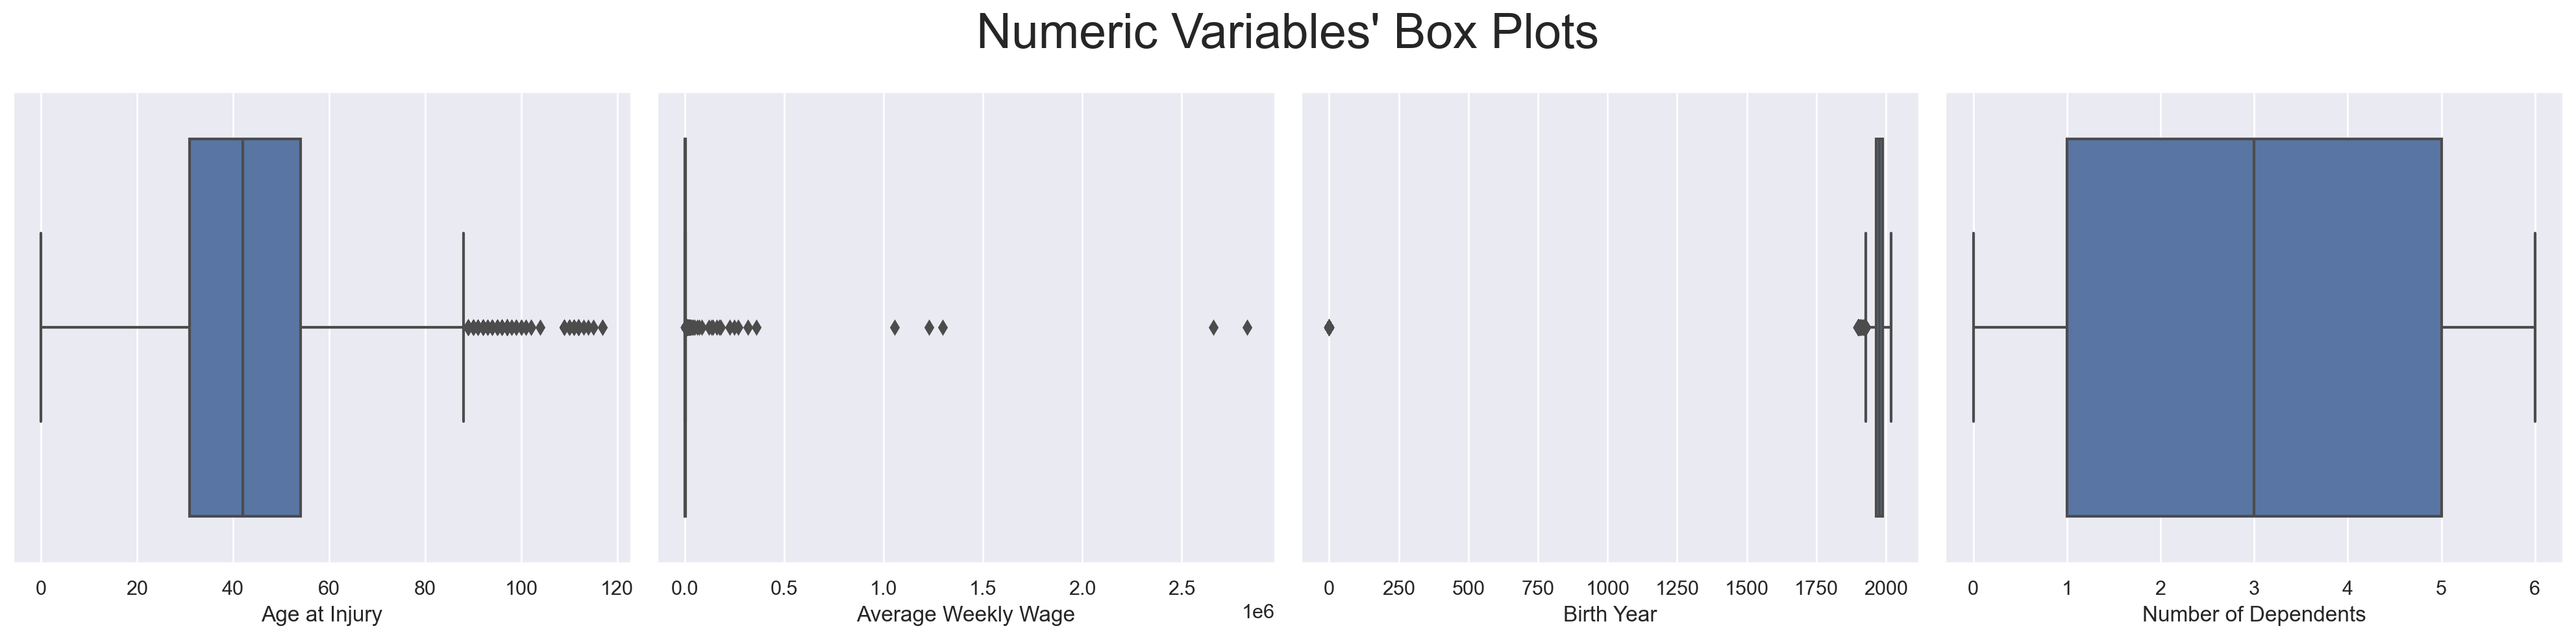

In [27]:
sp_rows = 1
sp_cols = 4

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, 
                         sp_cols, 
                         figsize=(20, 5),
                         tight_layout=True
                        )

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): 
    # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title, fontsize = 27)

if not os.path.exists(os.path.join('..', 'figures', 'eda')):
    # If the eda directory is not present then create it first
    os.makedirs(os.path.join('..', 'figures', 'eda'))


plt.savefig(os.path.join('..', 'figures', 'eda', 'numeric_variables_boxplots.png'), dpi=200)


plt.show()

## 3.1.3. Scatter plots
### Remarks
* There is **no evidence of correlation between the numeric variables**. The plots are quite vague.

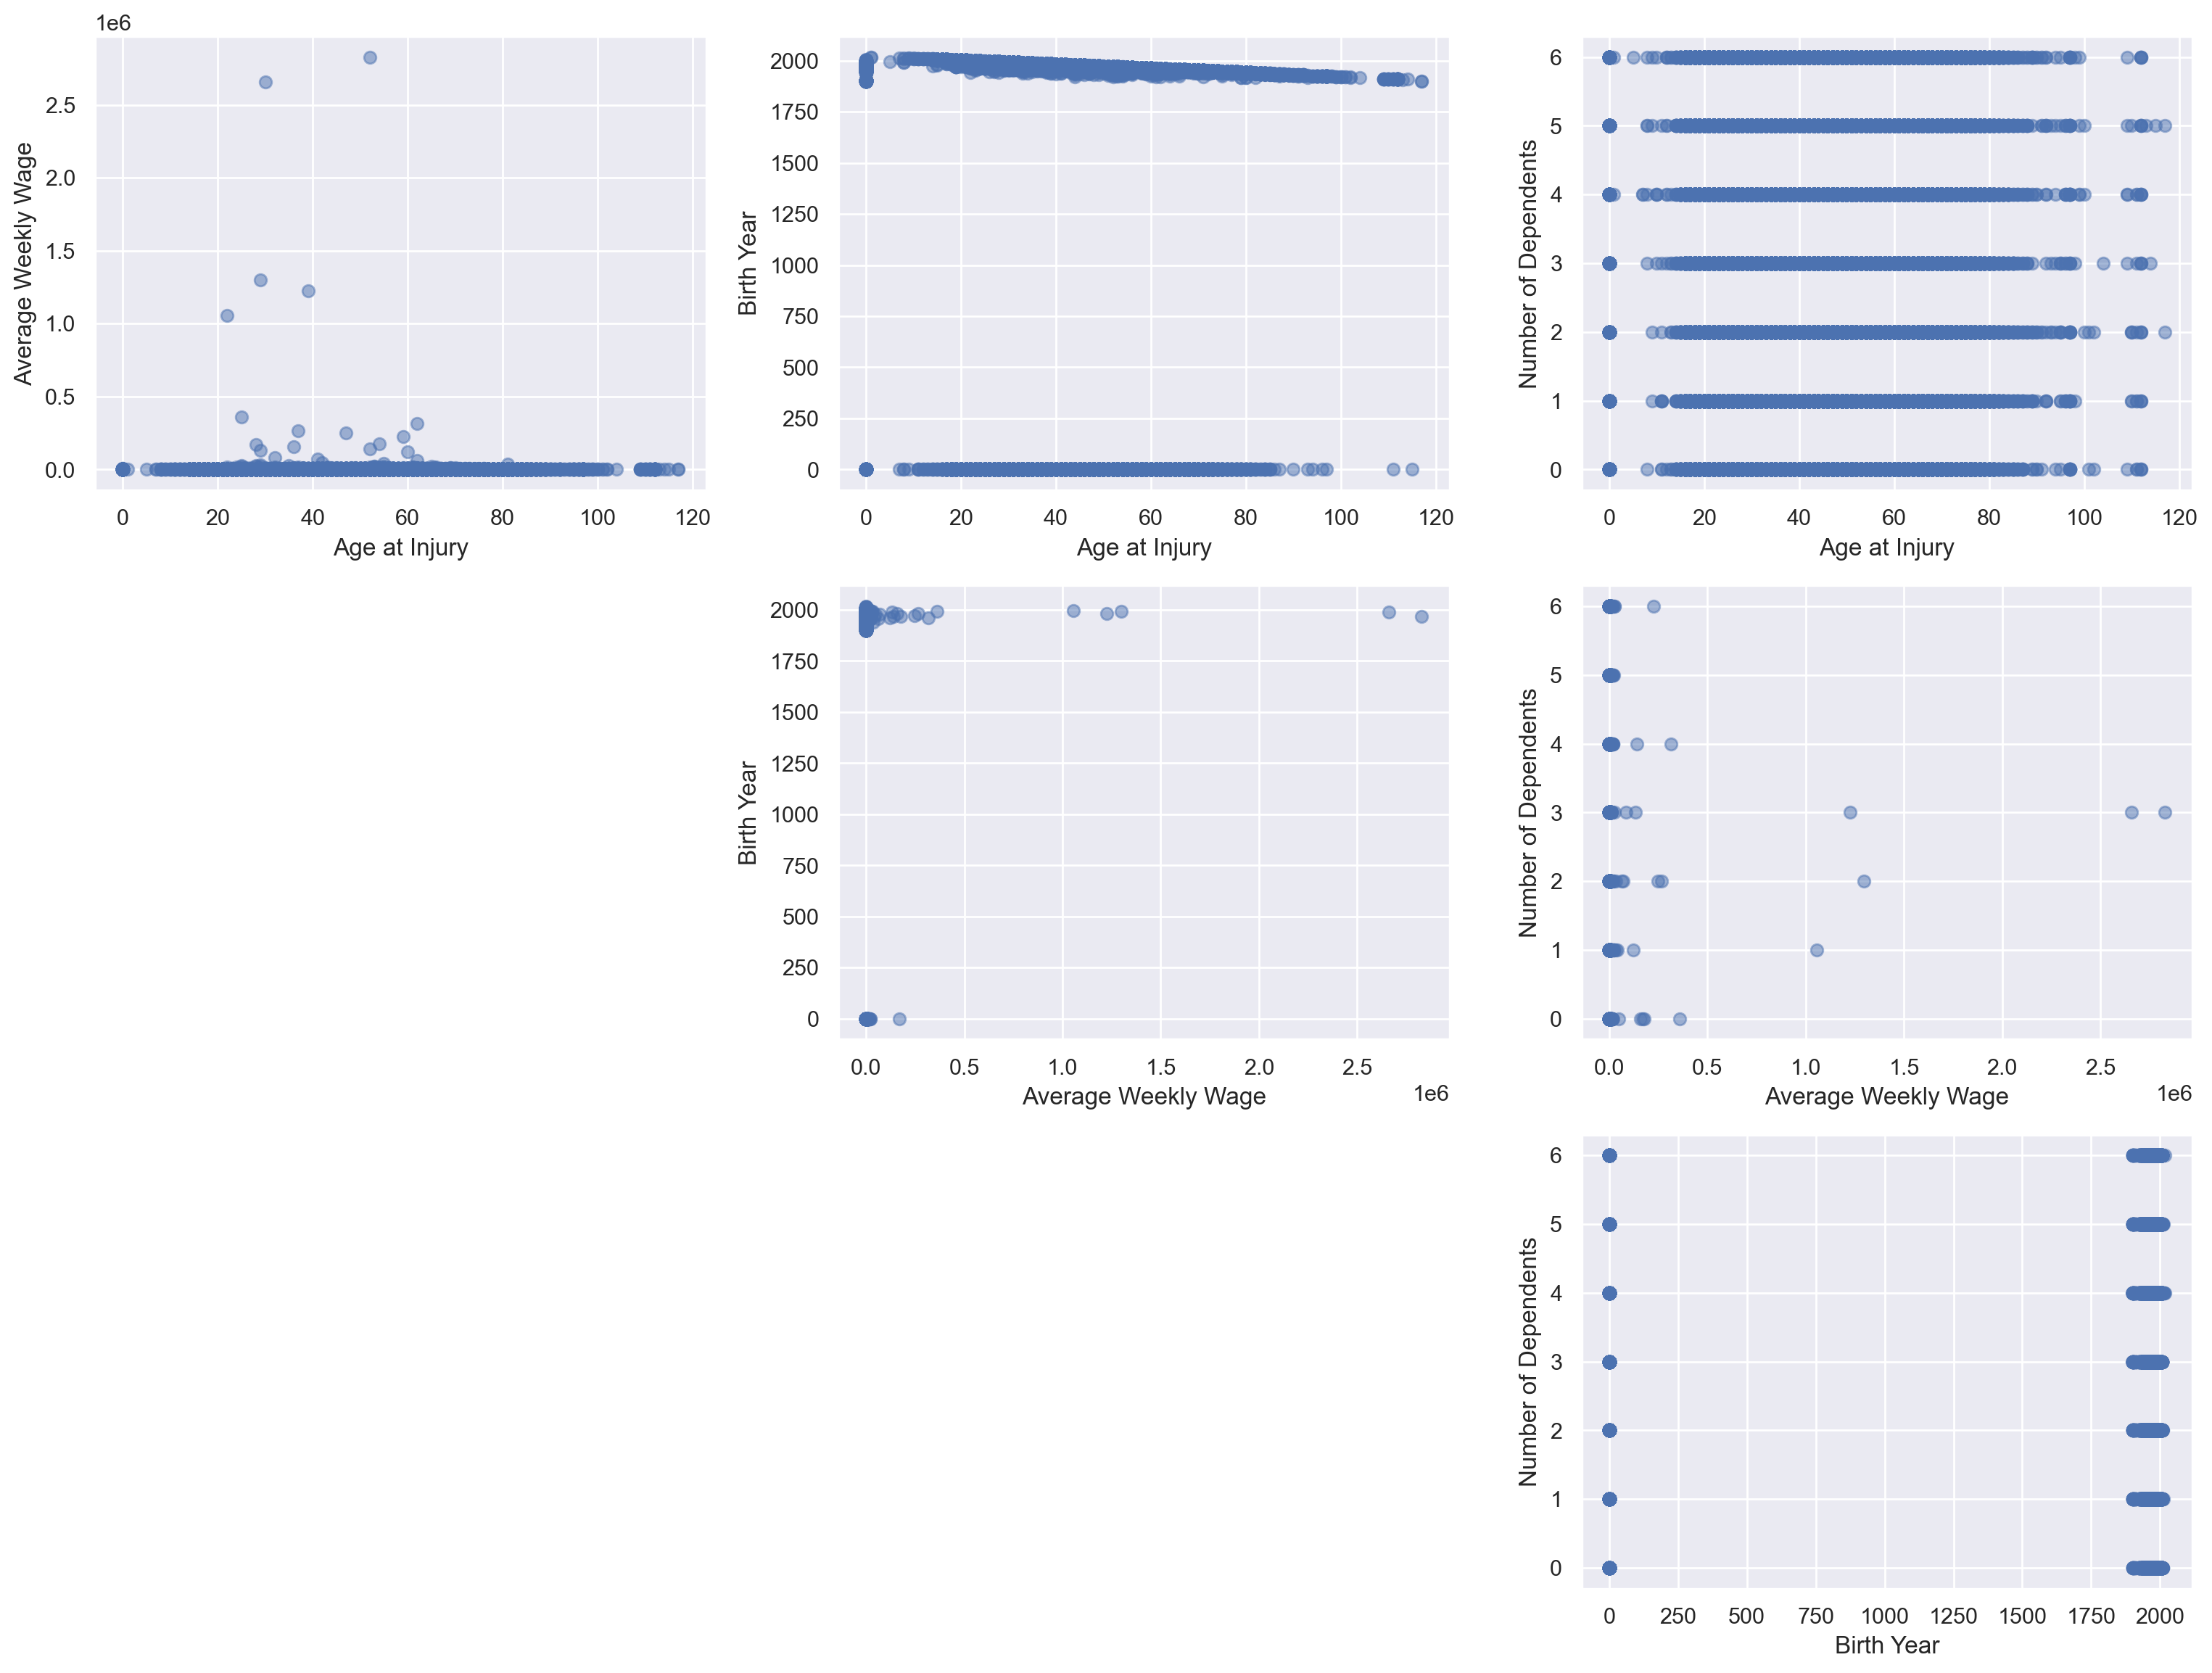

In [28]:
plt.figure(figsize=(20, 15))
n = len(metric_features)

for i in range(n):
    for j in range(i + 1, n):
        plt.subplot(n, n, i * n + j + 1)
        
        # Scatterplot
        plt.scatter(df[metric_features[i]], df[metric_features[j]], alpha=0.5)
        
        # Define lables
        plt.xlabel(metric_features[i]) 
        plt.ylabel(metric_features[j]) 
        
plt.tight_layout()
plt.show()

We are not able to take any relevant conclusions from the scatter plots, leading to the suspition that the features are not correlated.

## 3.1.4. Heatmap
### Remarks
* The correlation matrix sustains all previous conclusions taken with the scatterplot's analysis.

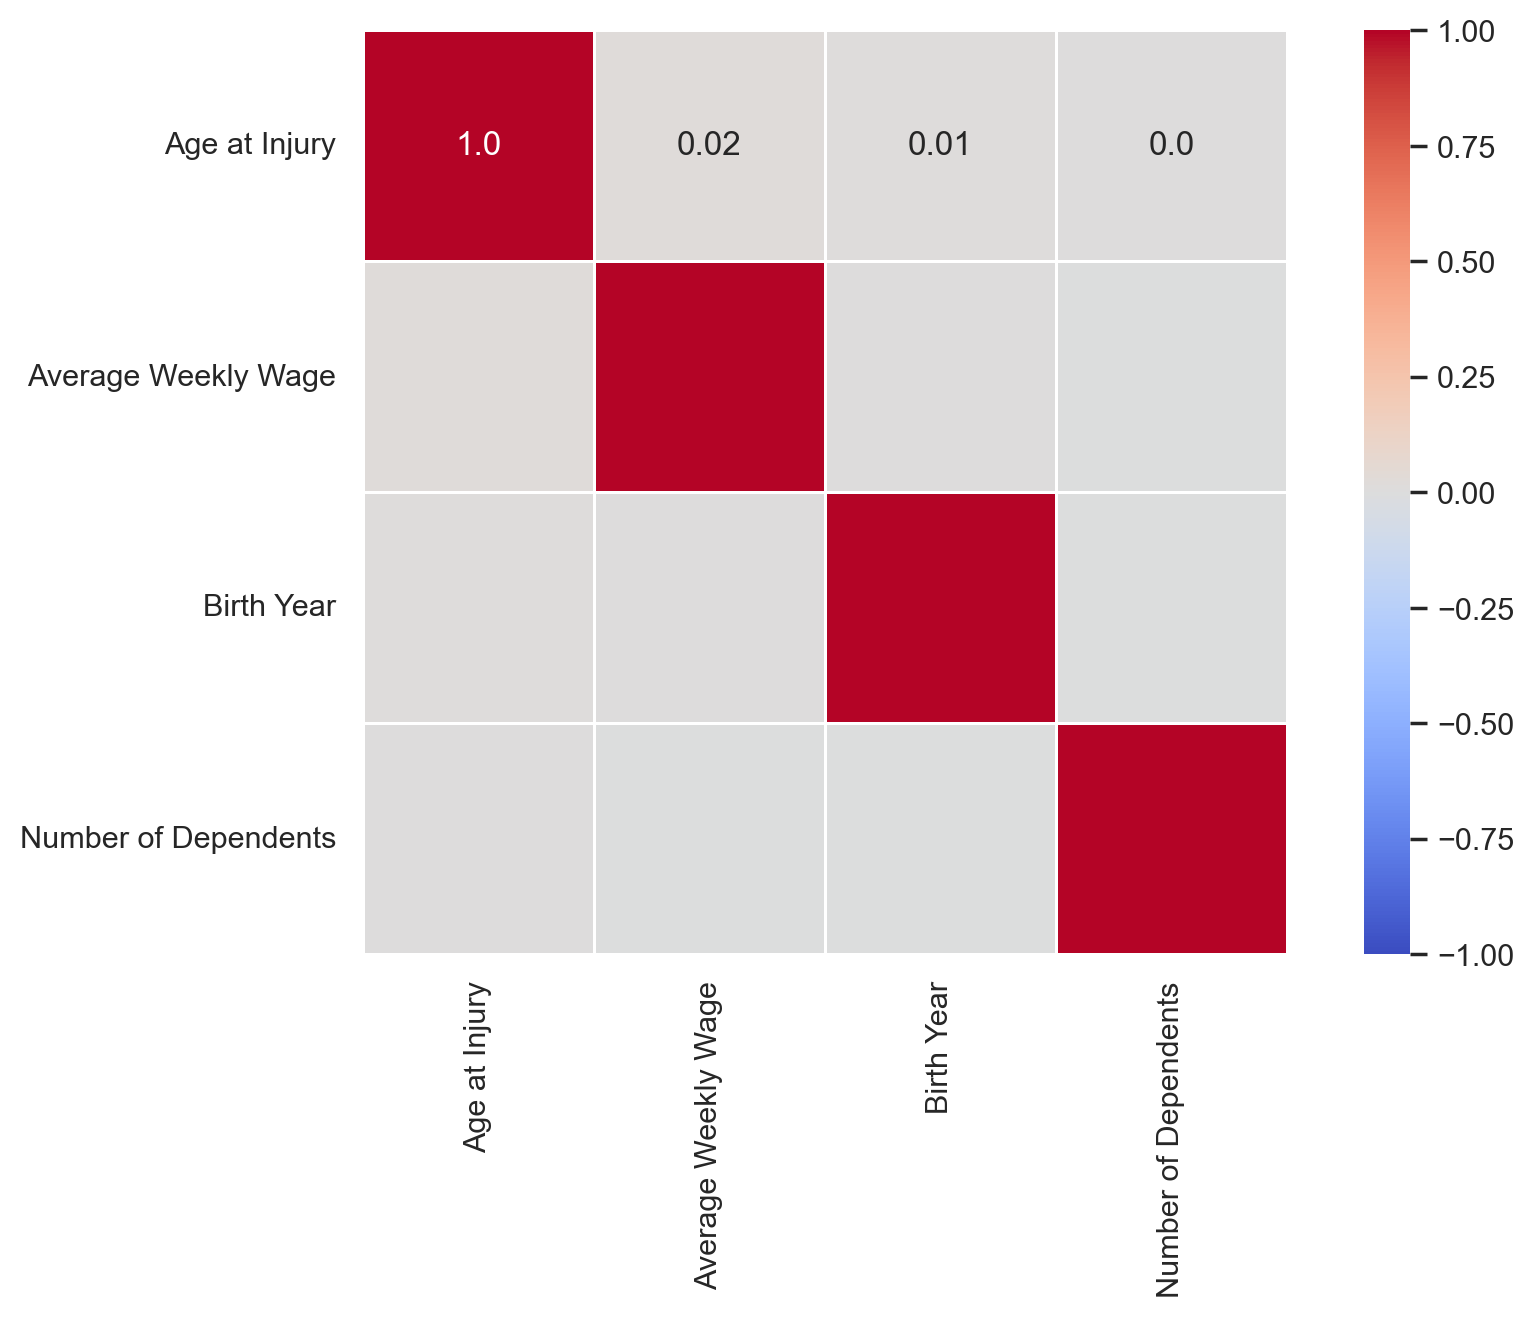

In [29]:
# Filter DataFrame to include only the metric features
df_filtered = df[metric_features]

# Calculate the correlation matrix
corr = df_filtered.corr()

# Annotations for the heatmap (optional)
# Convert the correlation matrix values to strings for annotation
annot = corr.round(2).astype(str)  

# Prepare figure
fig = plt.figure(figsize=(10, 6))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, 
            annot=annot,  # Use custom annotations (from the 'annot' matrix)
            fmt='s',  # Specify format as string, since the annotation matrix has string values
            vmin=-1, vmax=1, center=0,  # Set color scale limits for a balanced heatmap
            square=True, linewidths=.5,  # Add borders to each cell
            cmap='coolwarm'  # Improved colormap to highlight correlations
           )

# Save the figure as an image
plt.savefig(os.path.join('..', 'figures', 'eda', 'correlation_matrix.png'), dpi=200)

# Display the figure
plt.show()

We are not able to take any relevant conclusions from the heatmap as well, leading to the suspition that the features are not correlated.

## 3.2. Categorical Features' Absolute Frequencies
**NOTE**: For now, we are not using the features related to time (*Accident Date*, *Assembly Date*, and *C-2 Date*), that are going to be grouped by quarters later on this report (see Section 7). <br><br>
**Also:**
- We did not include *Carrier Name* and *Zip Code*, since they are just the name and zip code of the injured. It makes no sense to visualize it for there's no relevant conclusions we could take, especially taking into account that we already include "Carrier Type" and "County of Injury" in our analysis. We will focus more specifically on the importance of these two features later on this report.
- Also, we divided the non_metric_features, according to the number of categories in each feature. Then, the visualization would be the best possible for each one.

In [30]:
count_plots1 = ["County of Injury",'Industry Code', "Industry Code Description", "WCIO Cause of Injury Code", "WCIO Cause of Injury Description", "WCIO Nature of Injury Code", "WCIO Nature of Injury Description", "WCIO Part Of Body Code", "WCIO Part Of Body Description"]
count_plots2 = ["Attorney/Representative", "Claim Injury Type", "Carrier Type", "District Name", "Gender", "Medical Fee Region"]
pie_charts = ["Alternative Dispute Resolution", "COVID-19 Indicator"]

## 3.2.1. Bar charts

### Remarks for features with many categories
*Count of Injury*, *Industry Code*, *Industry Code Description*, *WCIO Cause of Injury Code*, *WCIO Cause of Injury Code Description*, *WCIO Nature Injury Code*, *WCIO Nature Injury Description*, *WCIO Part of Body Code*, and *WCIO Part of Body Description*

[Possible Outlier and Unknown Data Treatment]
- *Count of Injury*: From Rockland onwards, the values are residual, comparatively to the dominant categories.
- *Industry code*: From the code 81.0 onwards, codes are residual.
- *WCIO Cause of Injury Code*: From the code 79.0 onwards, codes are residual.
- *WCIO Nature Injury Code*: From the code 43.0 onwards, codes are residual.
- *WCIO Part of Body Code*: From the code 34.0 onwards, codes are residual.

[Quetions]
- Are *Industry Code* and *Industry Code Description* the same?
- Are *WCIO Cause of Injury Code* and *WCIO Cause of Injury Description* the same?
- Are *WCIO Nature Injury Code* and *WCIO Nature Injury Description* the same?
- Are *WCIO Part of Body Code* and *WCIO Part of Body Description* the same?

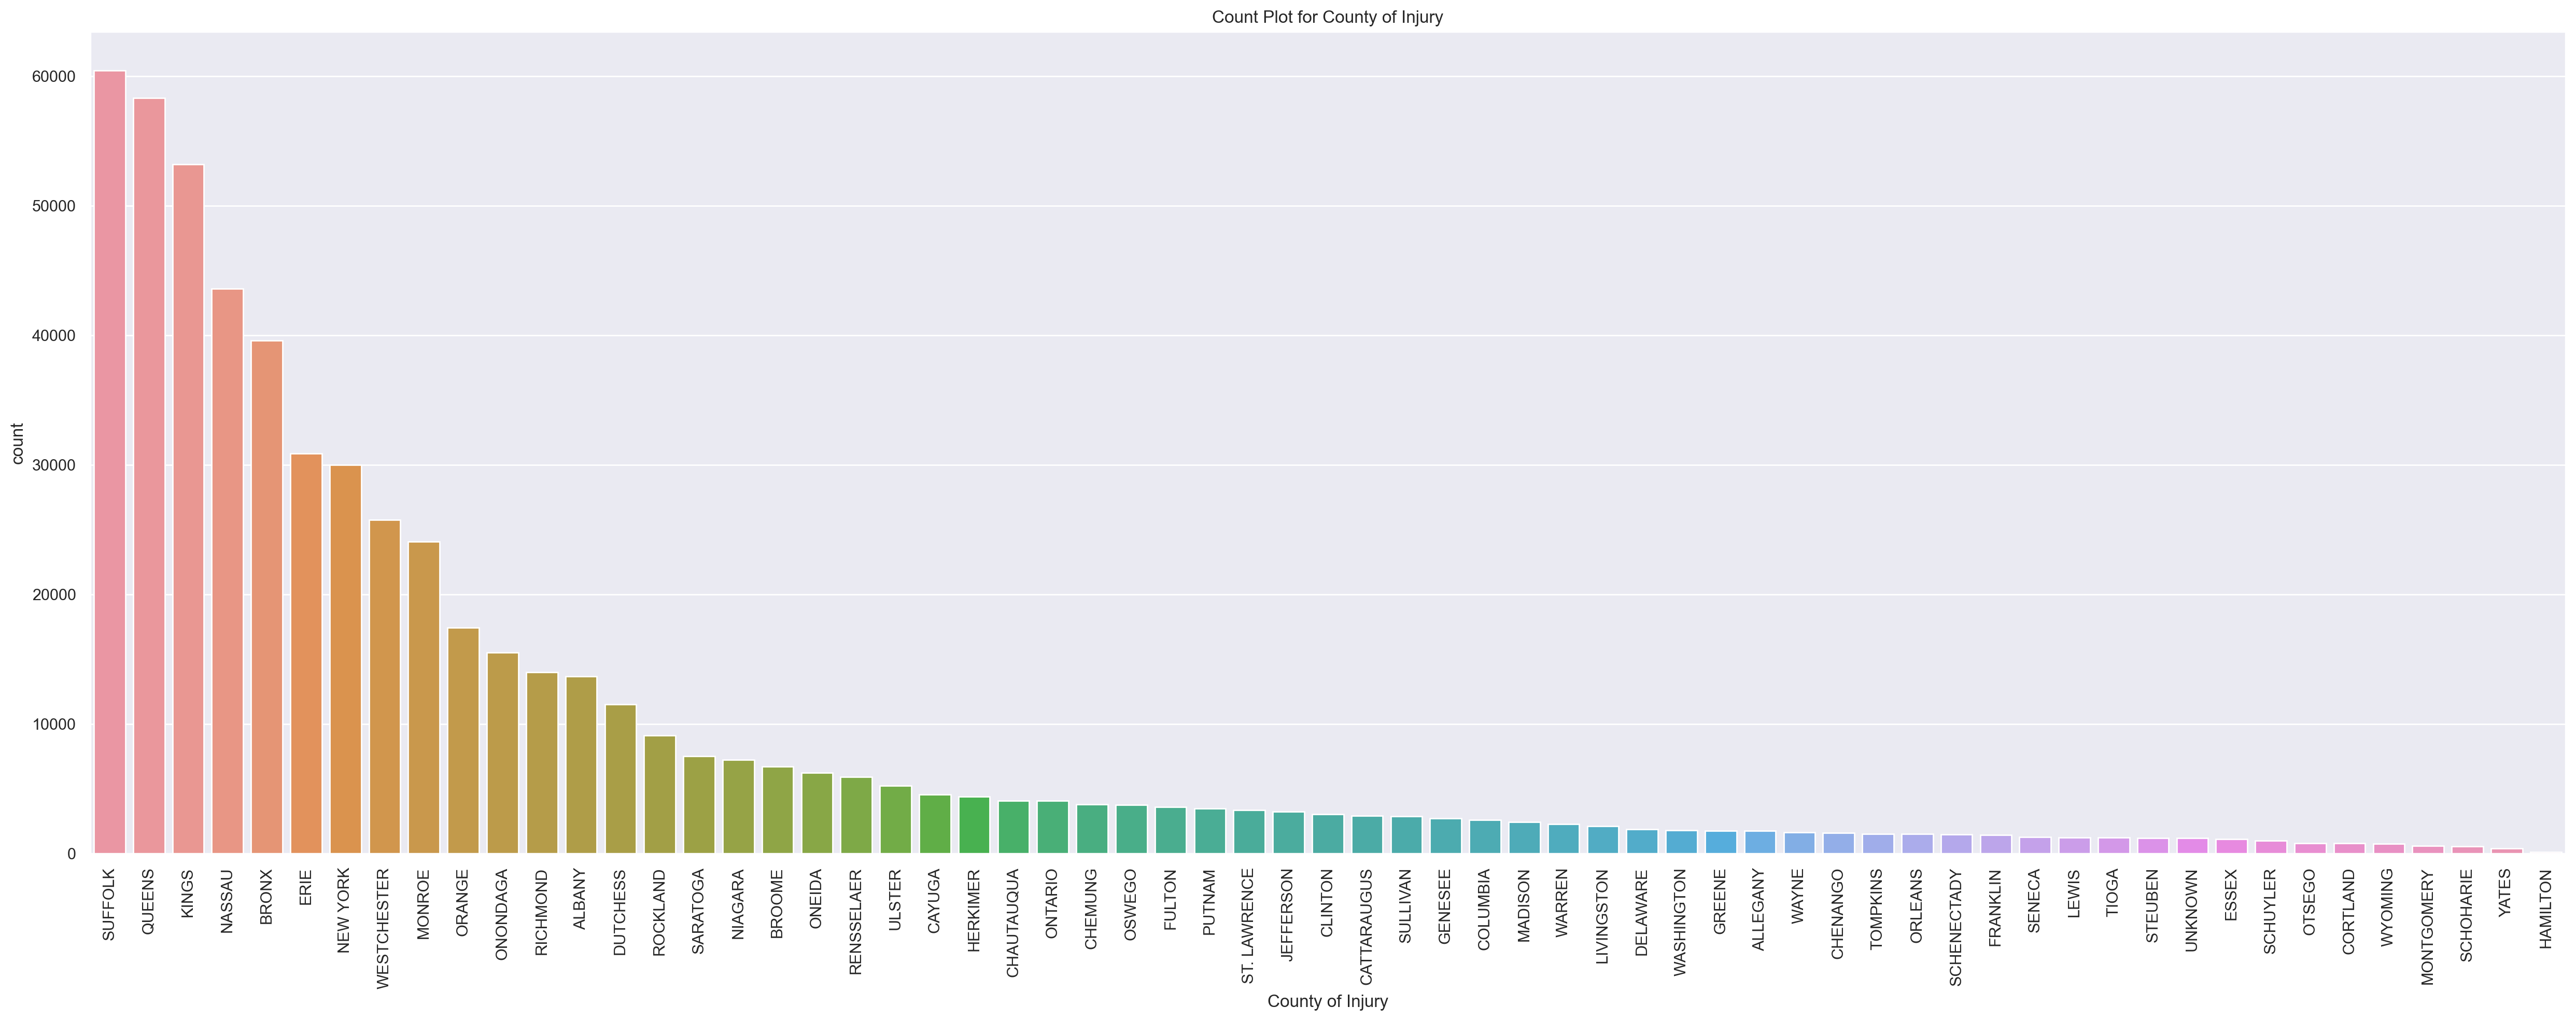

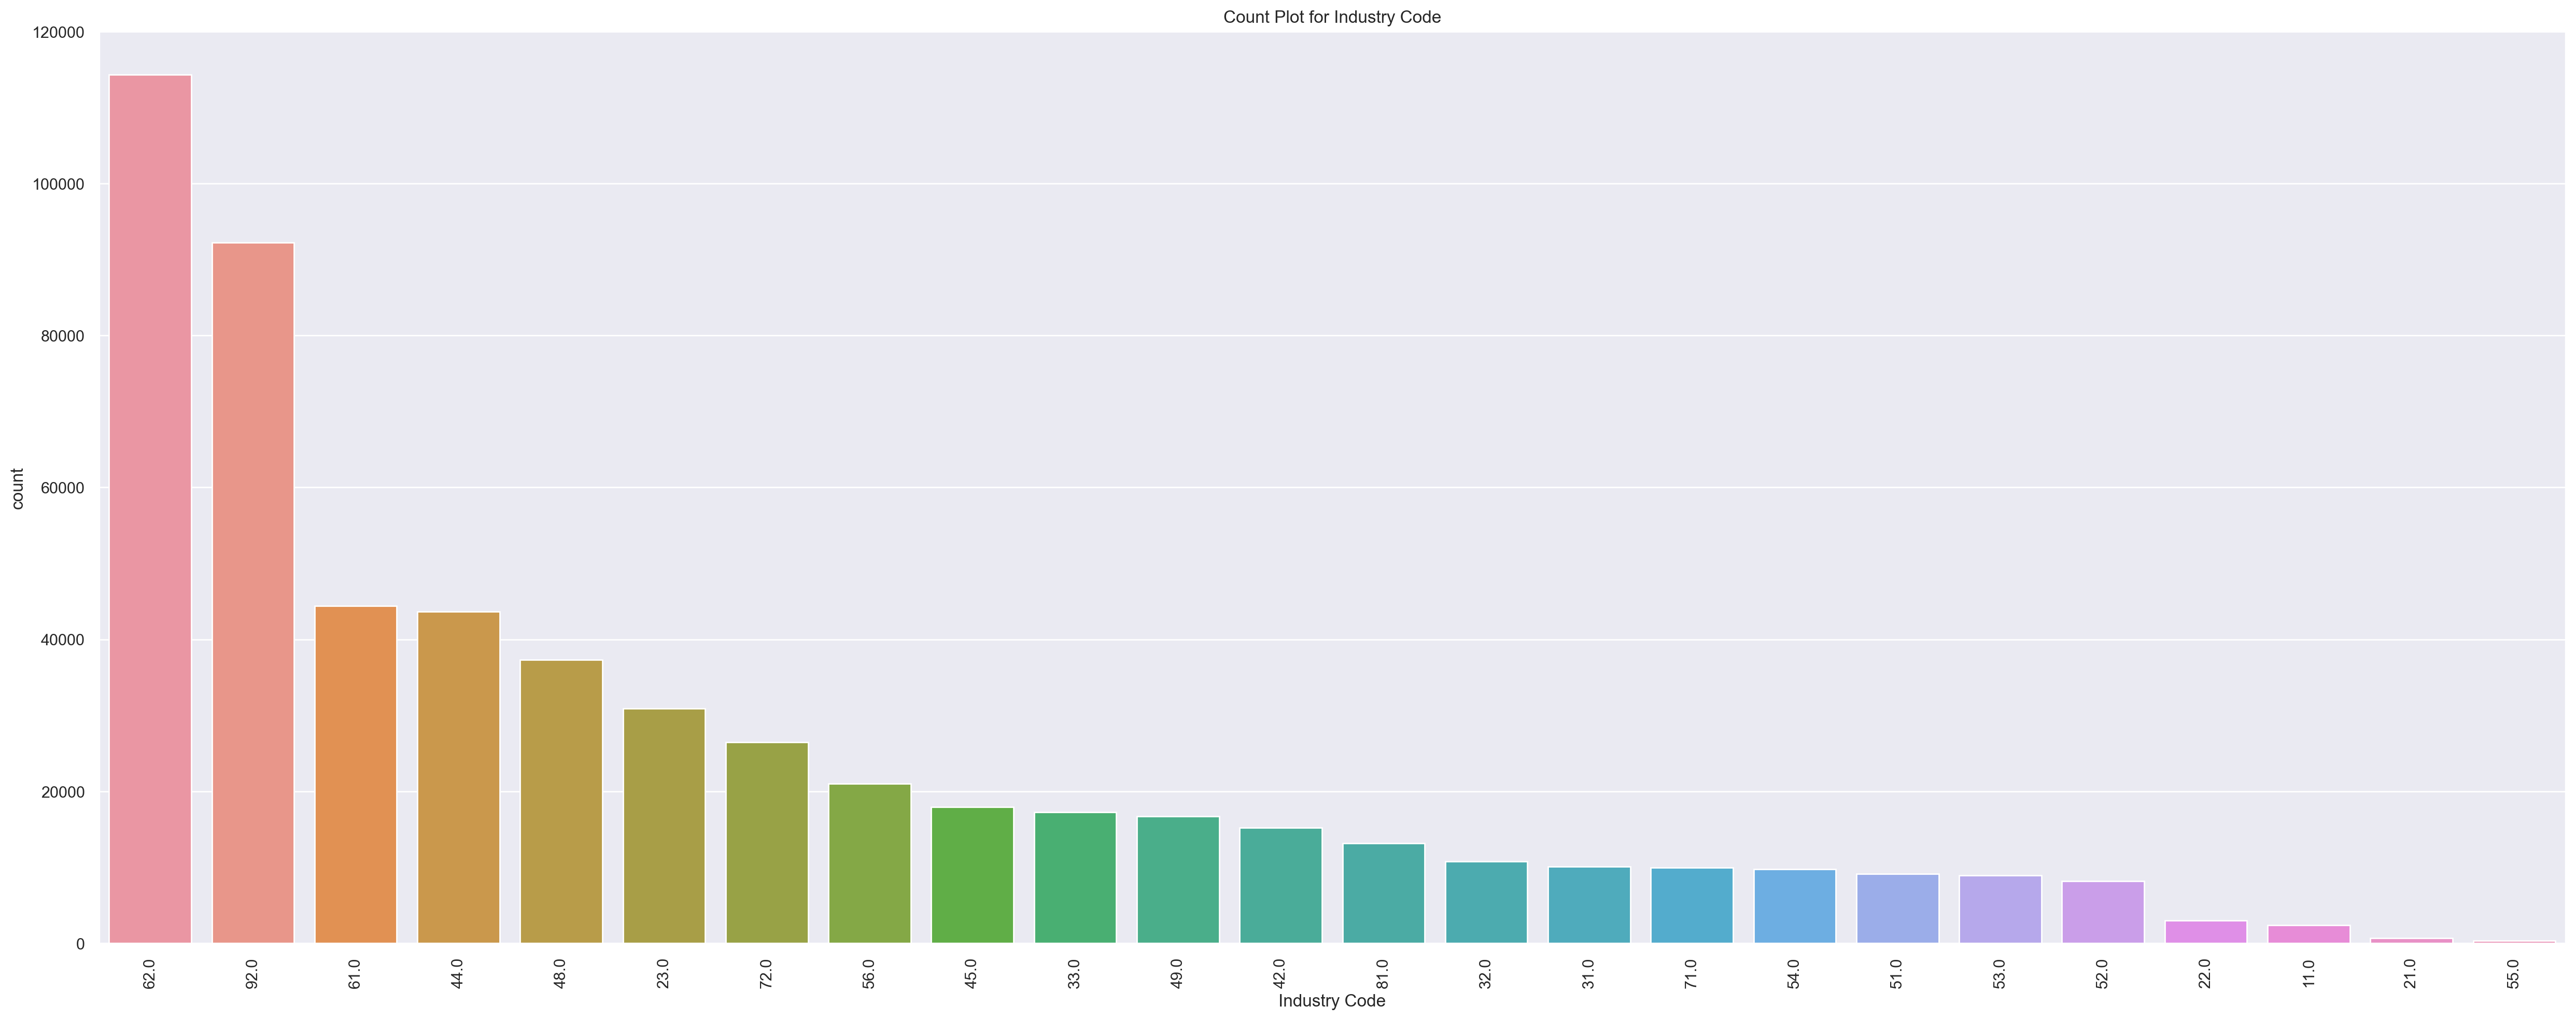

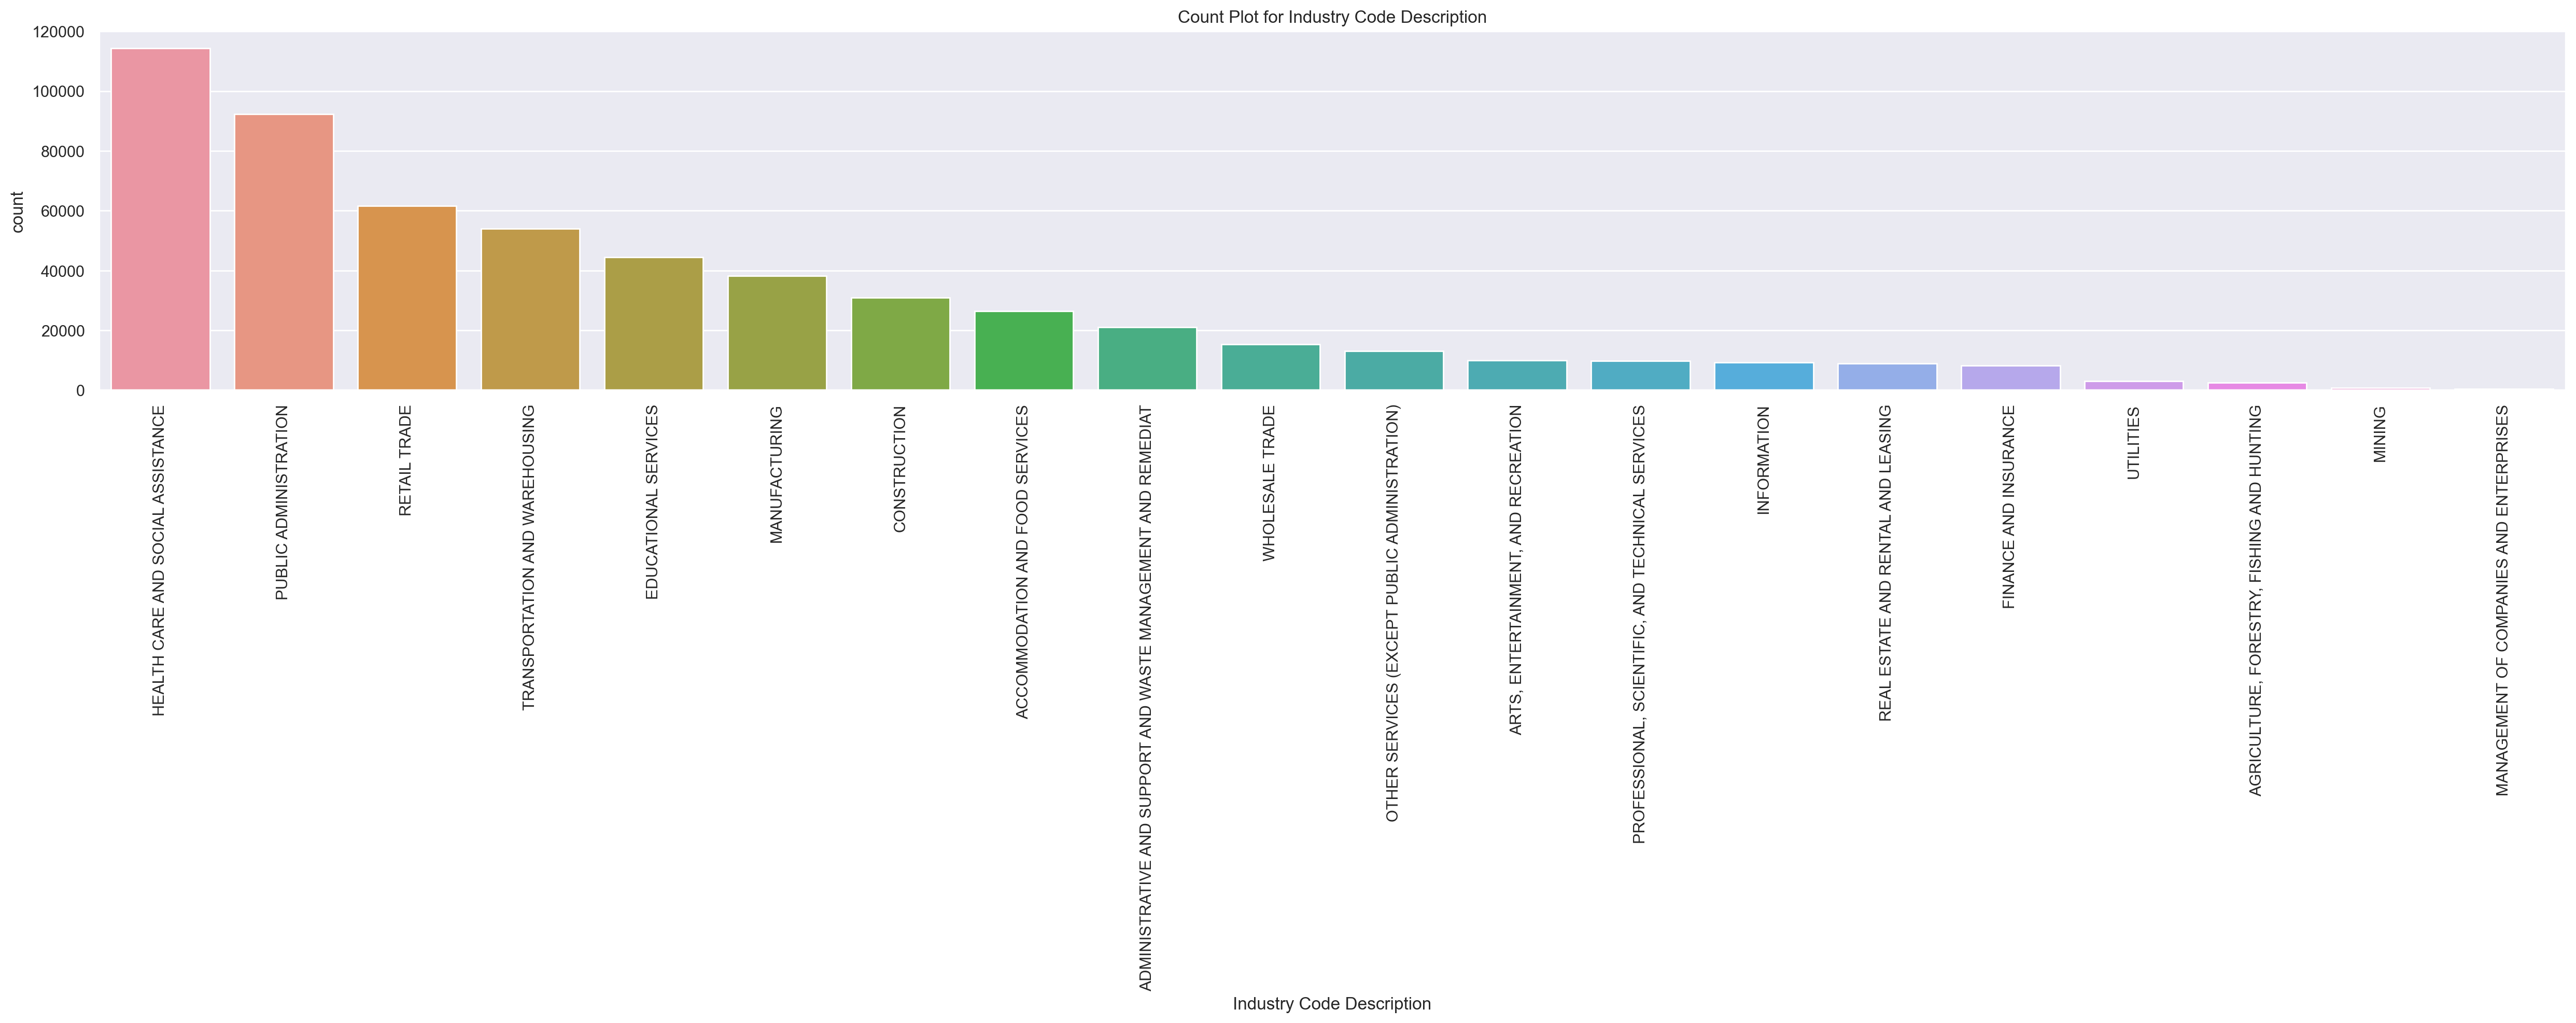

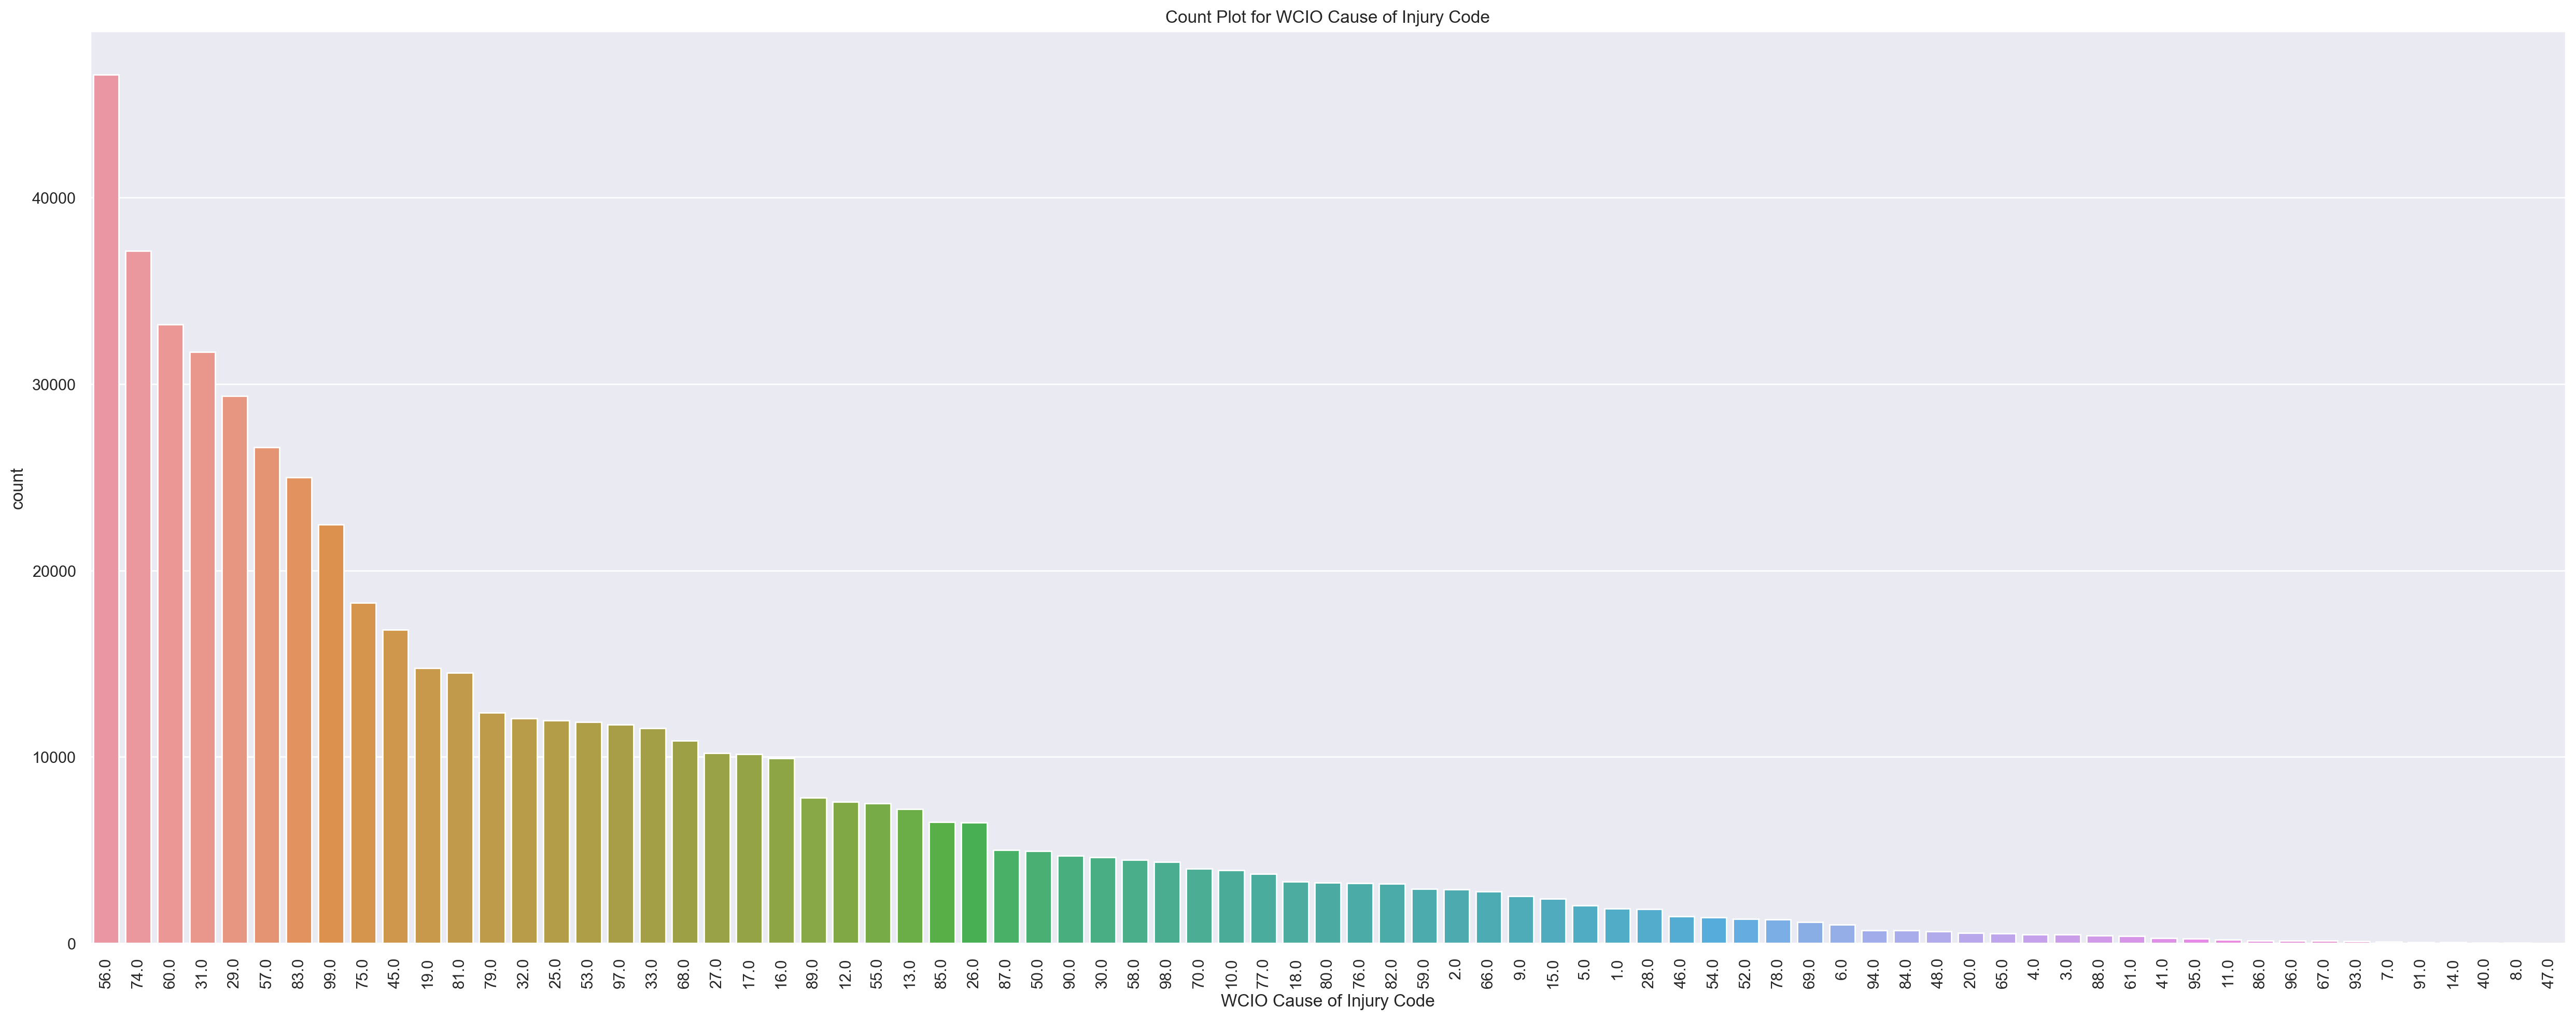

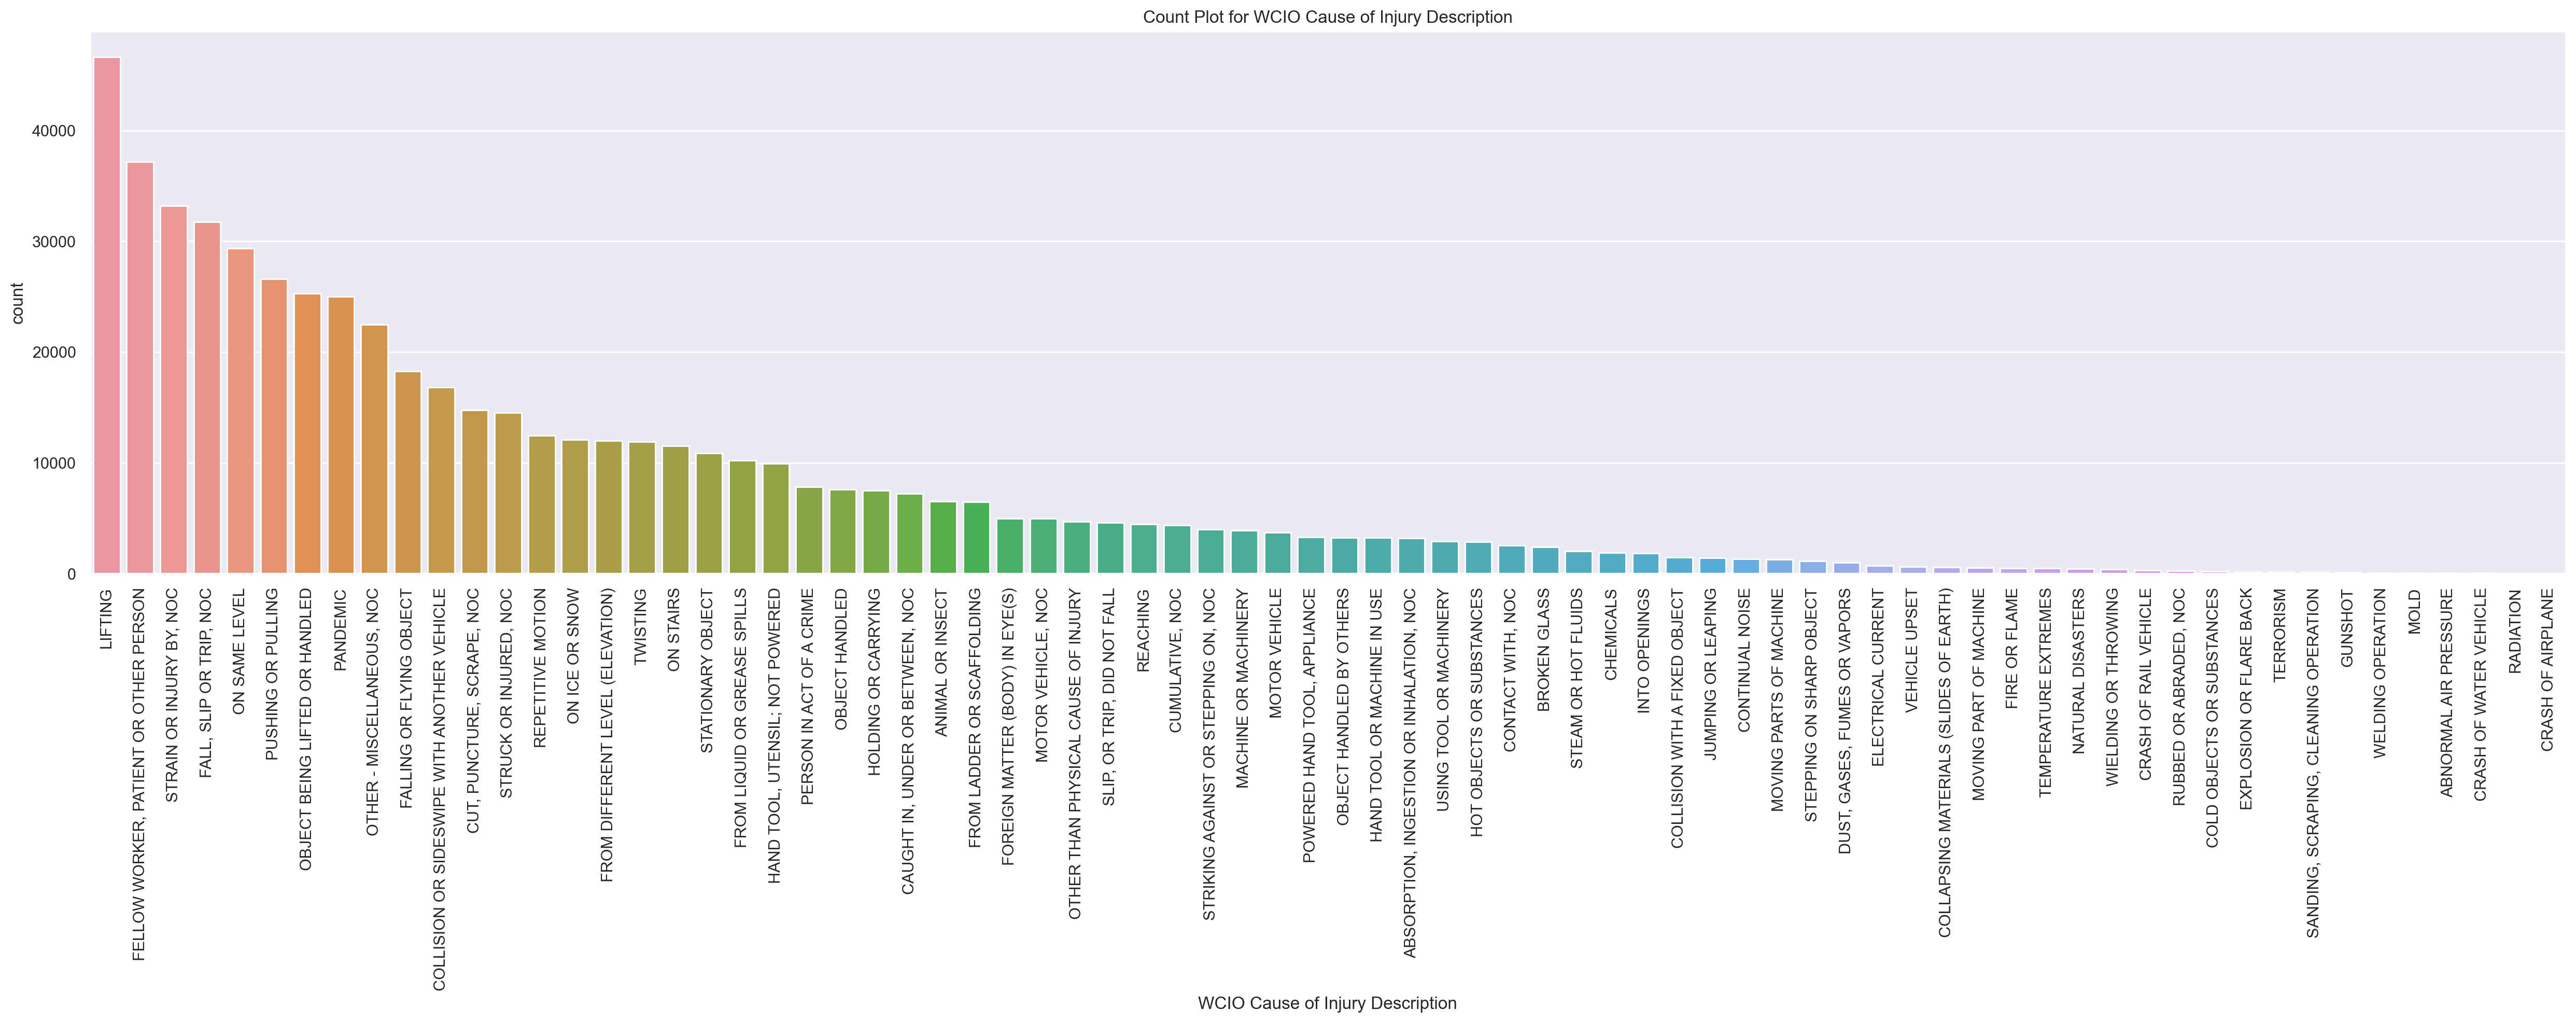

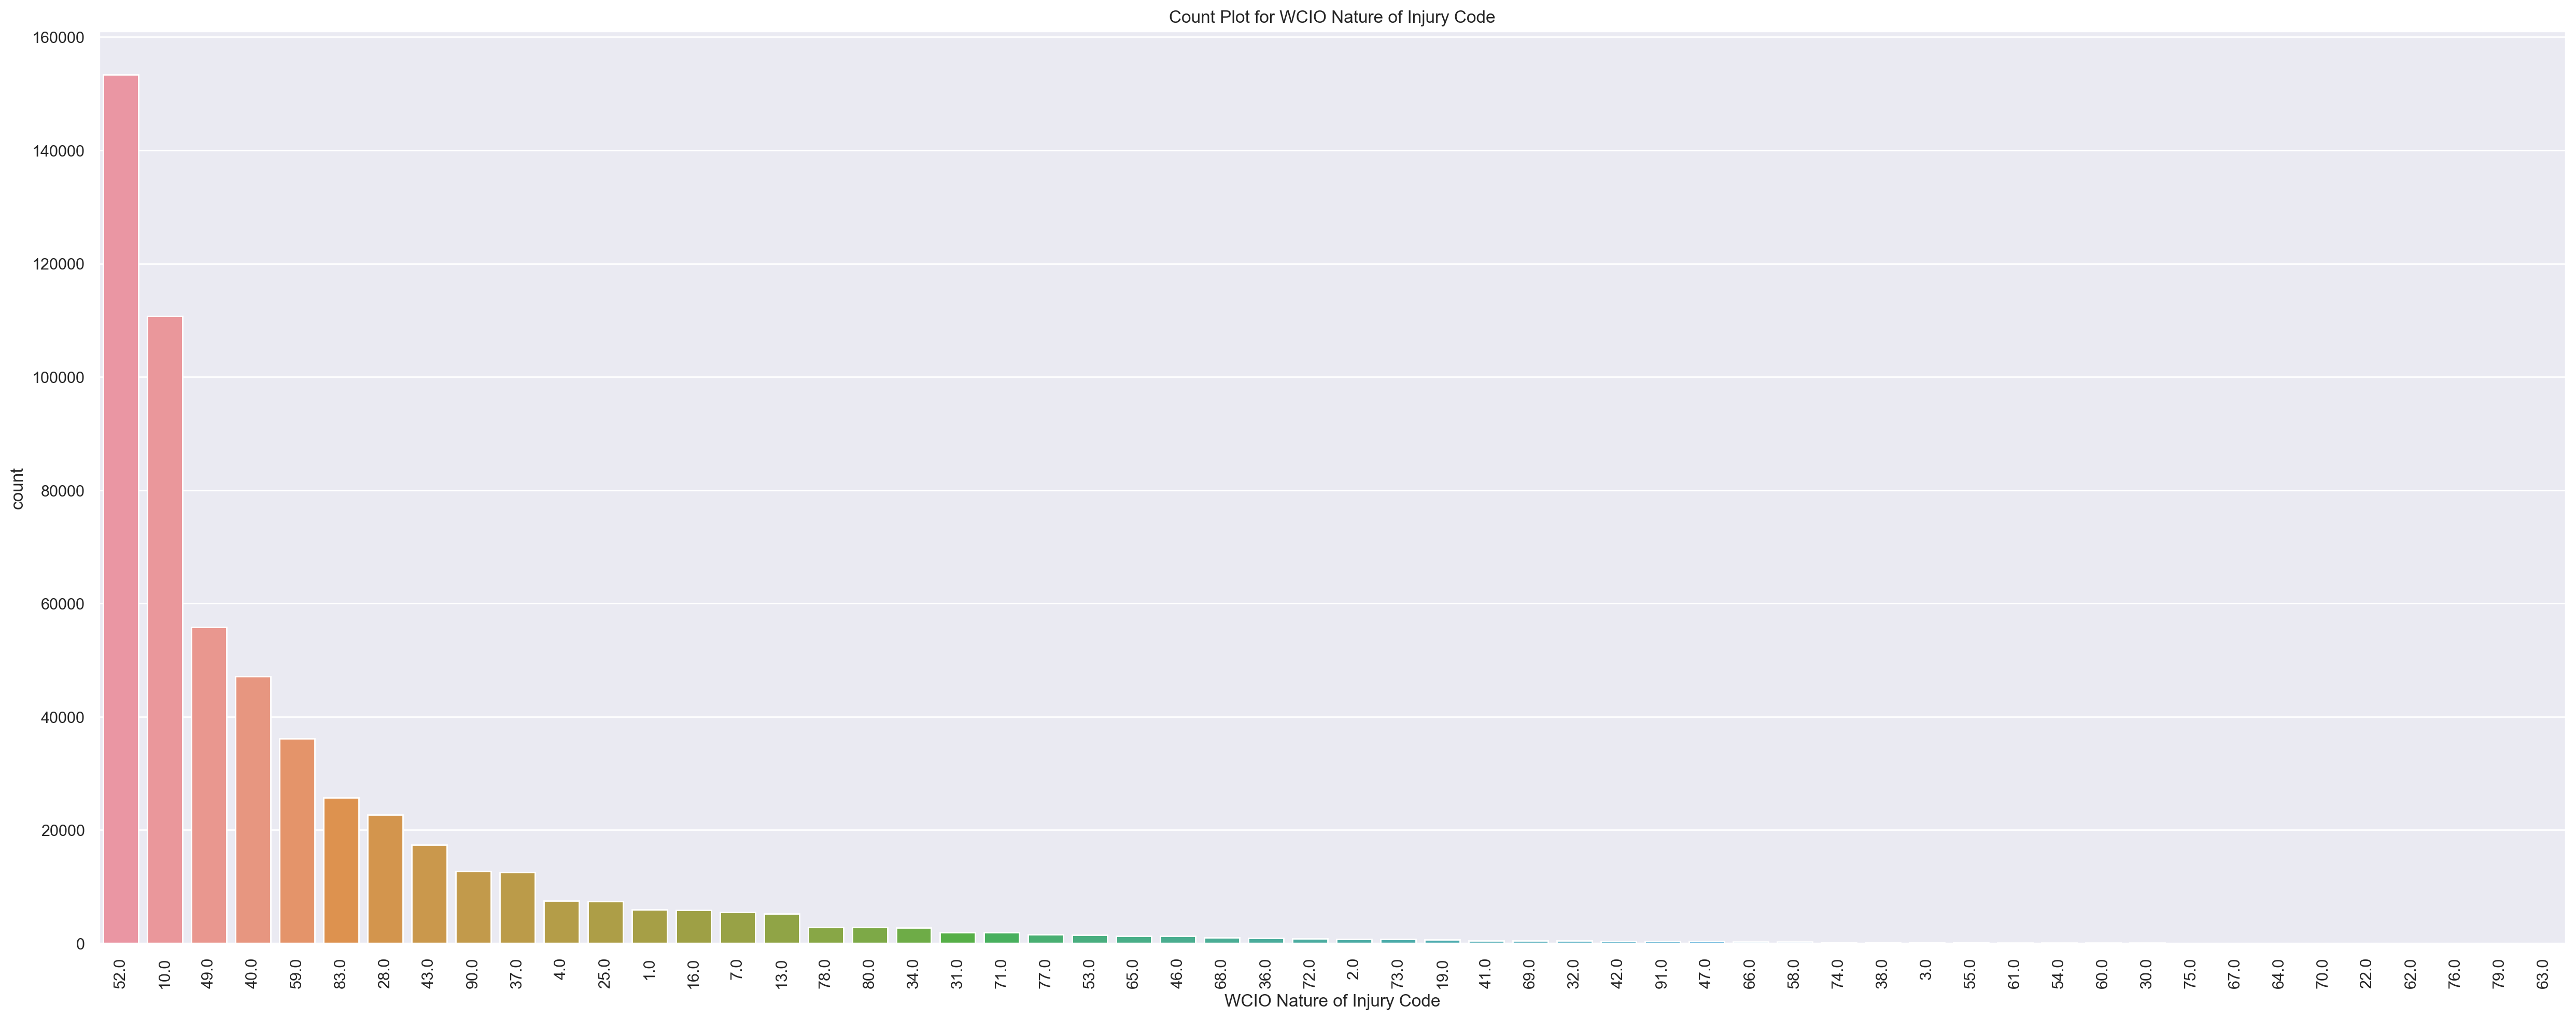

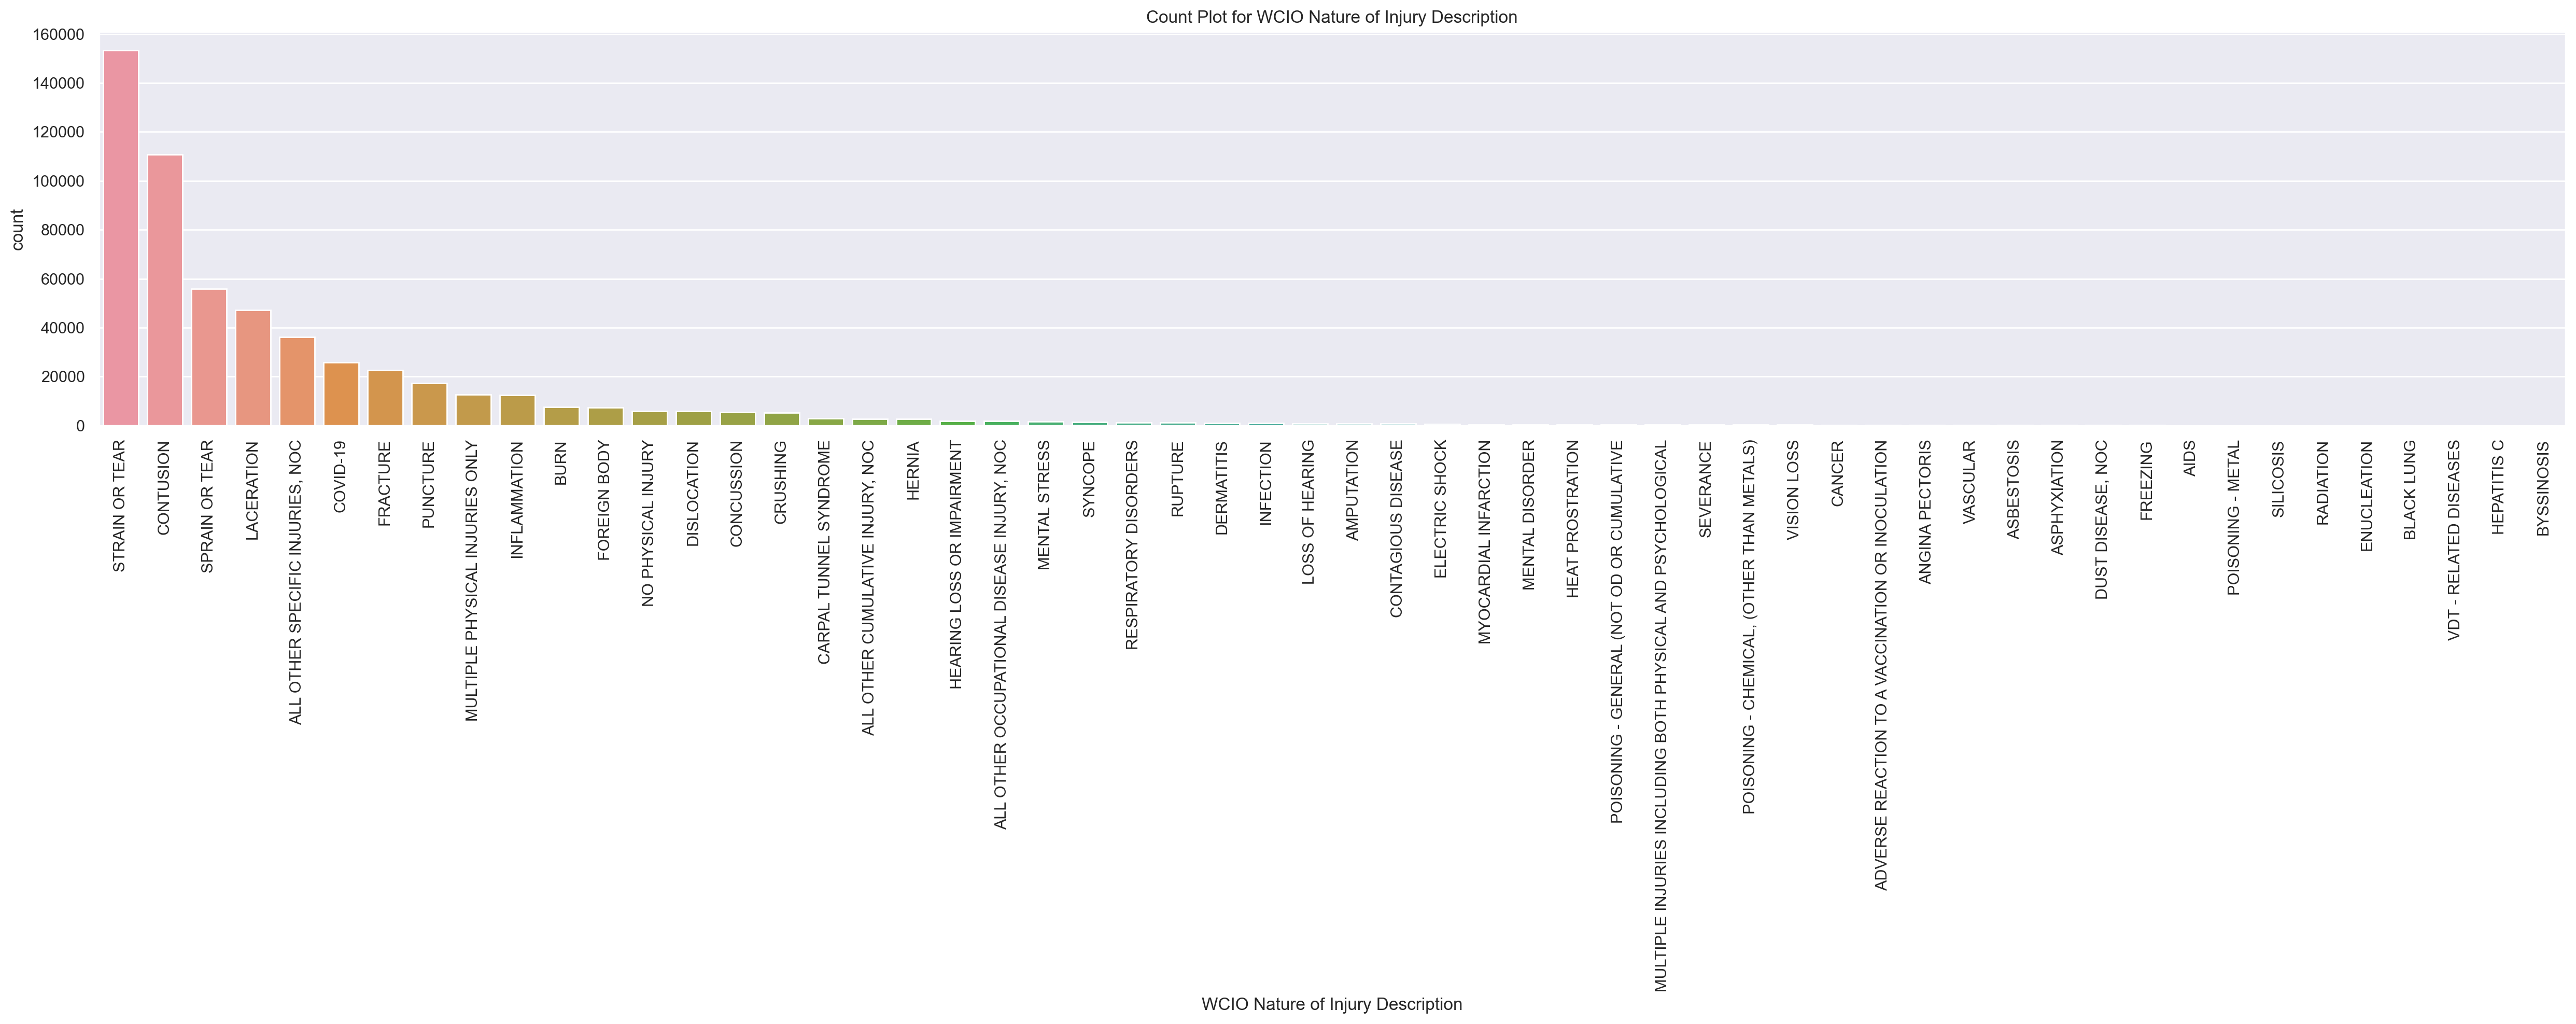

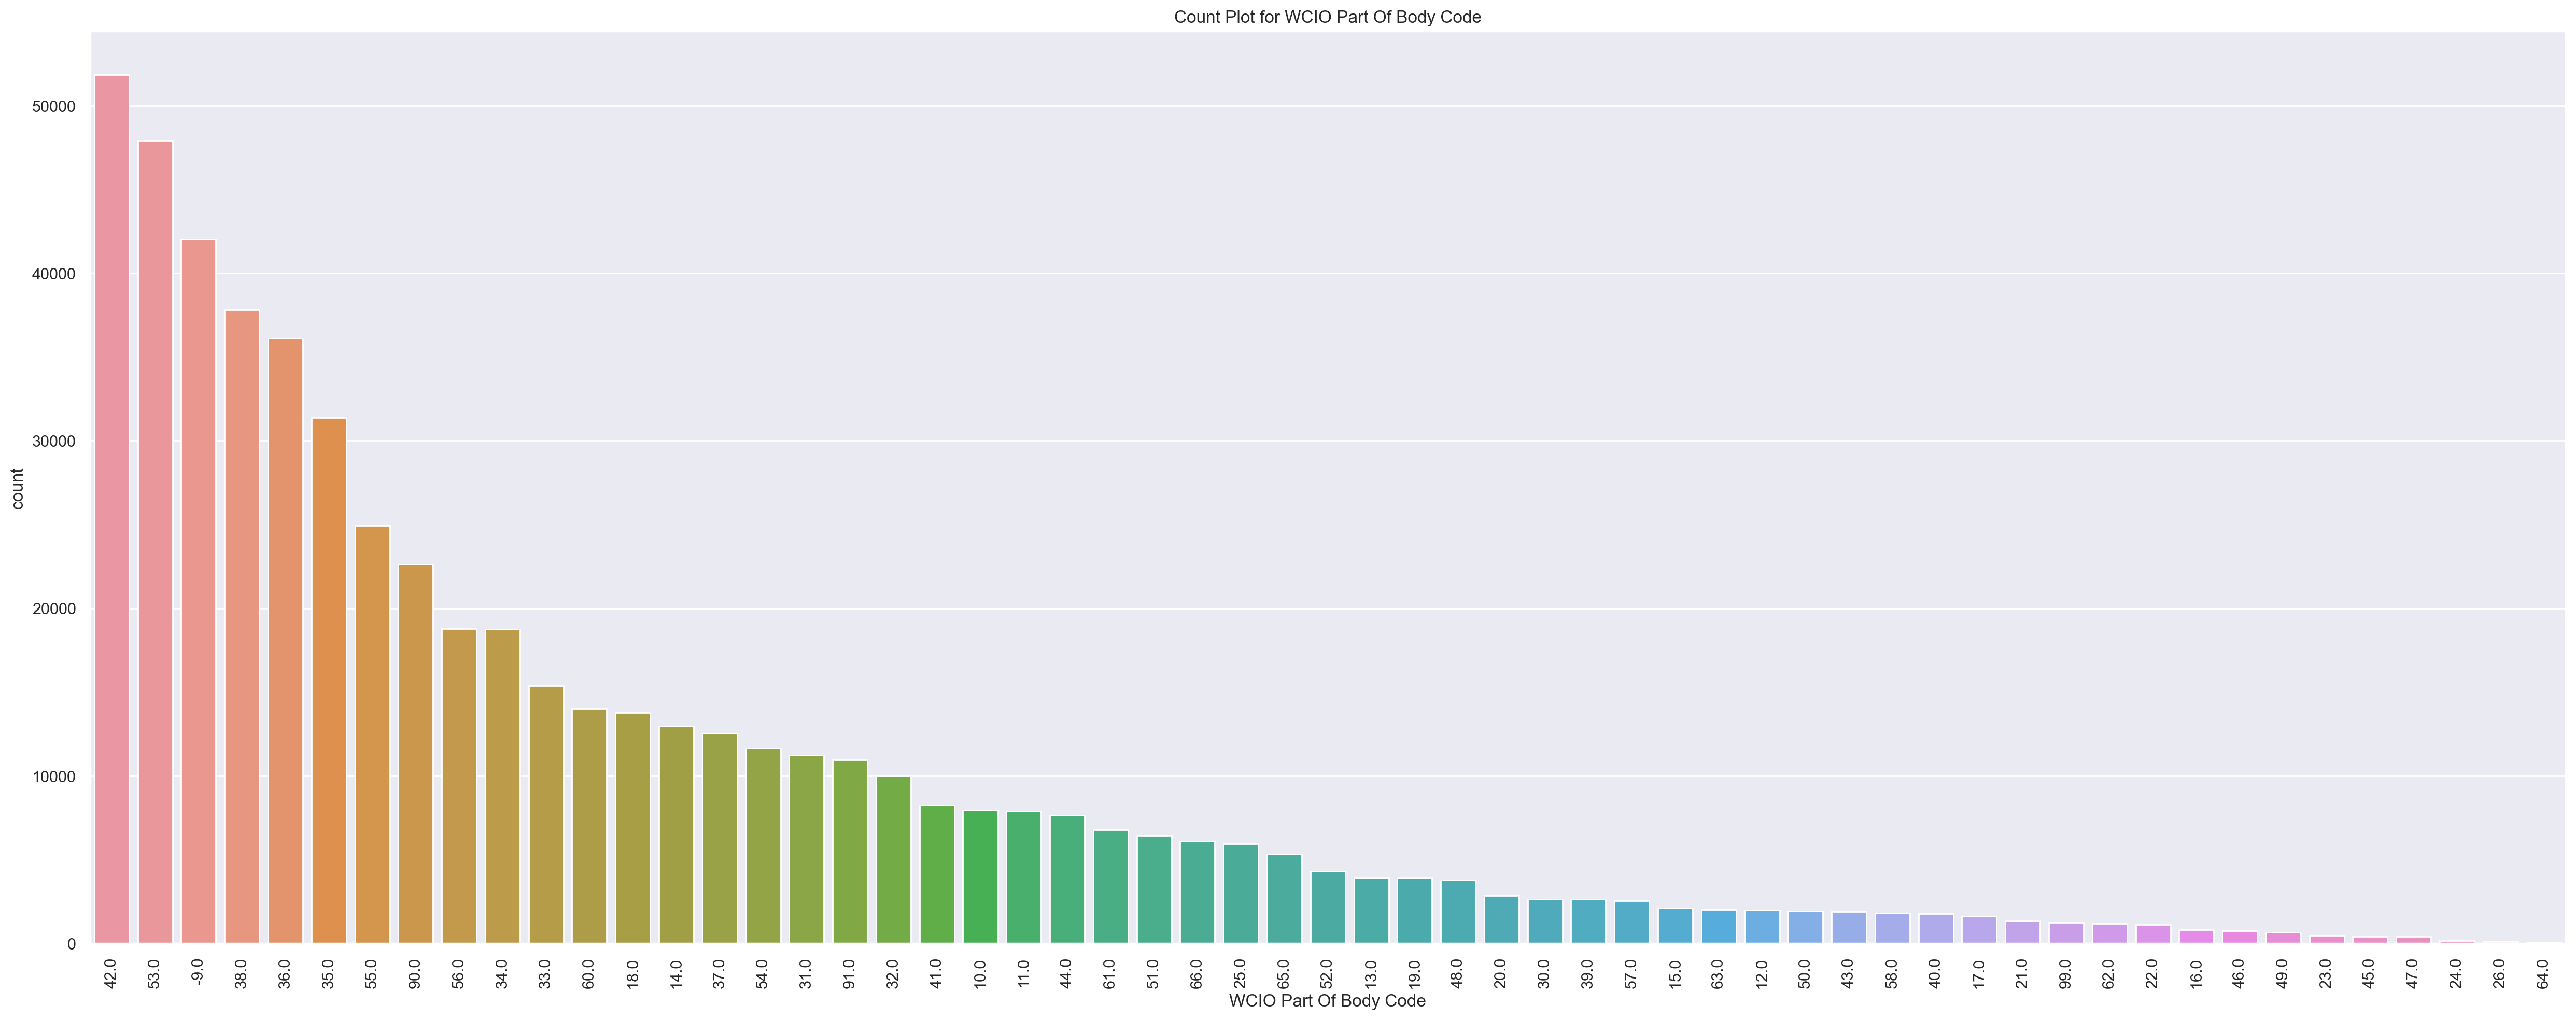

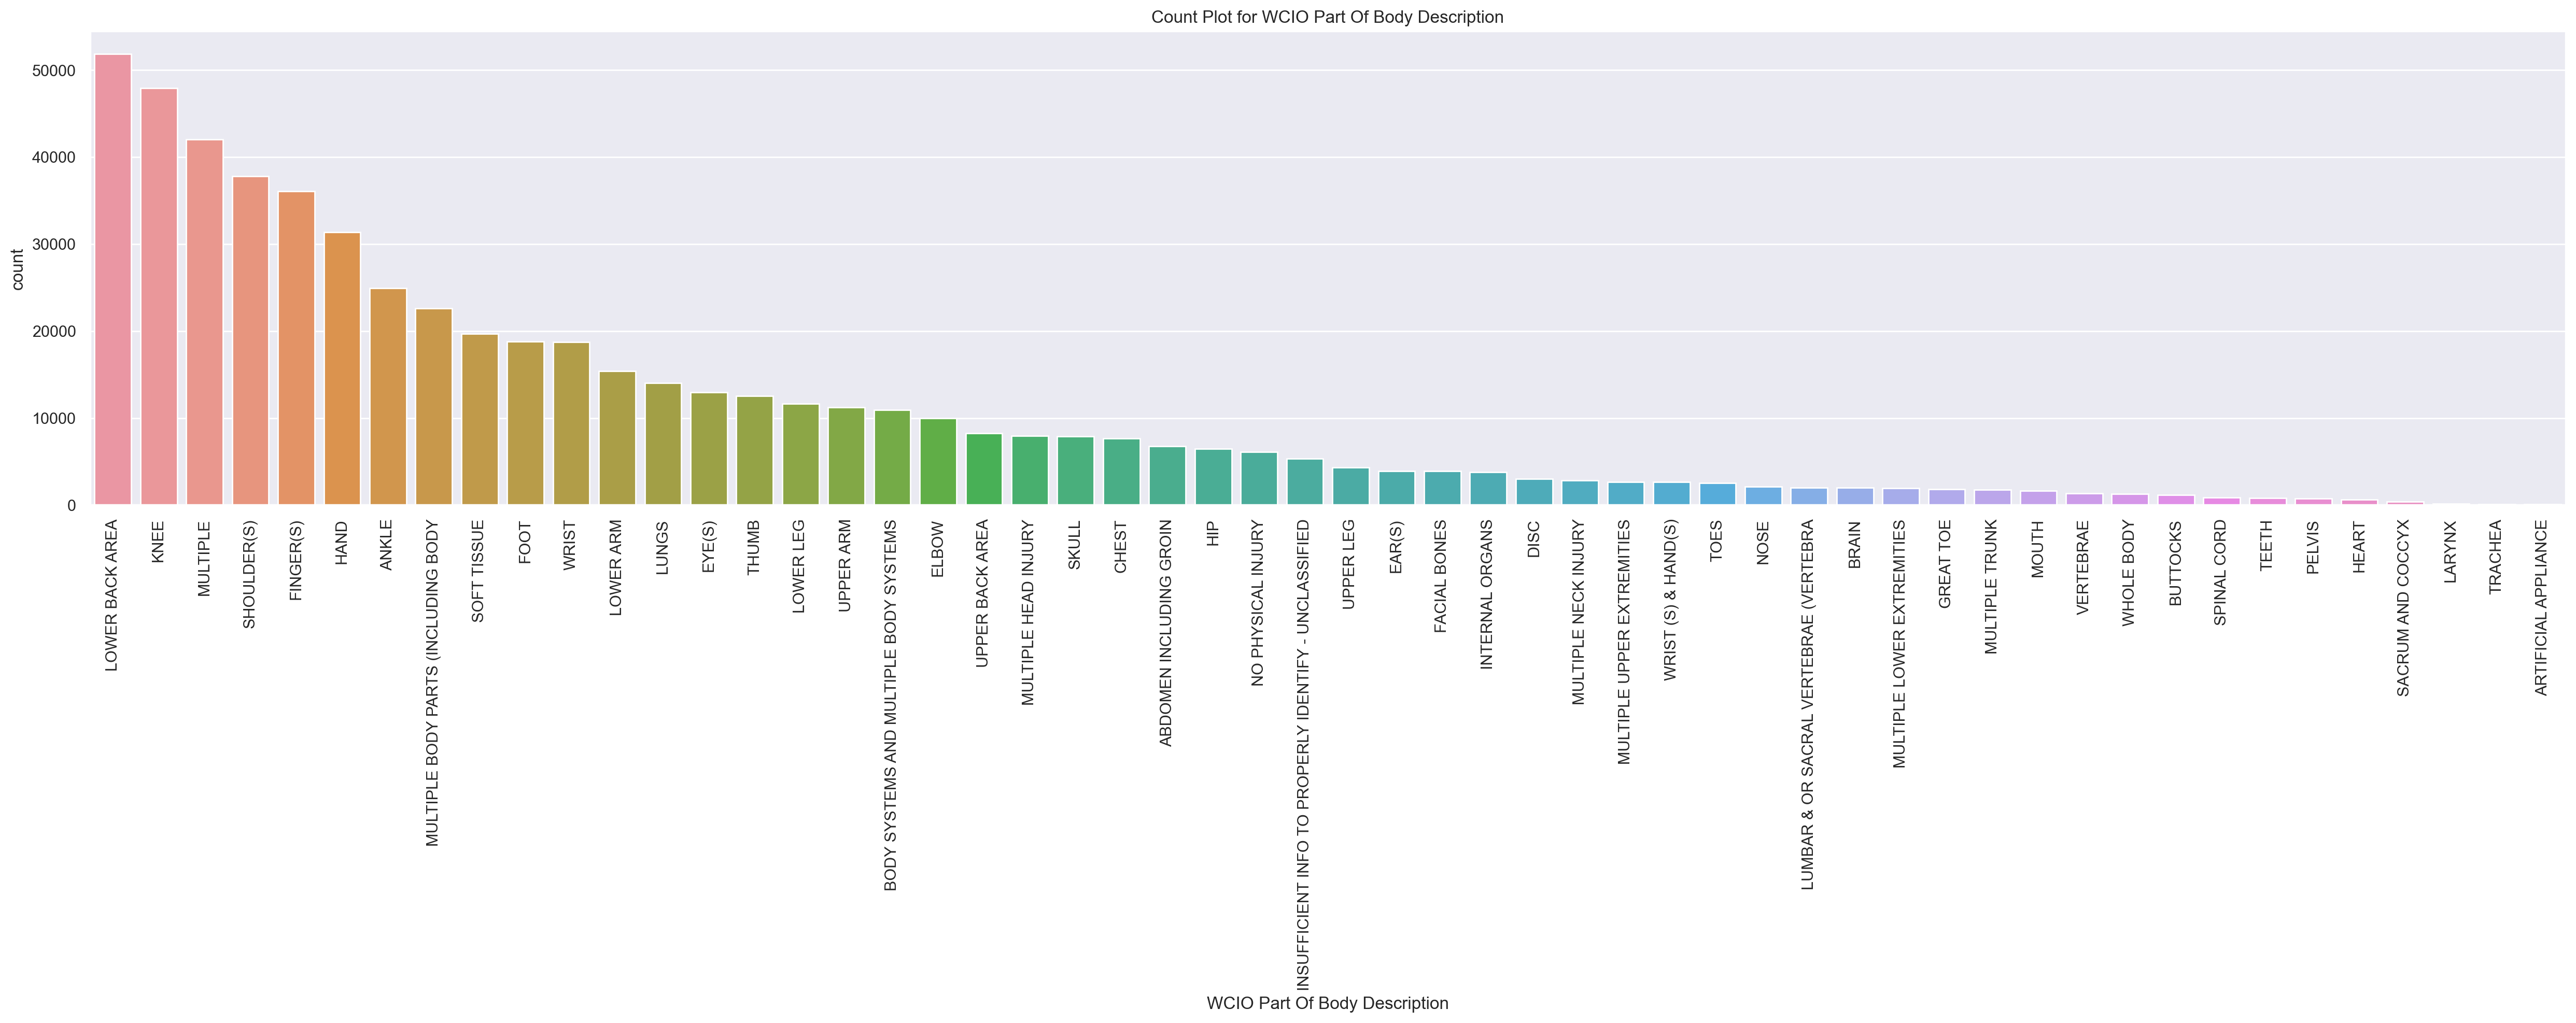

In [31]:
for feature in count_plots1:
    plt.figure(figsize=(25, 10))  # Adjust the figure size as necessary
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index)  # y=feature for horizontal plot
    plt.title(f'Count Plot for {feature}')
    plt.xticks(rotation=90)  # Rotate x-axis labels if needed
    plt.tight_layout()  # Adjusts subplot params so the plots fit into the figure area
    plt.show()

    ################# Count Plot for Carrier Type for smaller data ##################

### Remarks for feature with less categories

*Attorney/Representative*, *Claim Injury Type*, *Carrier type*, *District Name*, *Gender*, and *Medical Fee Region* <br><br>
[Possible Outliers and Unknown data Treatment]
- *Attorney/Representative*: the number of people who hire a legal representative surpasses the double of people who have.
- *Claim Injury Type*: We can group all "PTT" and "PPD" together. This feature is our target, it is better not to change that much.
- *Carrier type*: We can group "UNKNOWN", "5D. SPECIAL FUND", "5C SPECIAL FUNDand" and "5A SPECIAL FUND" to "OTHERS".
- *District Name*: "Statewide" means Unknown. We can change "Statewide" to "Others" or grouped with "Binghamton".
- *Gender*: Drop "X" or group it with "U" and name it to "Others".
- *Medical Fee Region*: "UK" could be Unknown. We can change the label to "Others".


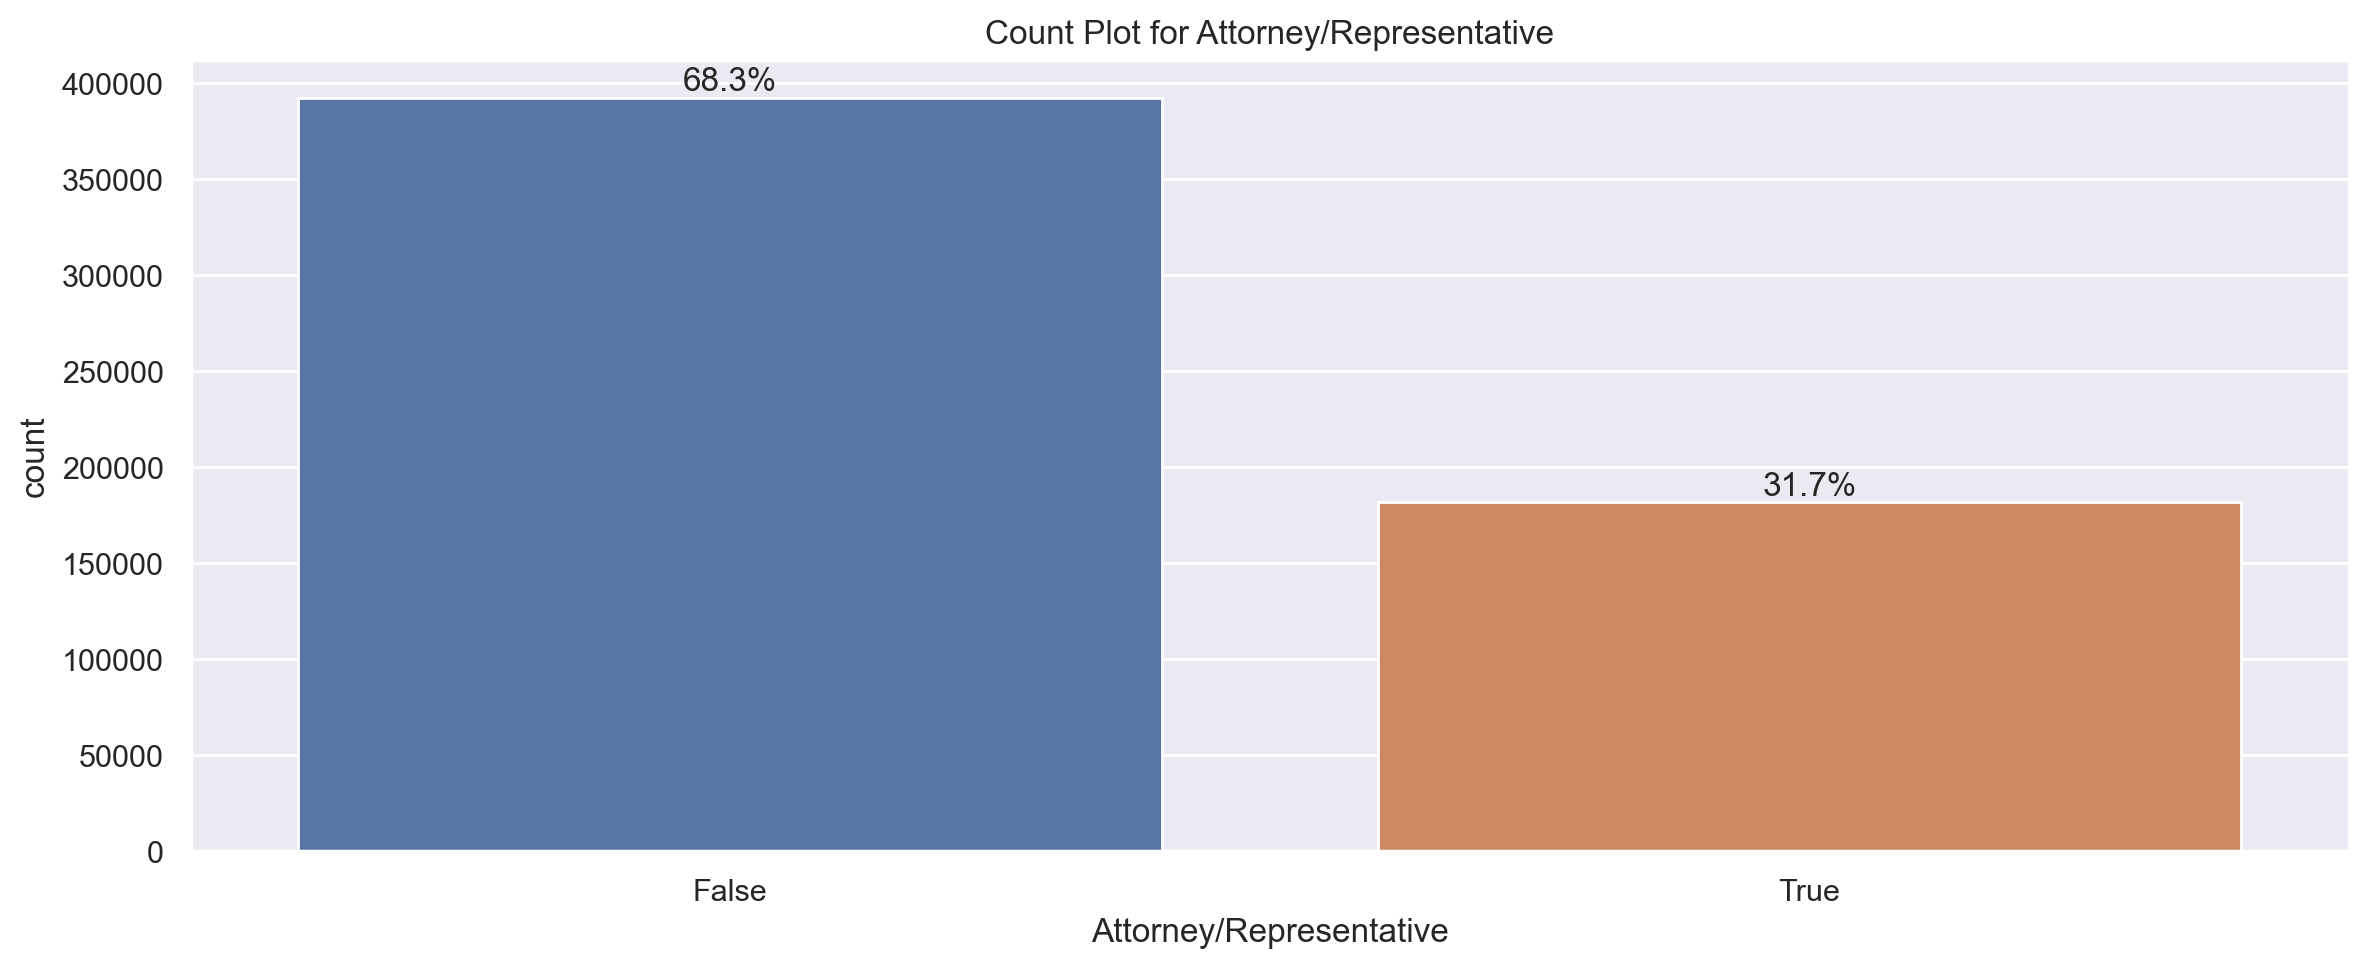

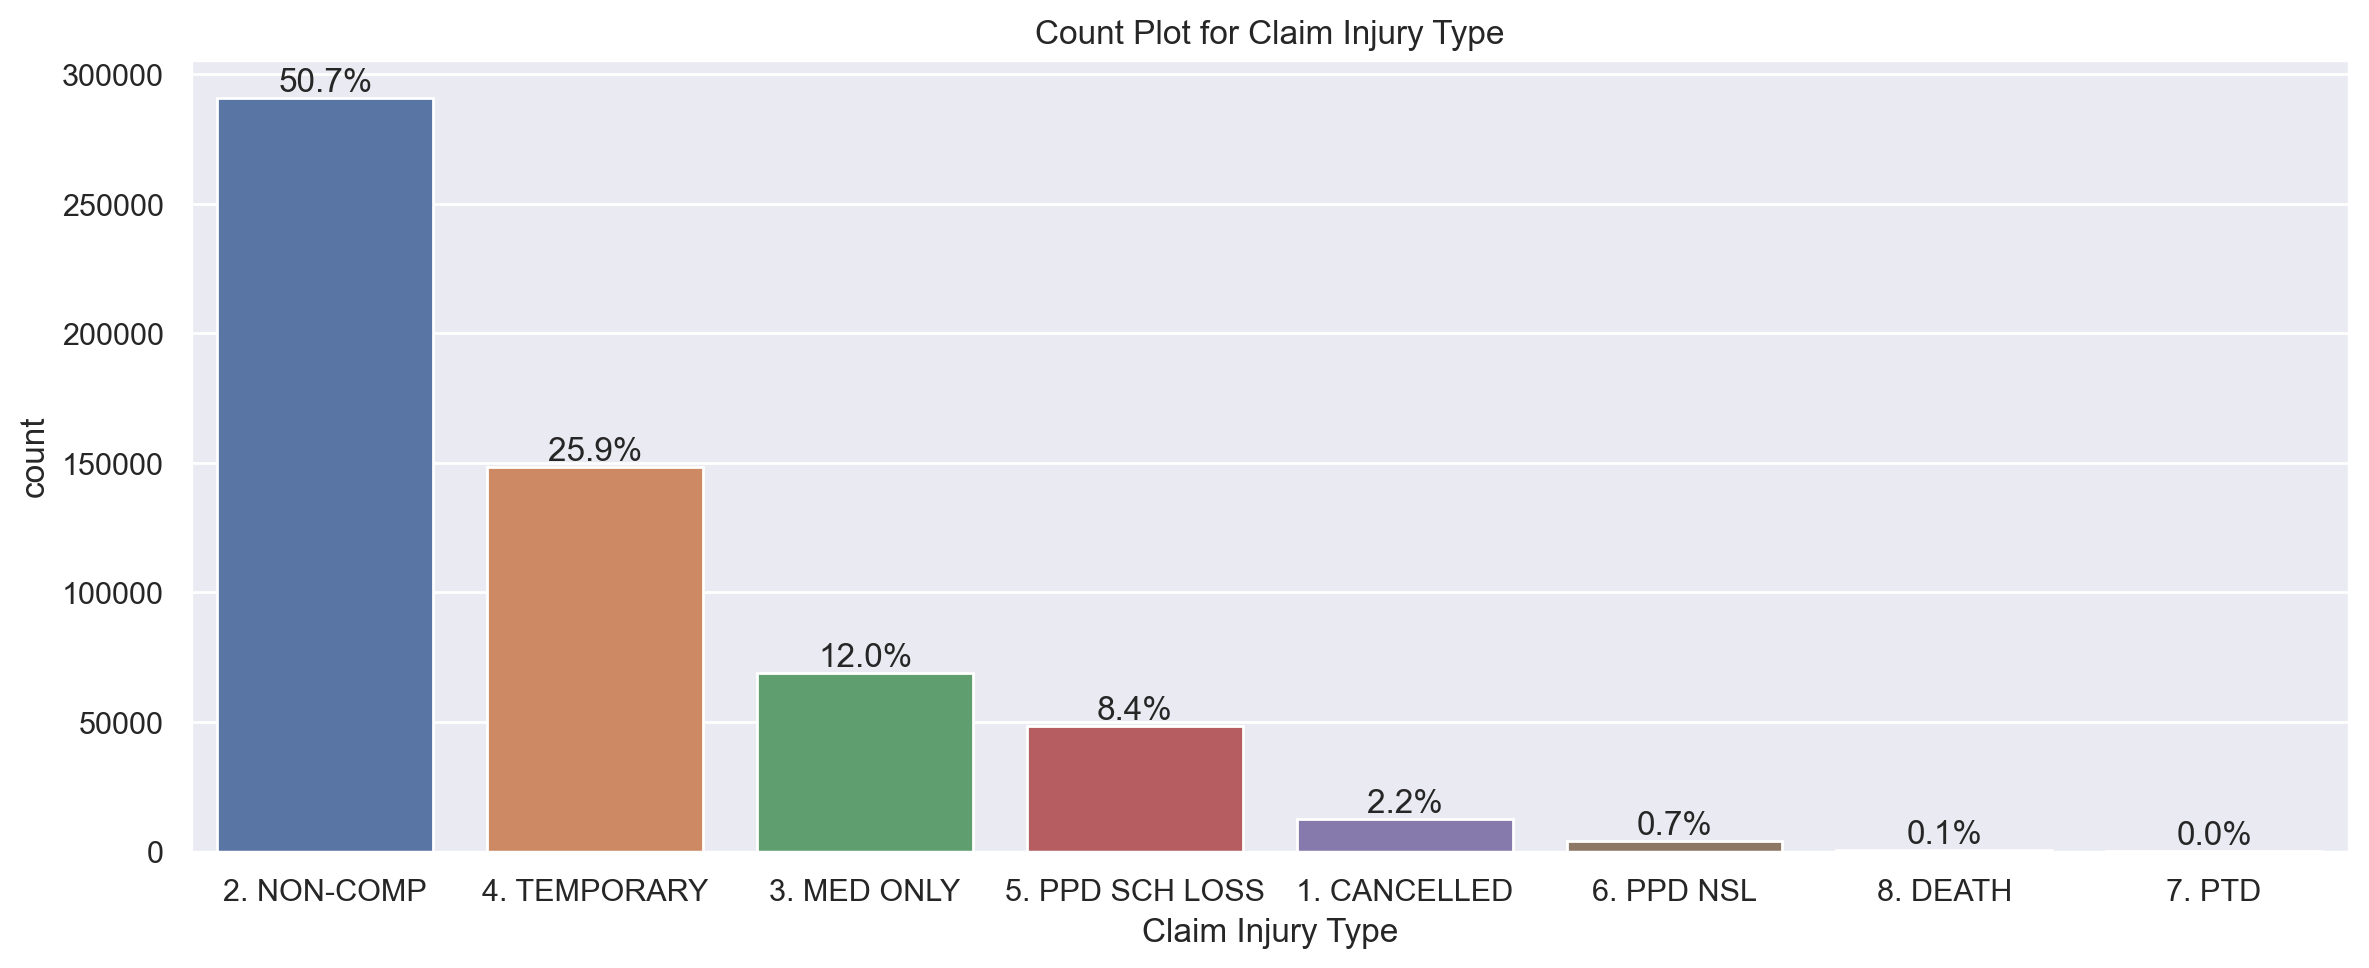

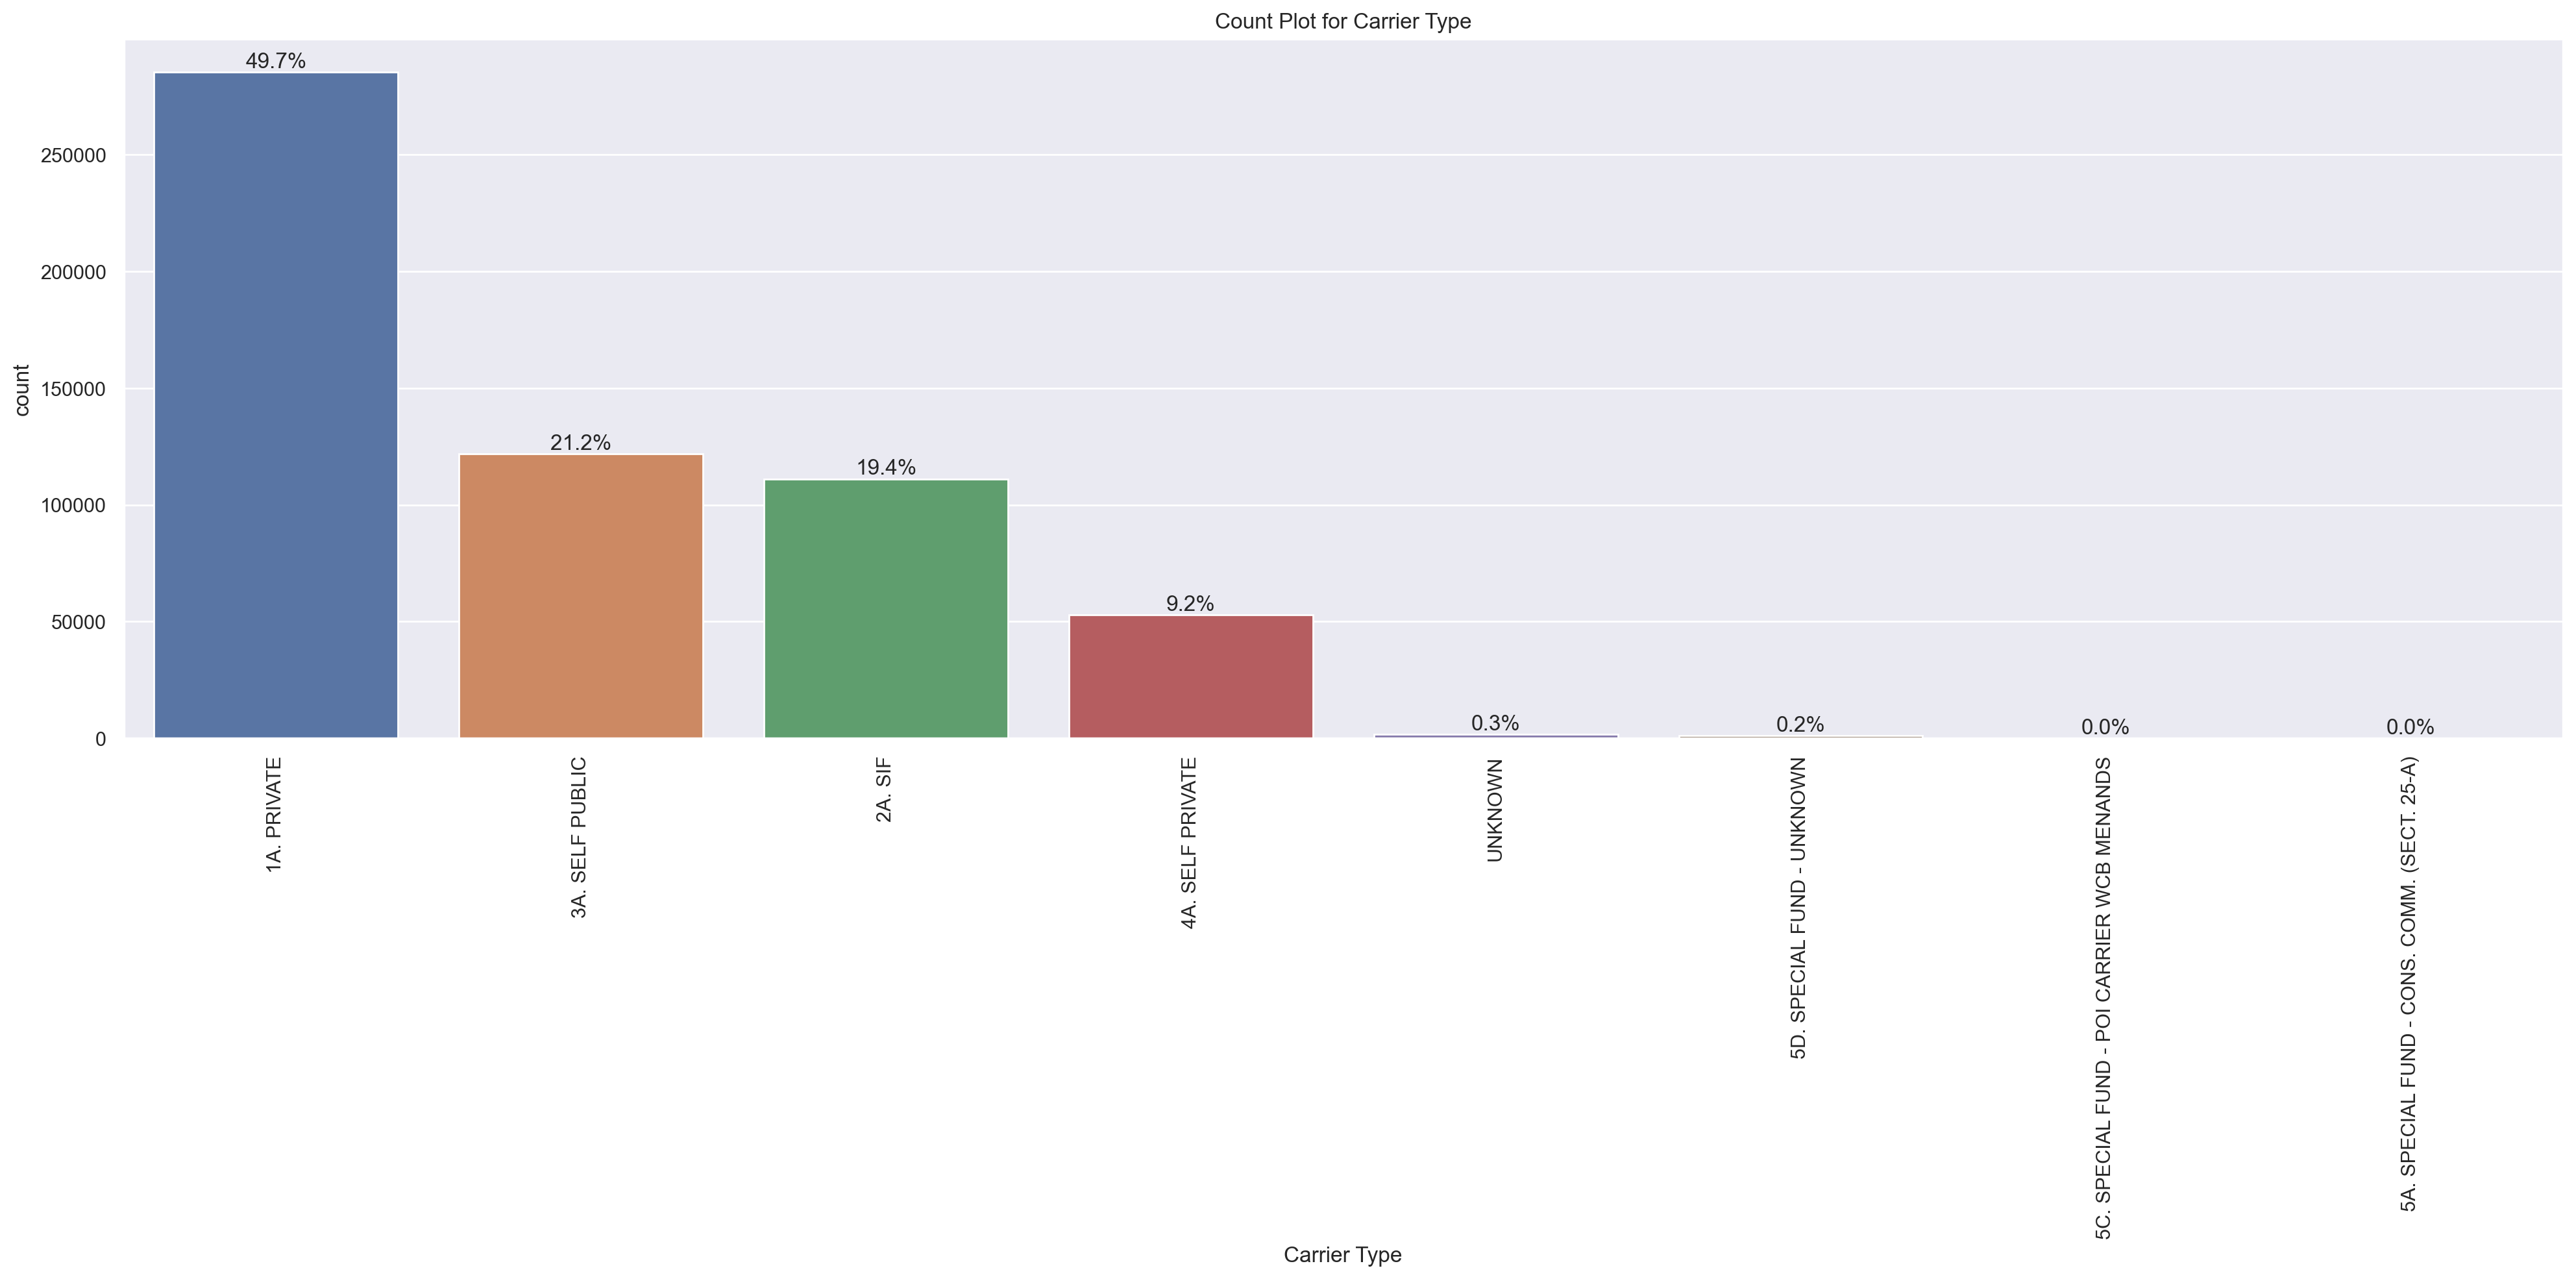

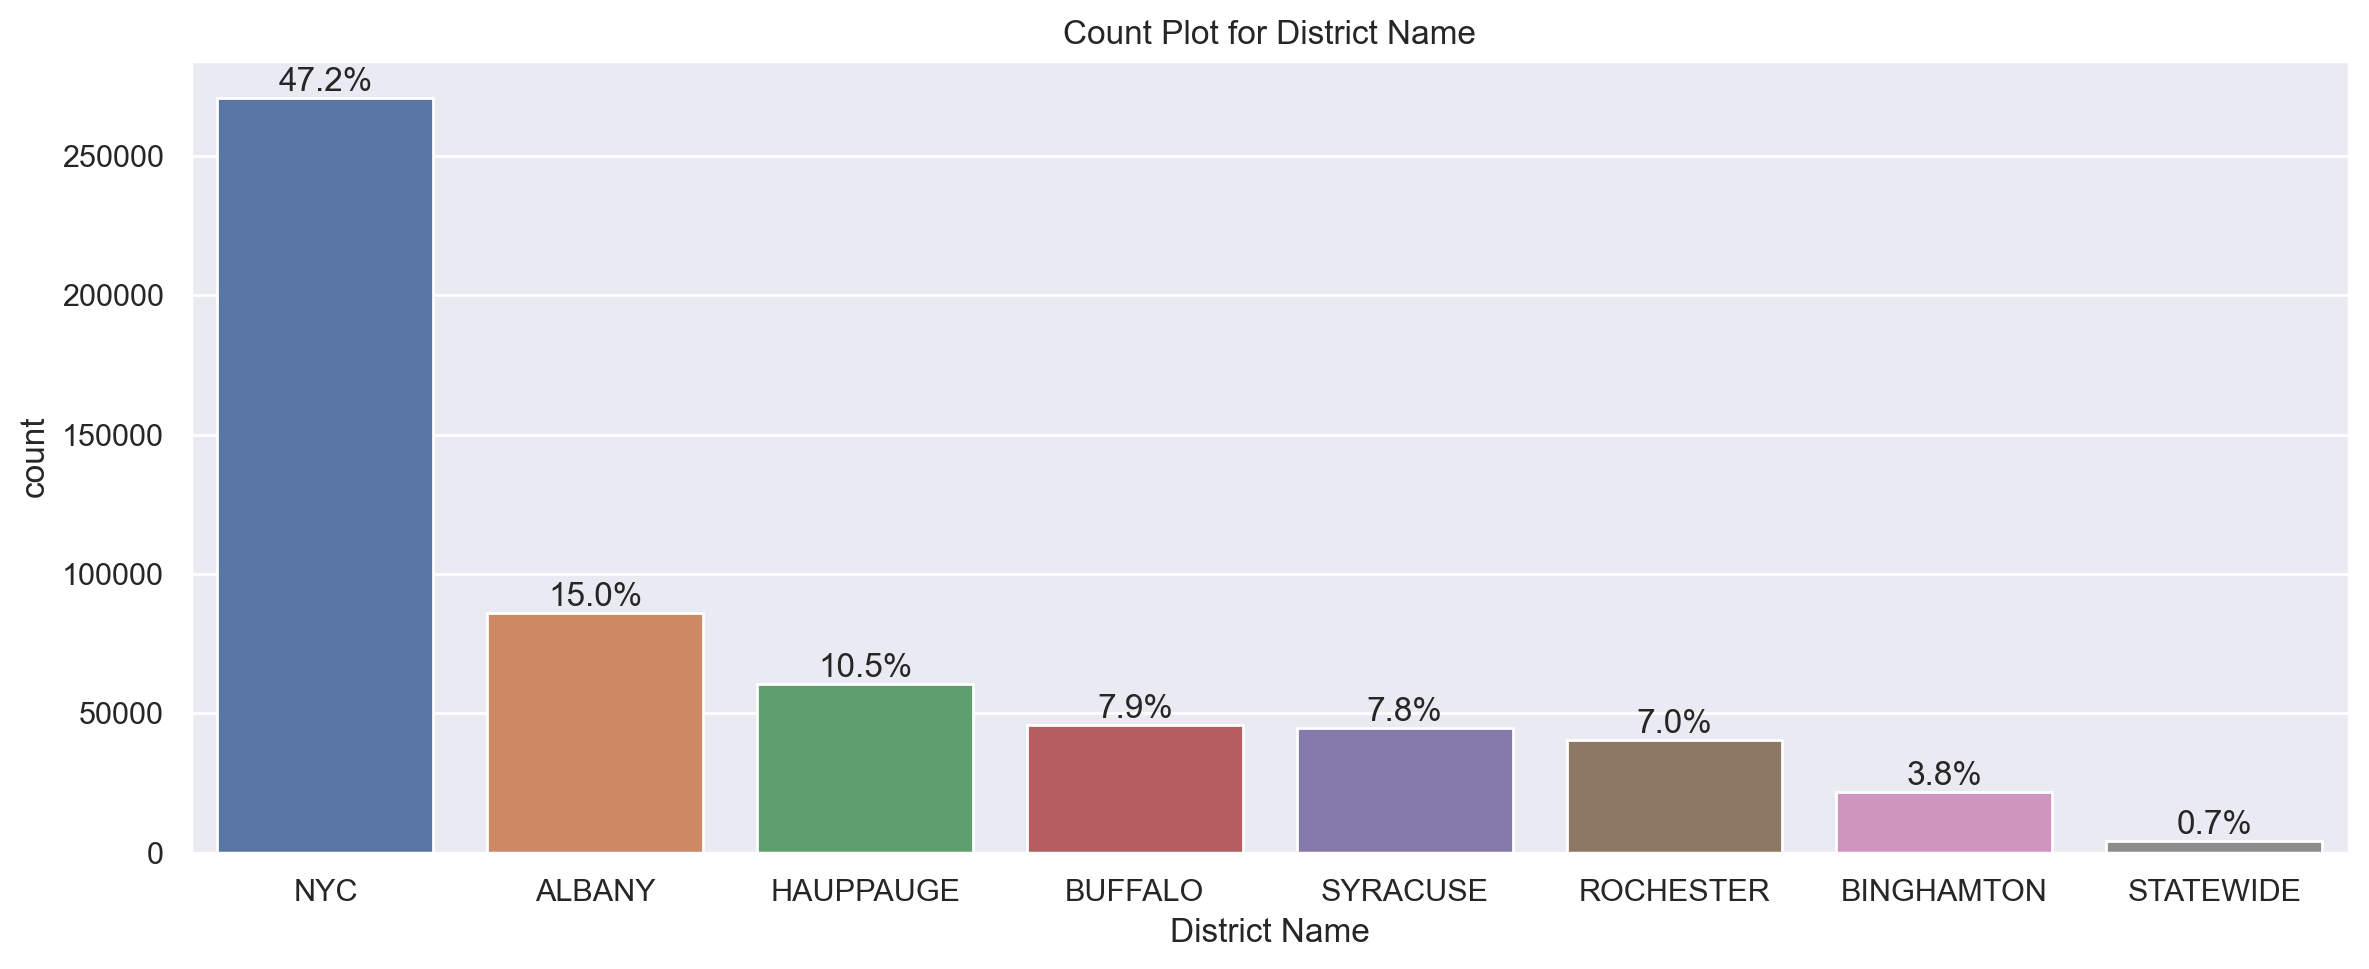

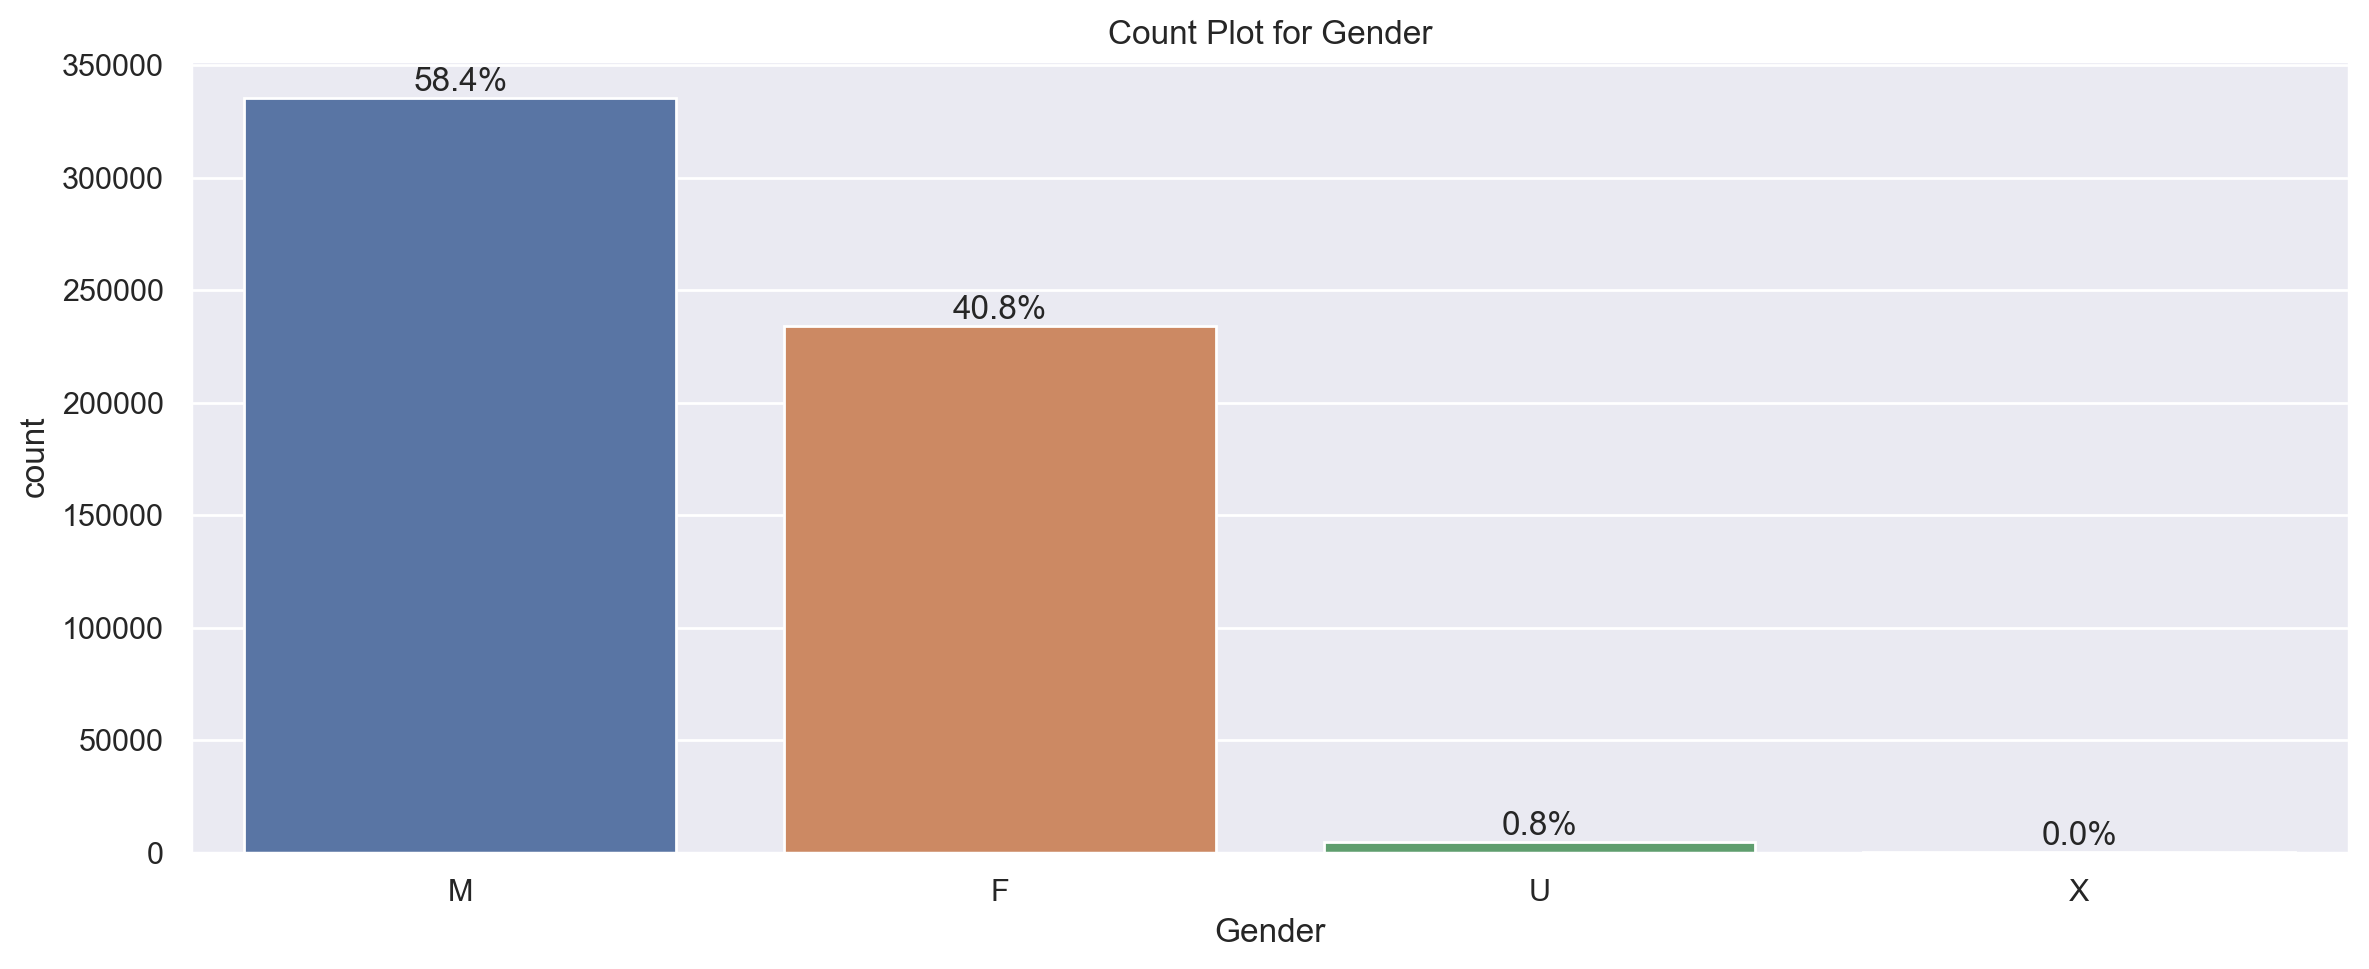

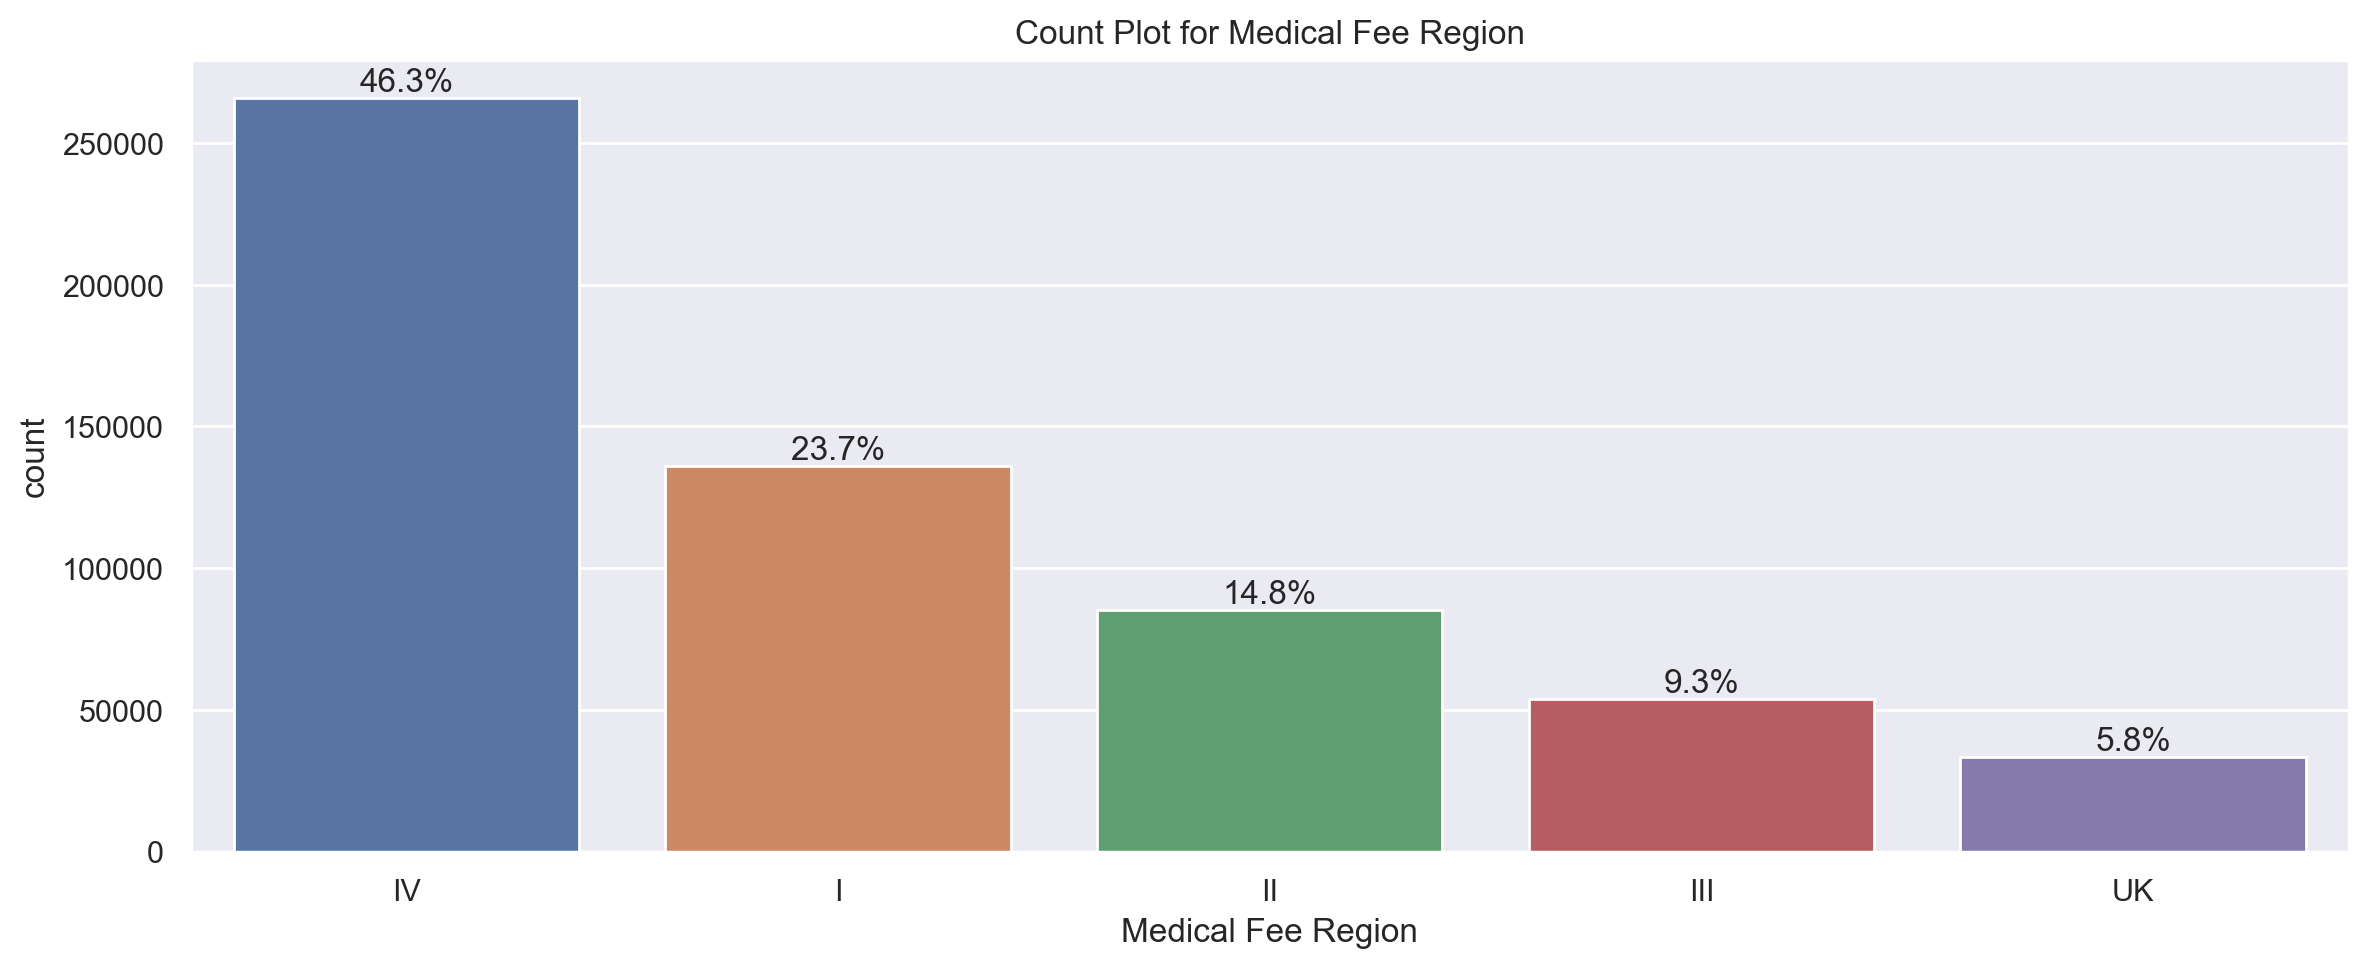

In [32]:
for feature in count_plots2:
    if feature == "Carrier Type":
        plt.figure(figsize=(20, 10))  # larger size for "Carrier Type", so the labels don't overlap
    else:
        plt.figure(figsize=(12, 5)) 

    ax = sns.countplot(data=df, x=feature, order=df[feature].value_counts().index)  # Plot the countplot
    
    # Calculate total number of entries for percentage calculation
    total = len(df[feature])
    
    # Iterate through the bars and annotate with percentages
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)  # Calculate percentage
        x = p.get_x() + p.get_width() / 2  # Get the x position of the bar
        y = p.get_height()  # Get the height of the bar
        ax.annotate(percentage, (x, y), ha='center', va='bottom')  # Annotate with percentage
    
    # rotate x-axis labels of the feature is "Carrier Type", so they don't overlap
    if feature == "Carrier Type":
        plt.xticks(rotation=90)
    
    plt.title(f'Count Plot for {feature}')
    plt.tight_layout()  # Adjusts subplot params so the plots fit into the figure area
    plt.show()

## 3.2.2. Pie Charts
### Remarks
- There are huge gaps in the binary features, all with a dominant group (False in all) with a frequency higher than 95%.

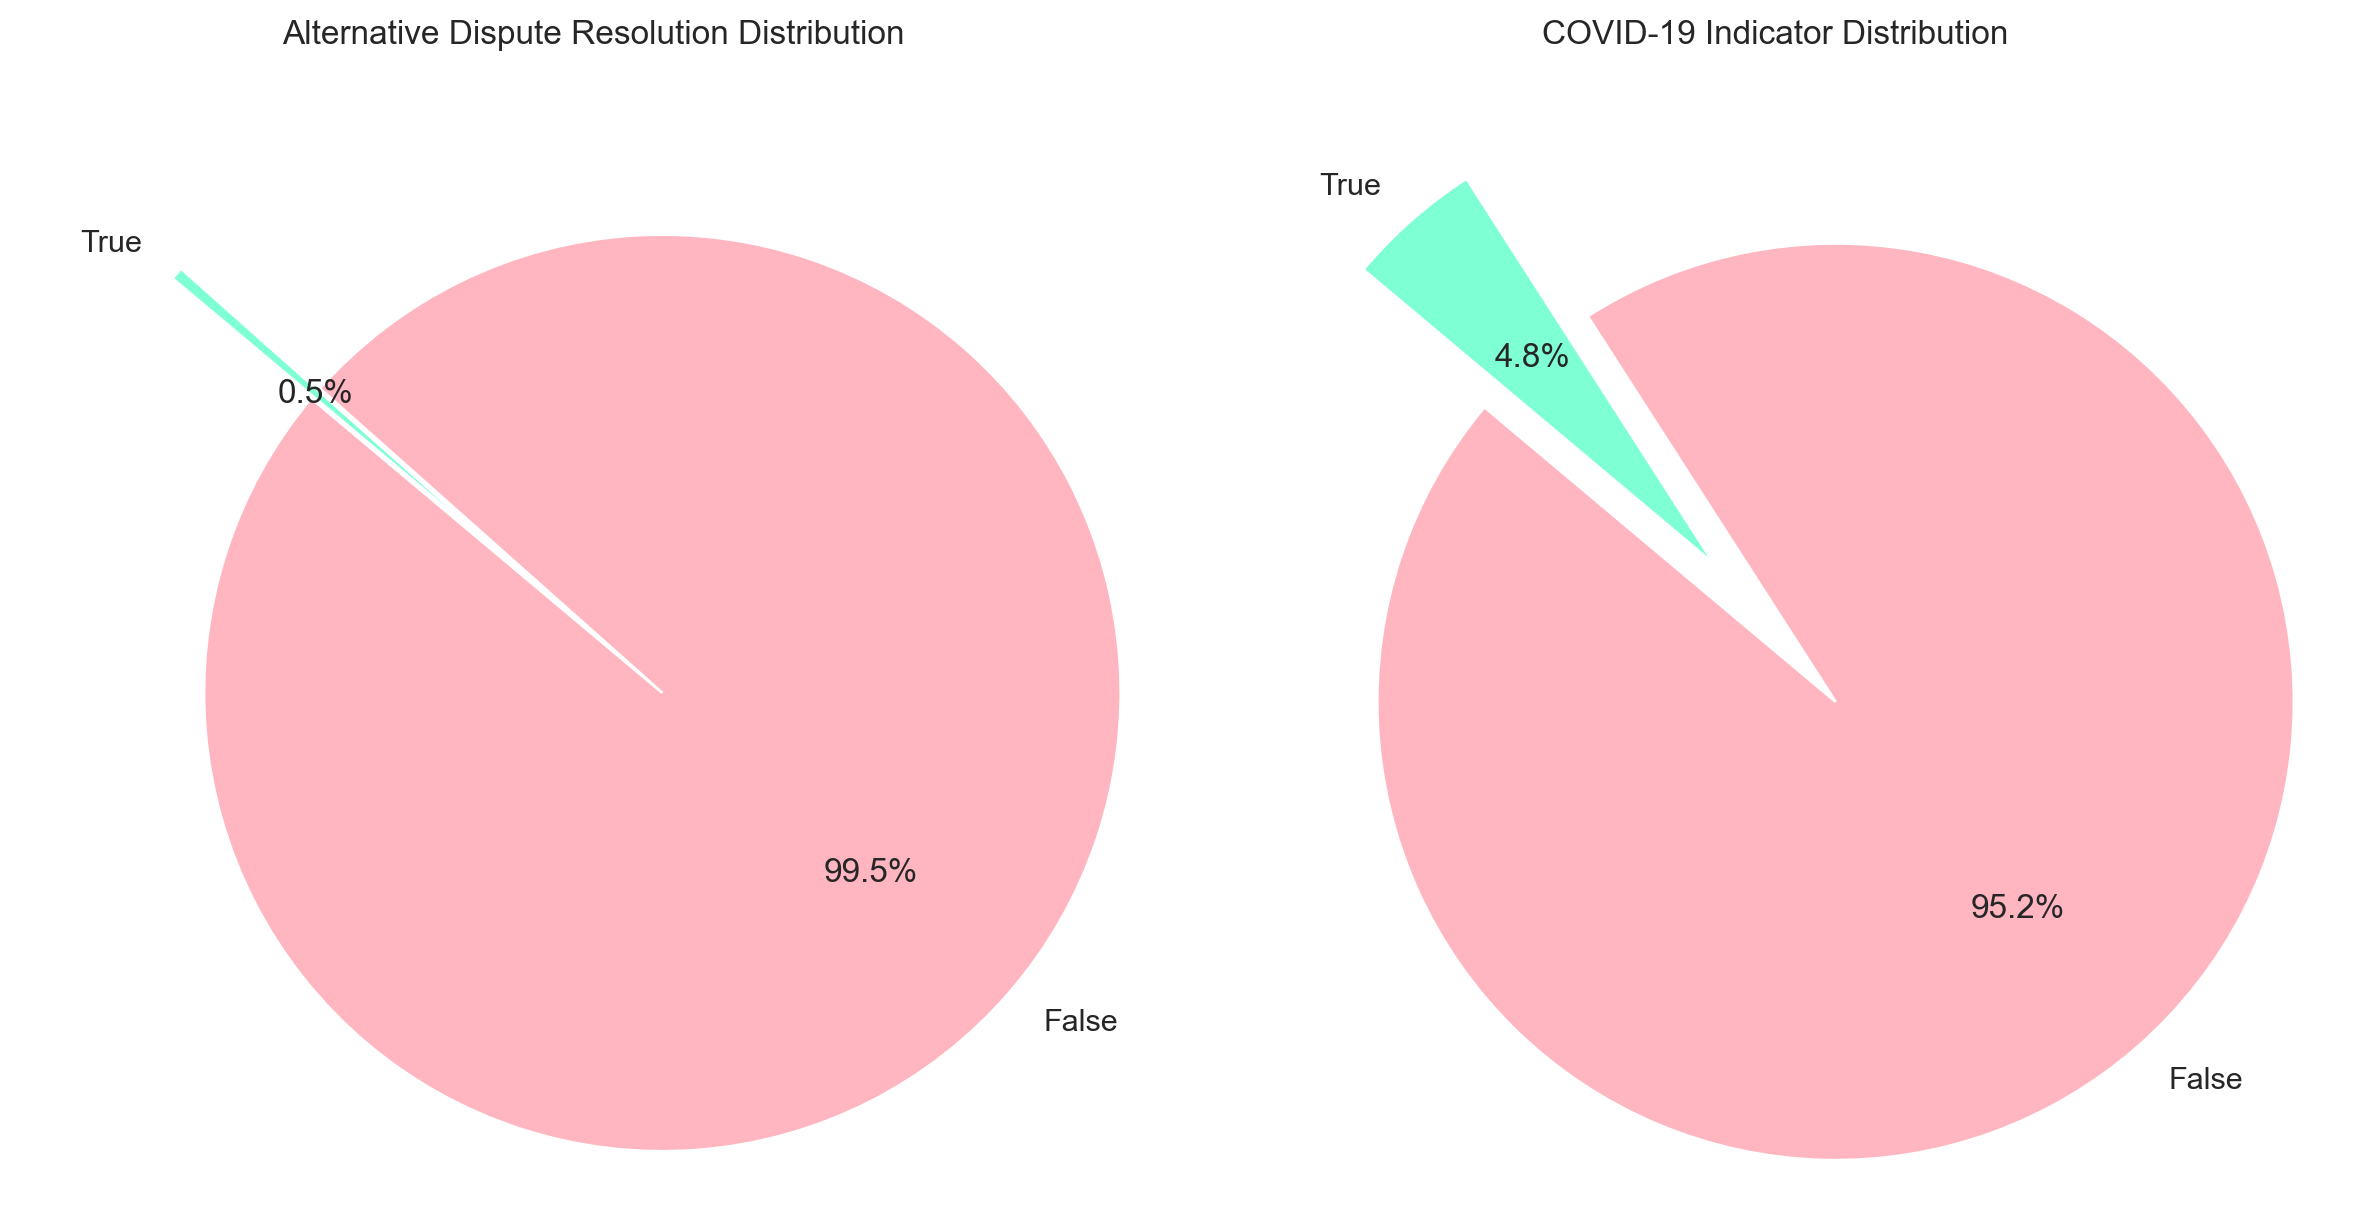

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10))  
axes = axes.flatten()

# pie chart for each variable
for i, feature in enumerate(pie_charts):
    values = df[feature].value_counts()  # Count values for the feature
    labels = values.index  # Categories (True/False, Yes/No, etc.)
    axes[i].pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightpink', 'aquamarine', 'salmon', 'gold'], explode = [0.2] * len(values))
    axes[i].set_title(f'{feature} Distribution')

# Adjust layout to prevent overlap
plt.tight_layout()

## 3.2.3. Compare Categorical and Numerical Features

## 3.2.3.1. Compare the Numeric Features by *Claim Injury Type*
### Remarks

It can be observed that they are all very fairly distributed. In *Age at Injury*, there's a slight higher median in the boxplot of people who died, which is expected because the elderly are more likely to die than the young in general.

- **Age at Injury by Claim Injury Type**: It makes sense that the injured is between the middle 20s to 50s. There are many old age outliers in "NON-COMP". The distribution of "Death" is slightly higher (older) than that of other categories.
- **Number of Dependents by Claim Injury Type**: Once again, the number of dependents seems fairly distributed, with a slight decrease in the third quartile of people who claim PTD.

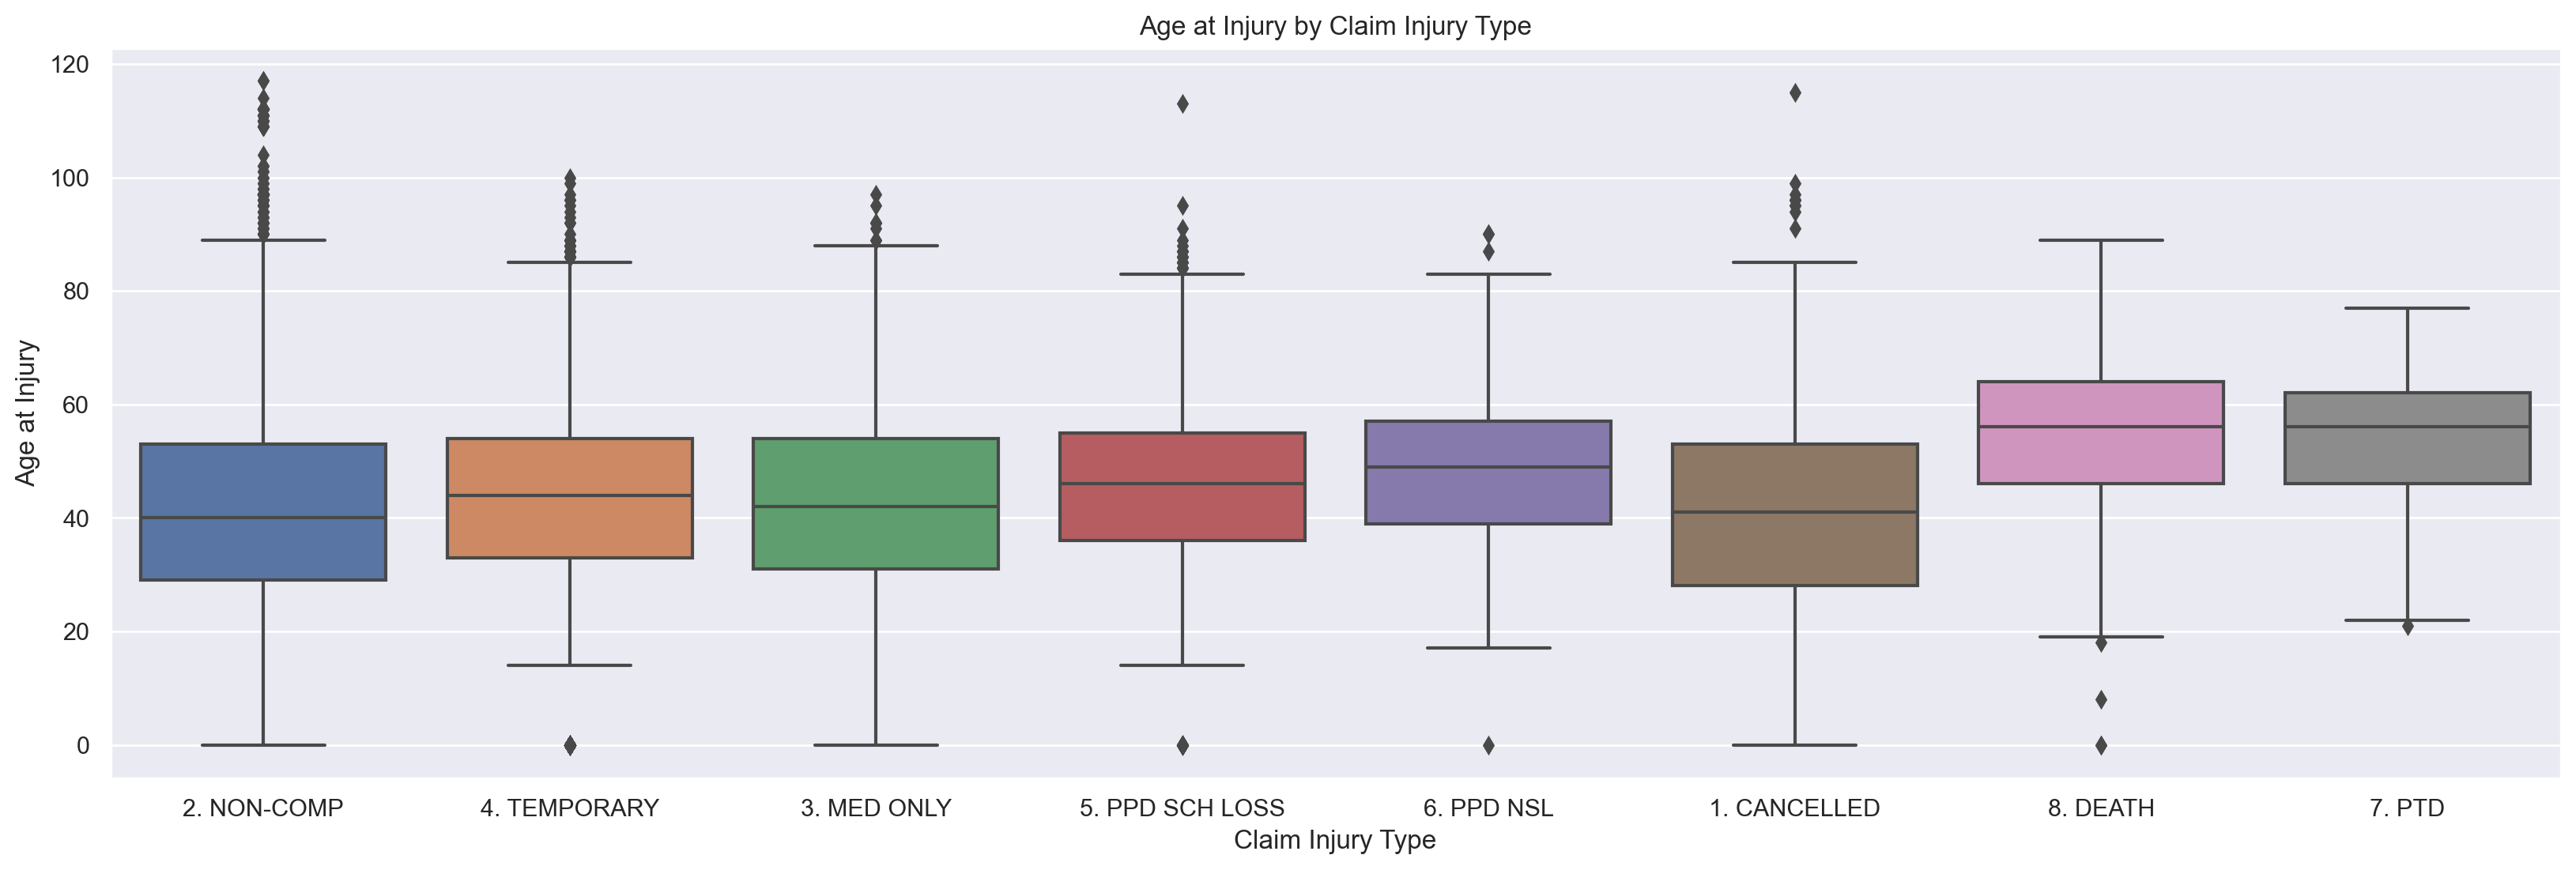

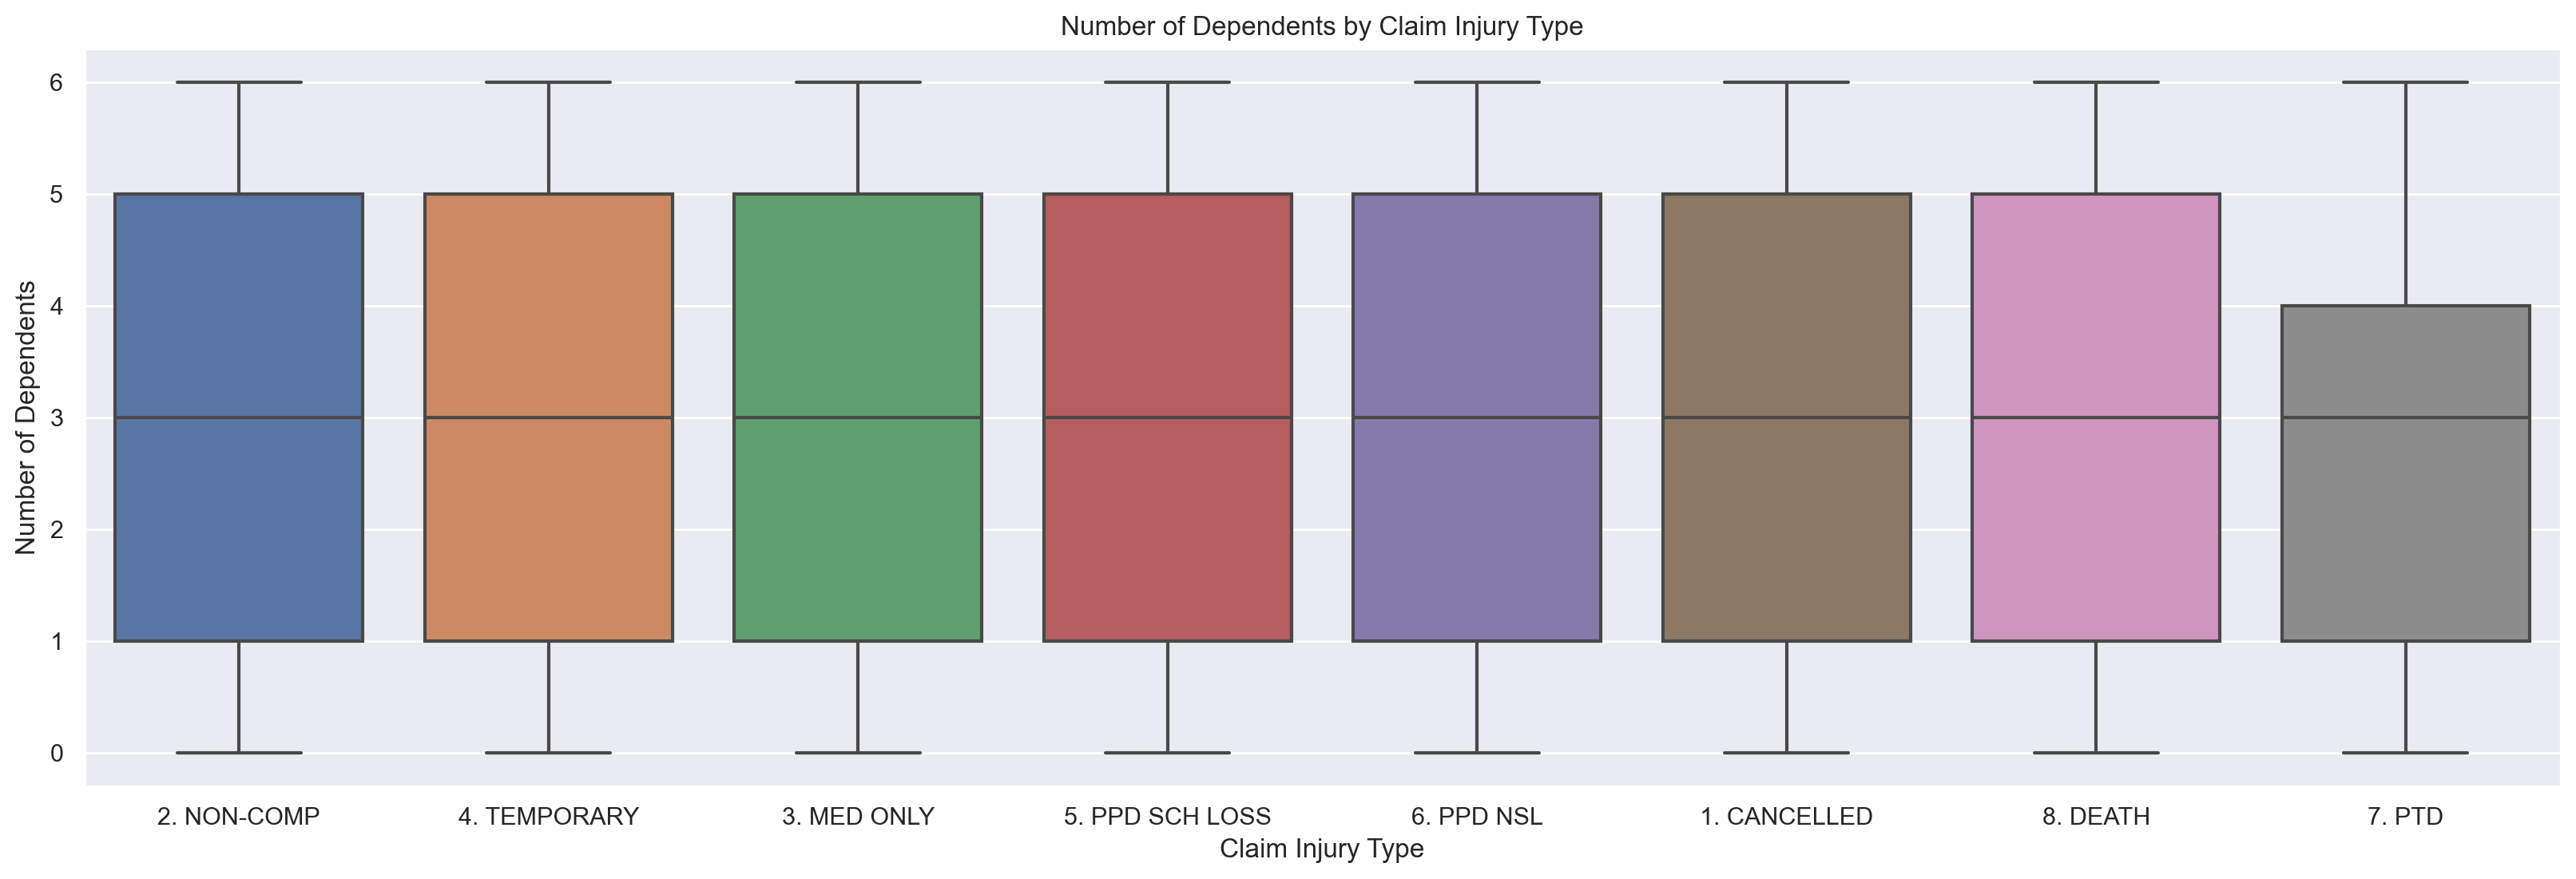

In [34]:
for feature in ["Age at Injury", "Number of Dependents"]:
    plt.figure(figsize=(20, 6))
    sns.boxplot(x='Claim Injury Type', y=feature, data=df)
    plt.title(f"{feature} by Claim Injury Type")
    plt.show()

Even though *Birth Year* and *Average Weekly Wage* are also metric features and should also be taken into consideration for this visual exploration, the boxplot visualization of both graphs was being twisted by the outliers, so we've decided to check it after taking care of them.

## 3.2.3.2. Compare Categorical Features by *Claim Injury Type*

### Remarks for Comparing *Attorney/Representative* by *Claim Injury Type*
Since our p-value is approximately 0 in the Chi-Square Test, we conclude that there is a statistical evidence that *Attorney/Representative* and *Claim Injury Type* are strongly related. This means that the presence of a legal representative might influence the *Type of Injury* that the patient claims. It is also important to notice that, in the presence of a legal representative, the amount of "NON-COMP" drops drastically and "PPD SCH LOSS" surges significantly.

Chi-Square Test for Attorney/Representative and Claim Injury Type: 0.0


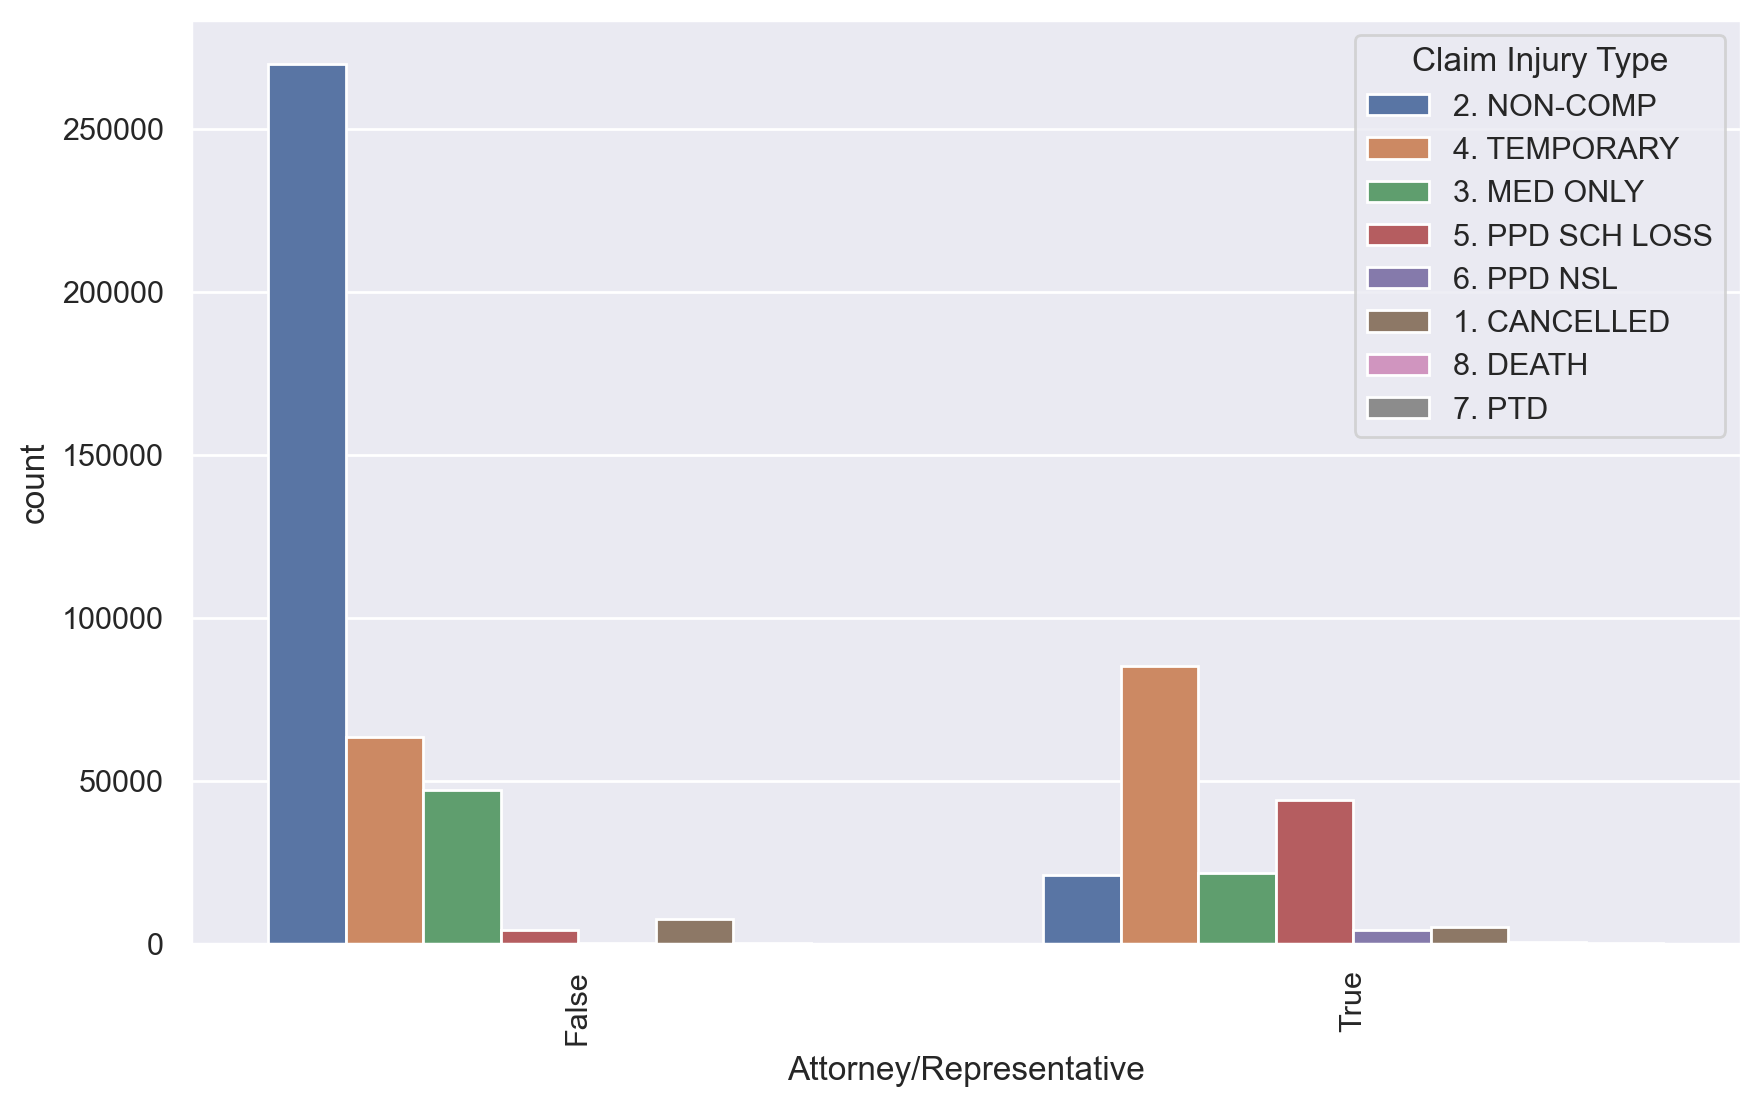

In [35]:
# Check association between variable: crosstab + Chi-Square test
at_ct = pd.crosstab(df['Attorney/Representative'], df['Claim Injury Type'])
chi2, p, i, i = stats.chi2_contingency(at_ct)
print("Chi-Square Test for Attorney/Representative and Claim Injury Type:", p)

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Attorney/Representative', hue='Claim Injury Type', data=df)
plt.xticks(rotation=90)
plt.show()

### Remarks for Comparing *Carrier Type* by *Claim Injury Type*
On a similar note, our p-value is also approximately 0 in the Chi-Square Test. Thus, we also conclude there is a statistical evidence that *Carrier Type* and *Claim Injury Type* are strongly related. It is noticeable that "NON-COMP" is the biggest.

Chi-Square Test for Carrier Type and Claim Injury Type: 0.0


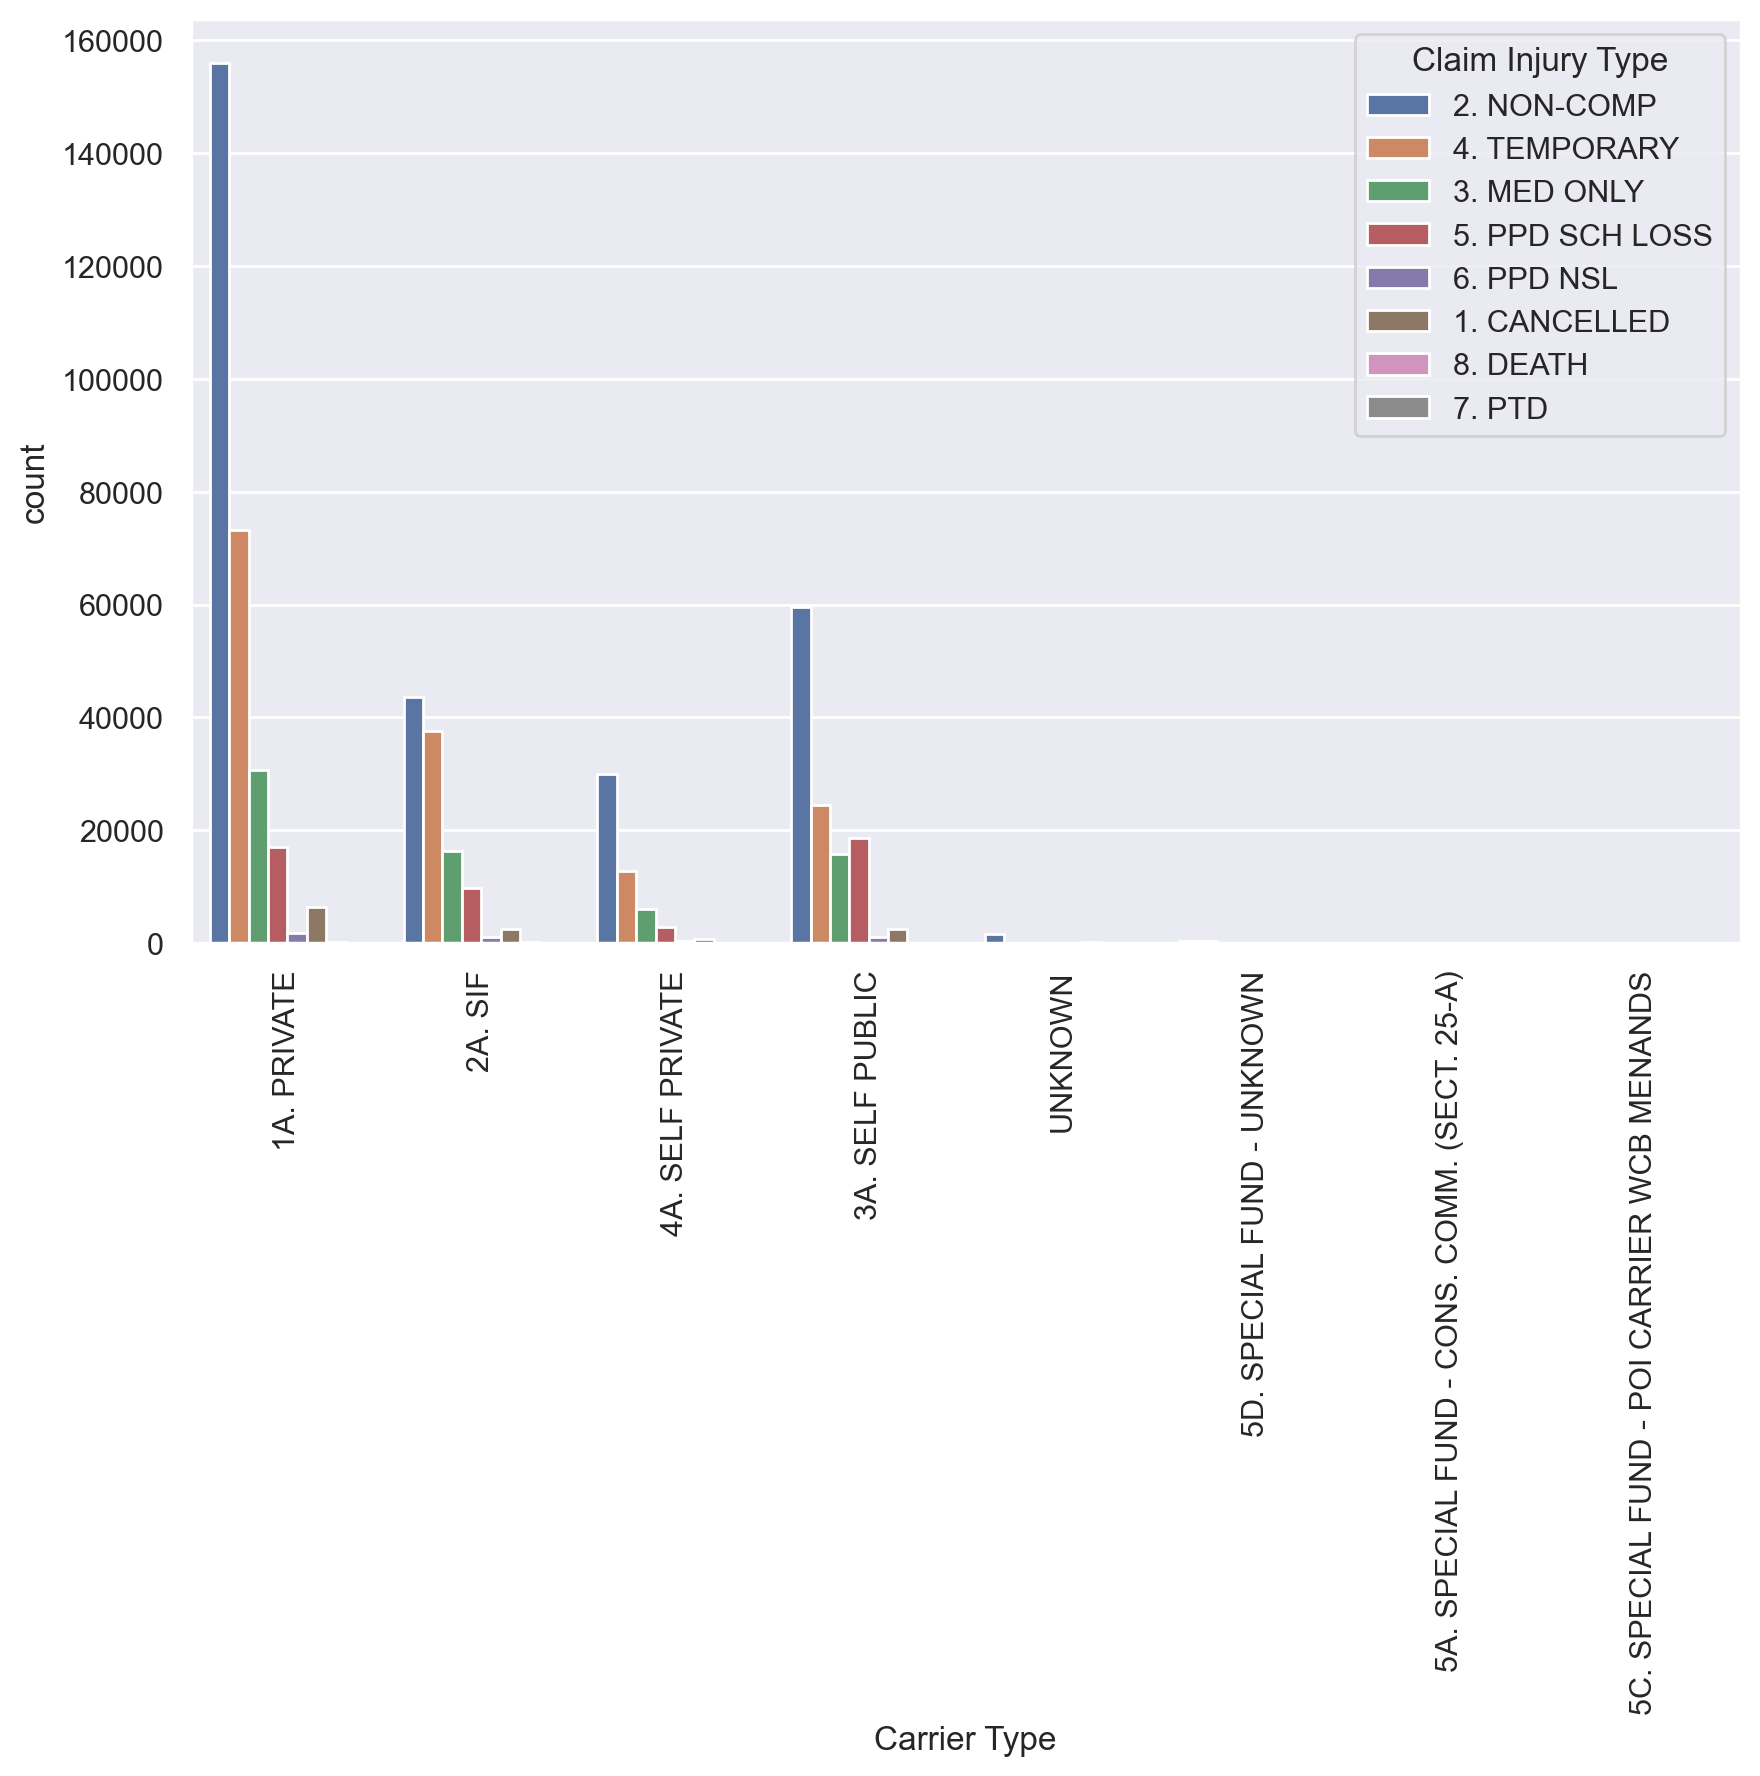

In [36]:
# Crosstab and Chi-Square test
at_ct = pd.crosstab(df['Carrier Type'], df['Claim Injury Type'])
chi2, p, i, i = stats.chi2_contingency(at_ct)
print("Chi-Square Test for Carrier Type and Claim Injury Type:", p)

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Carrier Type', hue='Claim Injury Type', data=df)
plt.xticks(rotation=90)
plt.show()

### Remarks for Comparing *Alternative Dispute Resolution* by *Claim Injury Type*
The p-value in the Chi-Square Test suggests a strong relation between *Alternative Dispute Resolution* and *Claim Injury Type* as well. Most people did not search for a Alternative Dispute Resolution in order to resolve their process, and the majority of the people who did it ended up with "NON-COMP".

Chi-Square Test for Alternative Dispute Resolution and Claim Injury Type: 0.0


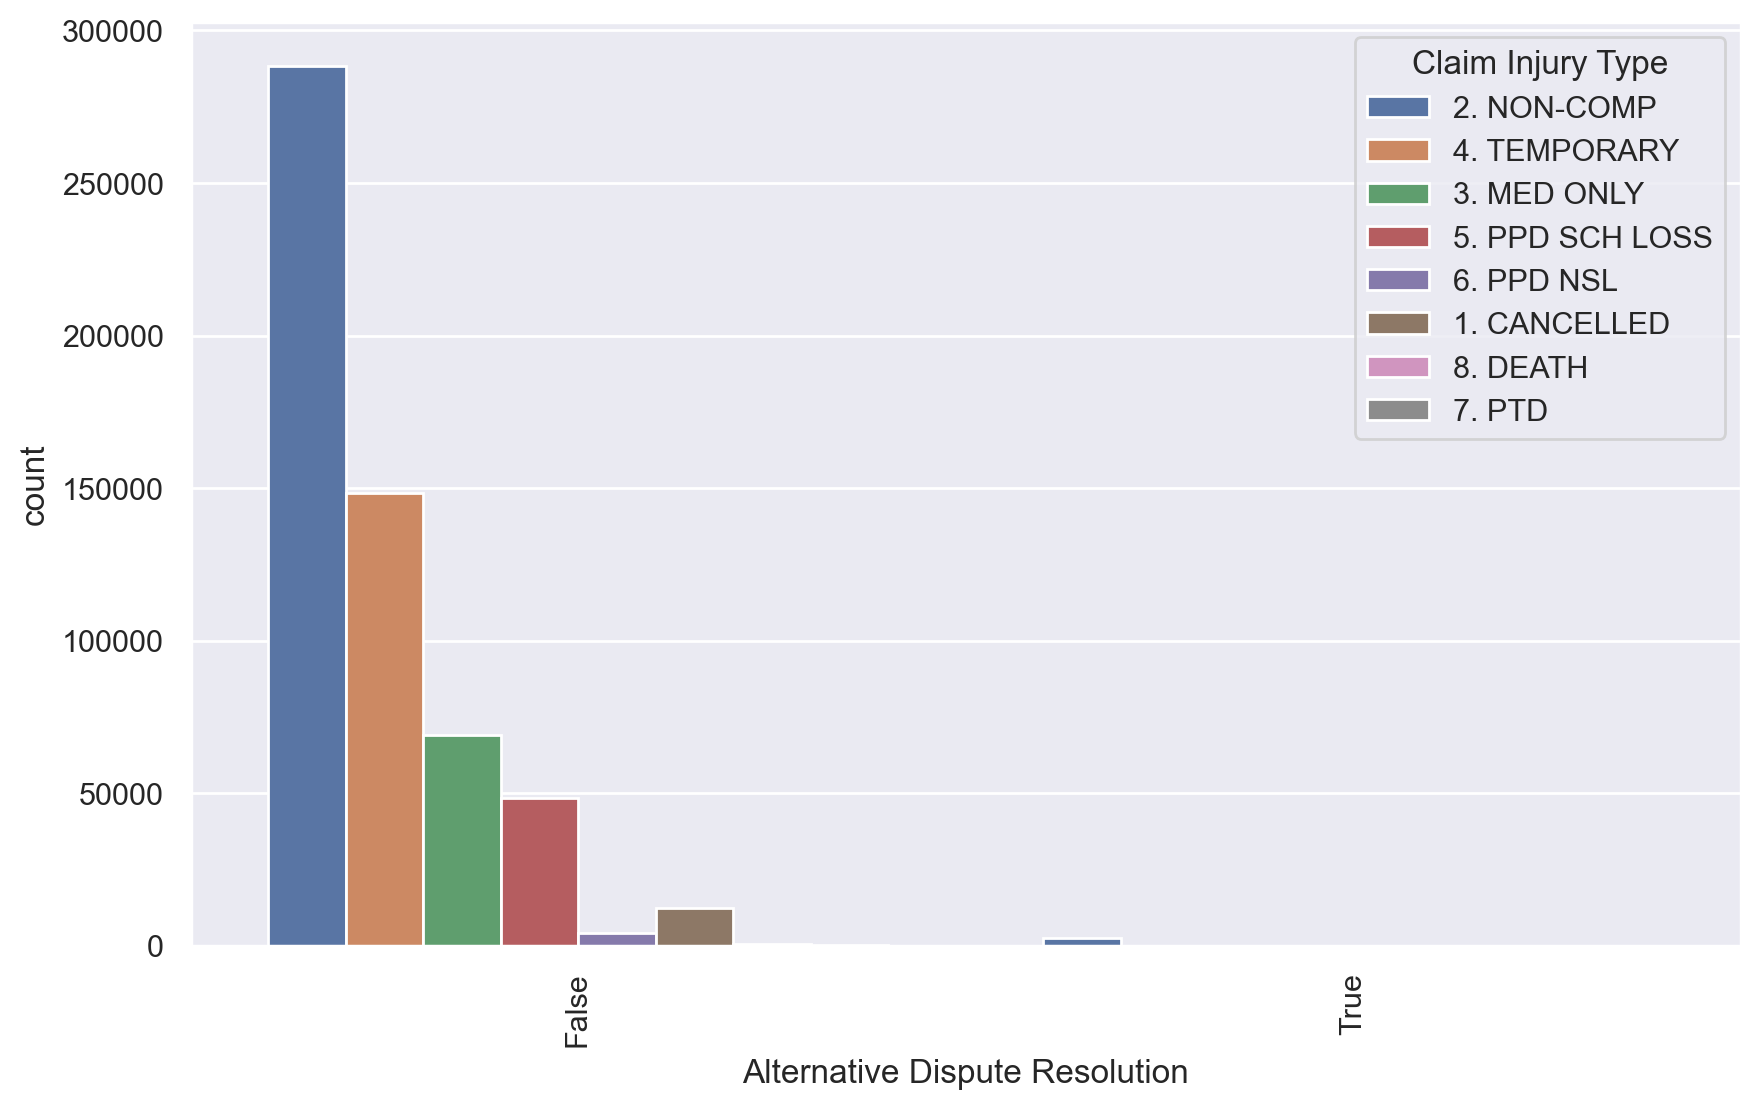

In [37]:
# Crosstab and Chi-Square test
at_ct = pd.crosstab(df['Alternative Dispute Resolution'], df['Claim Injury Type'])
chi2, p, i, i = stats.chi2_contingency(at_ct)
print("Chi-Square Test for Alternative Dispute Resolution and Claim Injury Type:", p)

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Alternative Dispute Resolution', hue='Claim Injury Type', data=df)
plt.xticks(rotation=90)
plt.show()

Let's take a closer look at the right side of this graph:

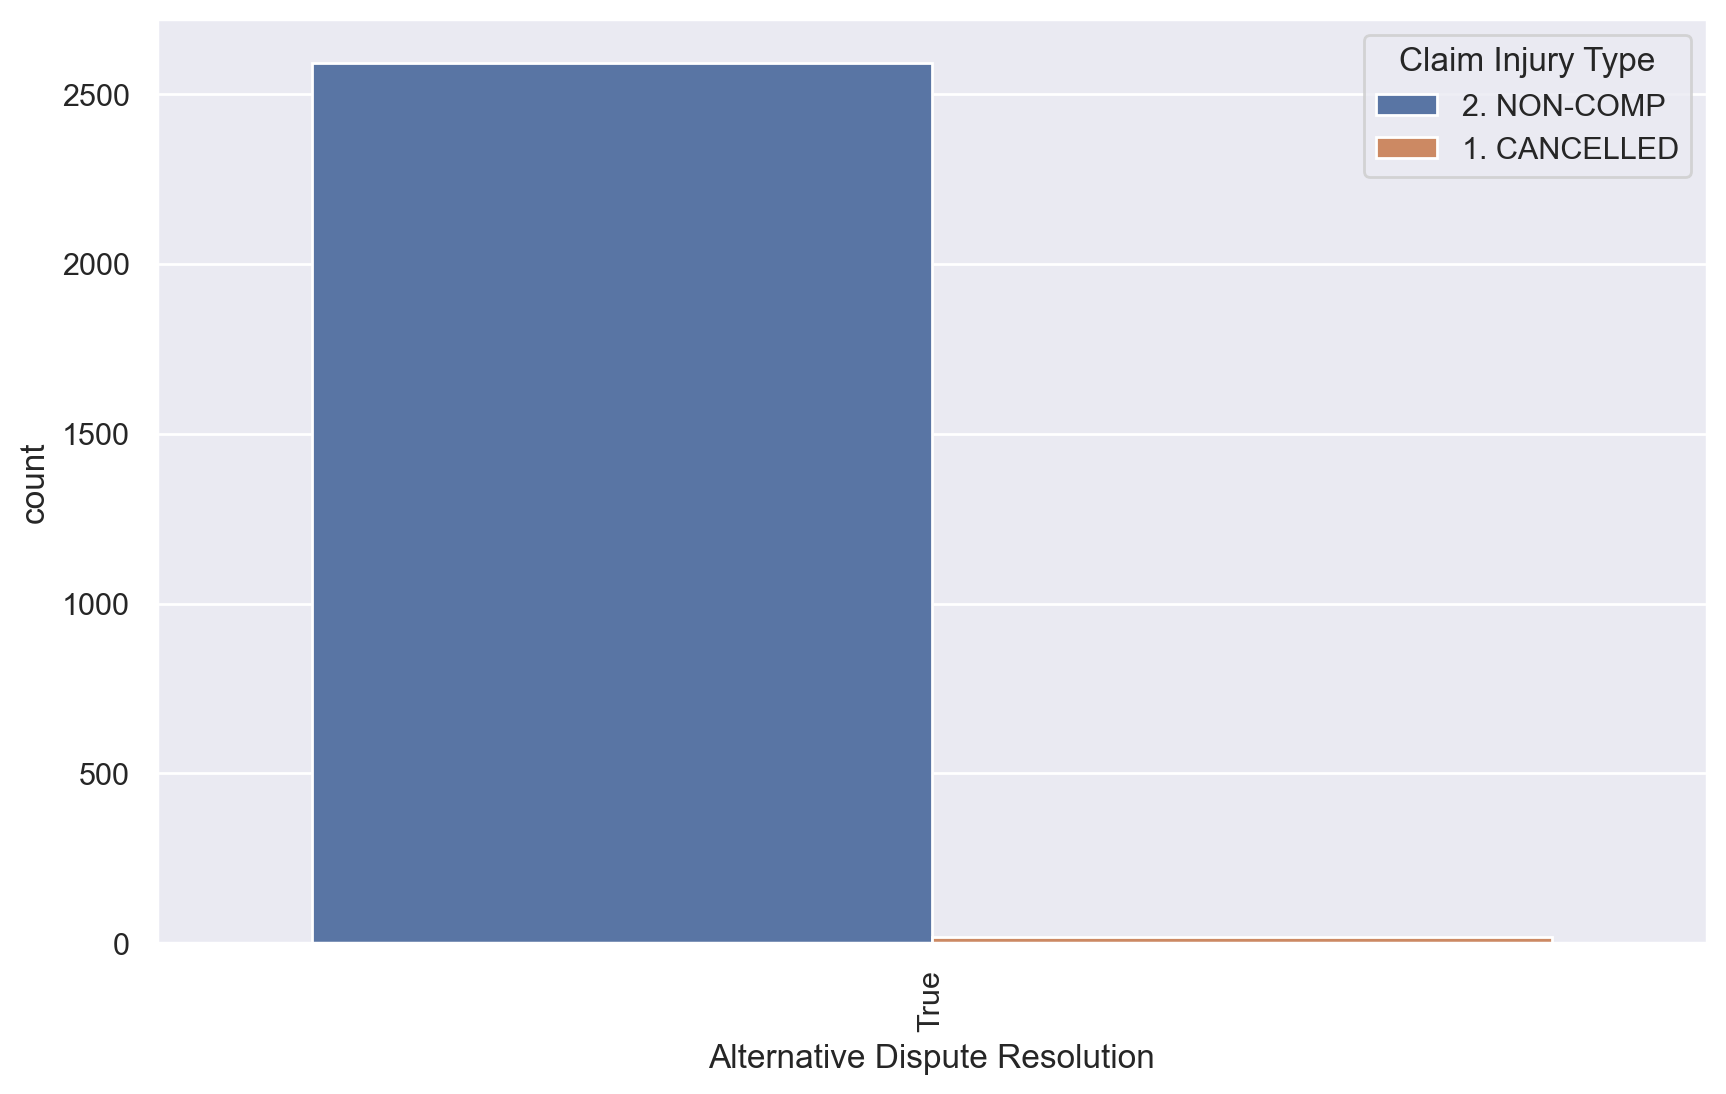

In [38]:
# df, restricted to 'Alternative Dispute Resolution' == True
filtered_df = df[df['Alternative Dispute Resolution'] == True]

# Countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Alternative Dispute Resolution', hue='Claim Injury Type', data=filtered_df)
plt.xticks(rotation=90)
plt.show()

Only two kinds of claims (NON-COMP and CANCELLED) were made by people who required an Alternative Dispute Resolution, the majority ending up being NON-COMP, just like the people who did not require an Alternative Dispute Resolution.

### Remarks for Comparing *Gender* by *Claim Injury Type*
Male and female have similar *Claim Injury Type* distributions, although there is a significant larger amount of mele in our sample.

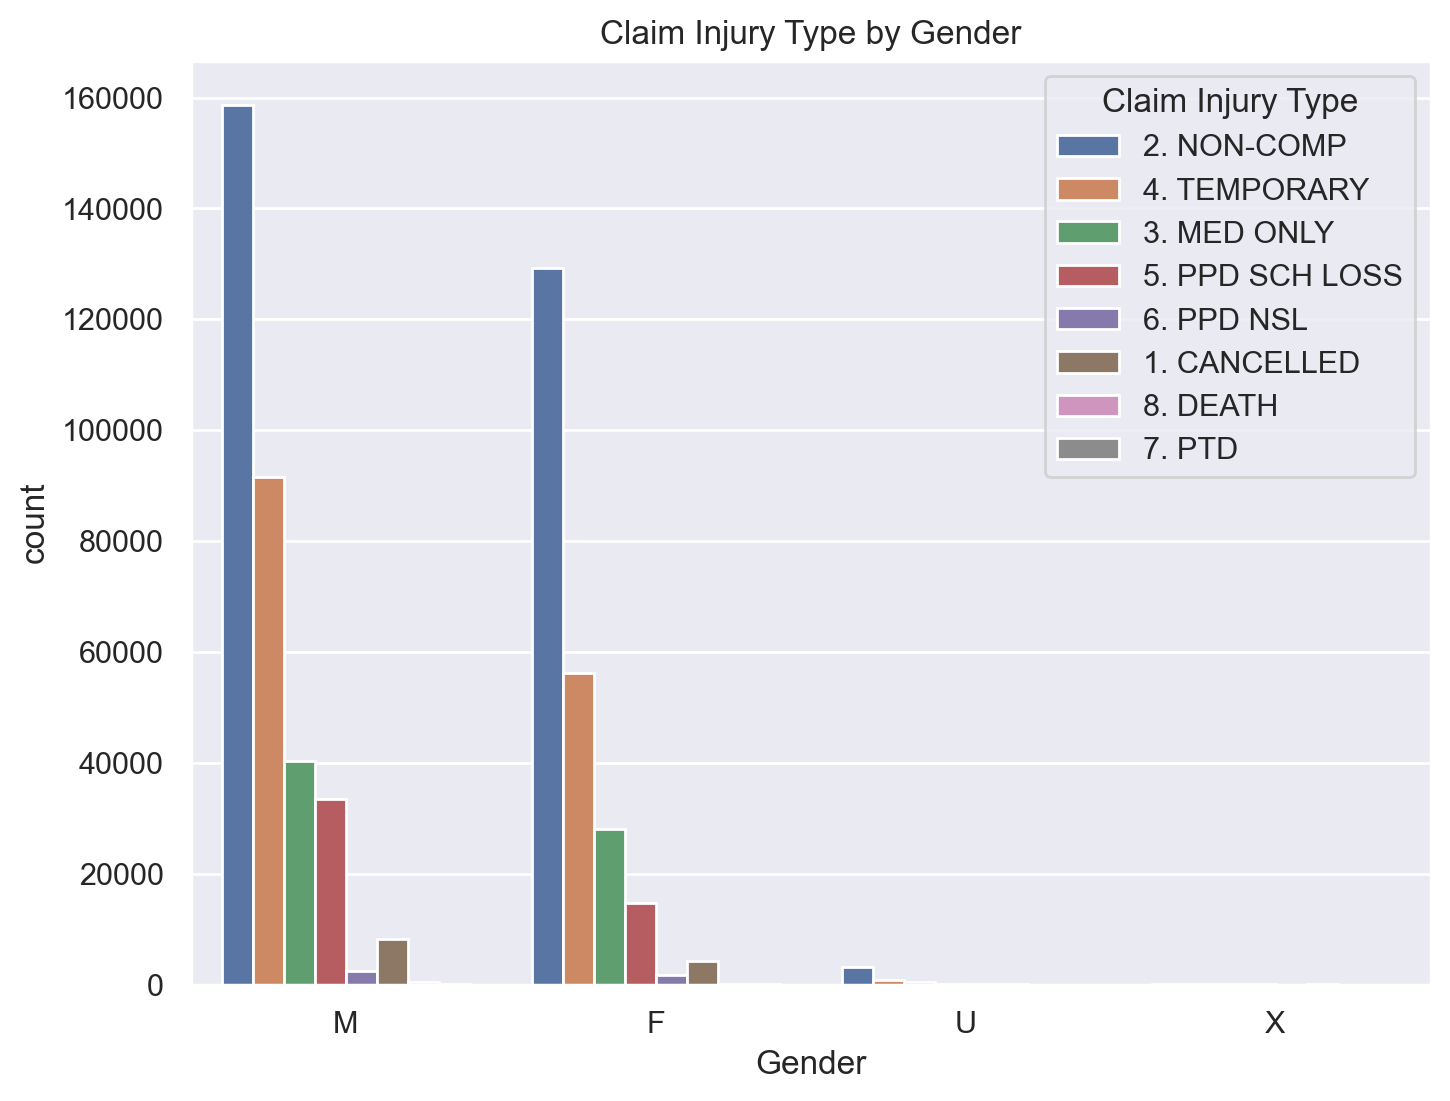

In [39]:
# Count plot for Gender and Claim Injury Type
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', hue='Claim Injury Type', data=df)
plt.title("Claim Injury Type by Gender")
plt.show()

Let's give a closer look at the right side of the graph (U and X):

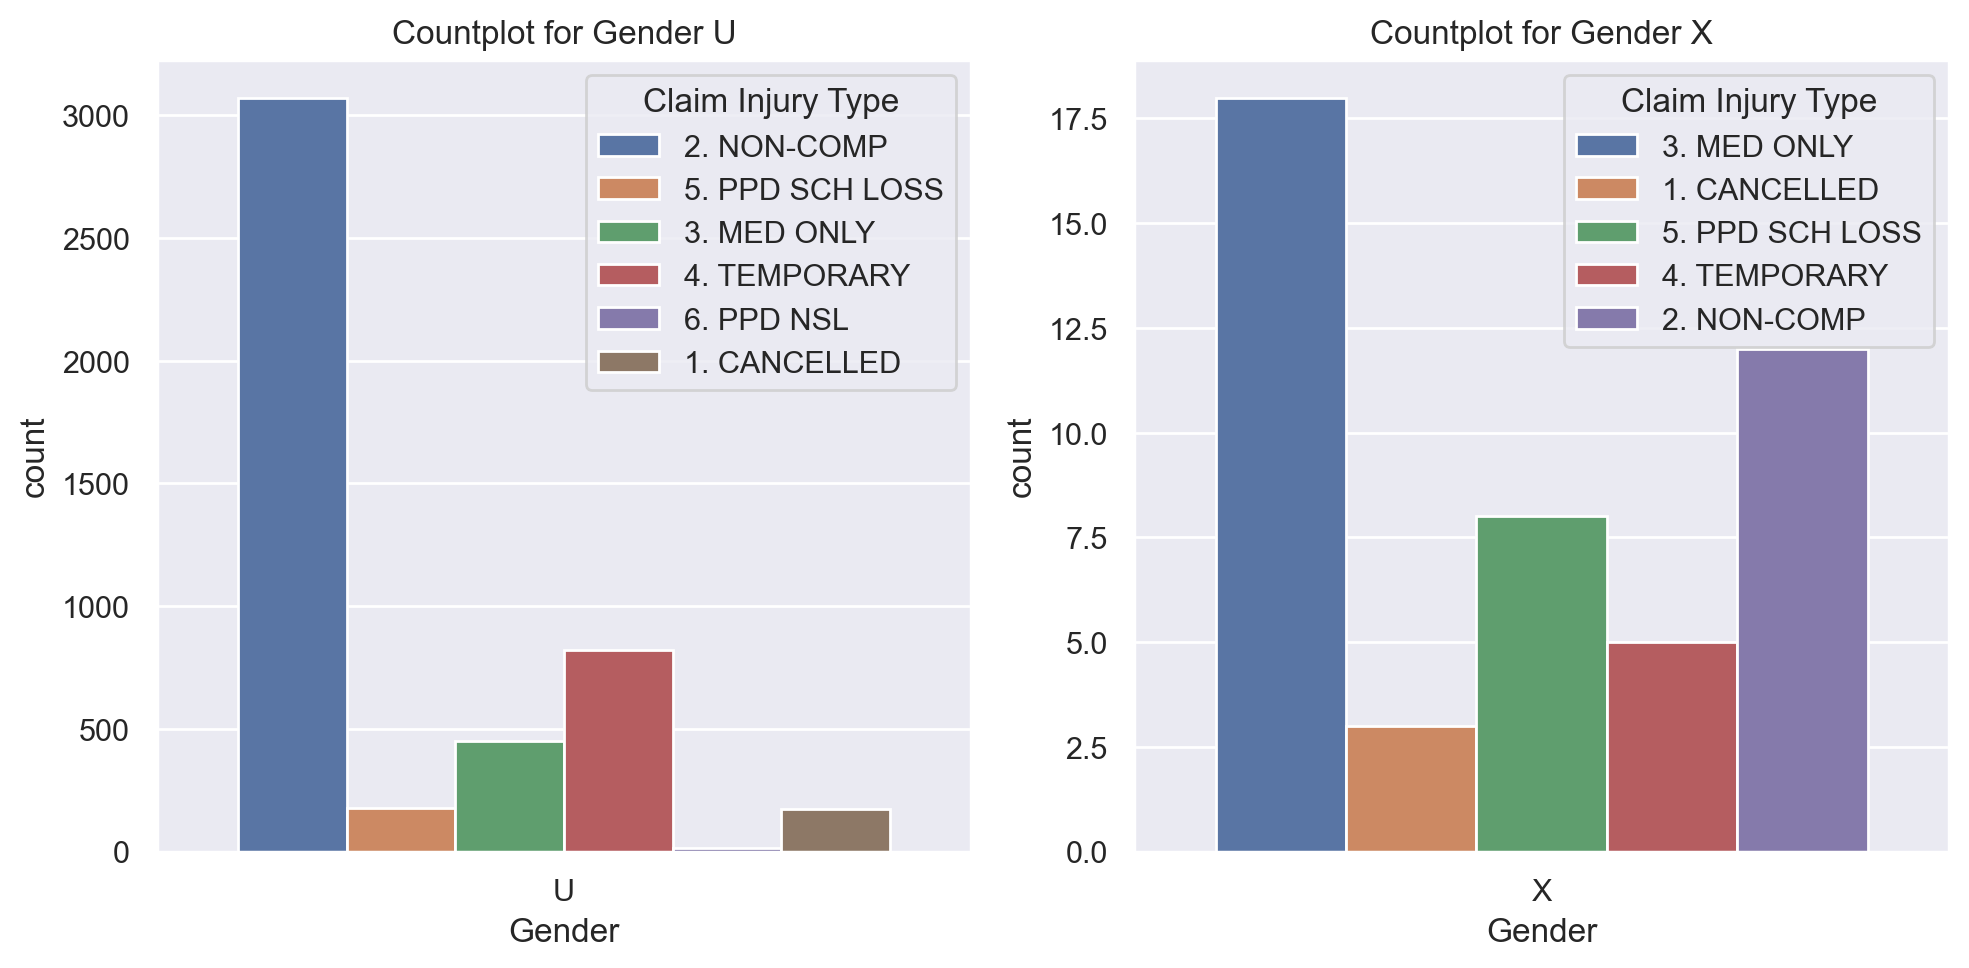

In [40]:
plt.figure(figsize=(10, 5))

# Gender U
plt.subplot(1, 2, 1) #first subplot
sns.countplot(x='Gender', hue='Claim Injury Type', data=df[df['Gender'] == "U"])
plt.title('Countplot for Gender U')

# Gender X
plt.subplot(1, 2, 2) #second sublot
sns.countplot(x='Gender', hue='Claim Injury Type', data=df[df['Gender'] == "X"])
plt.title('Countplot for Gender X')

plt.tight_layout()
plt.show()

X has values that are quite residual, fact shown by the count values in the y column.

### Remarks for Comparing *District Name* by *Claim Injury Type*
"NYC" has a drastically larger amount of every type of Injury claims, but it is relevant to point out the drastic amount of "NON-COMP".

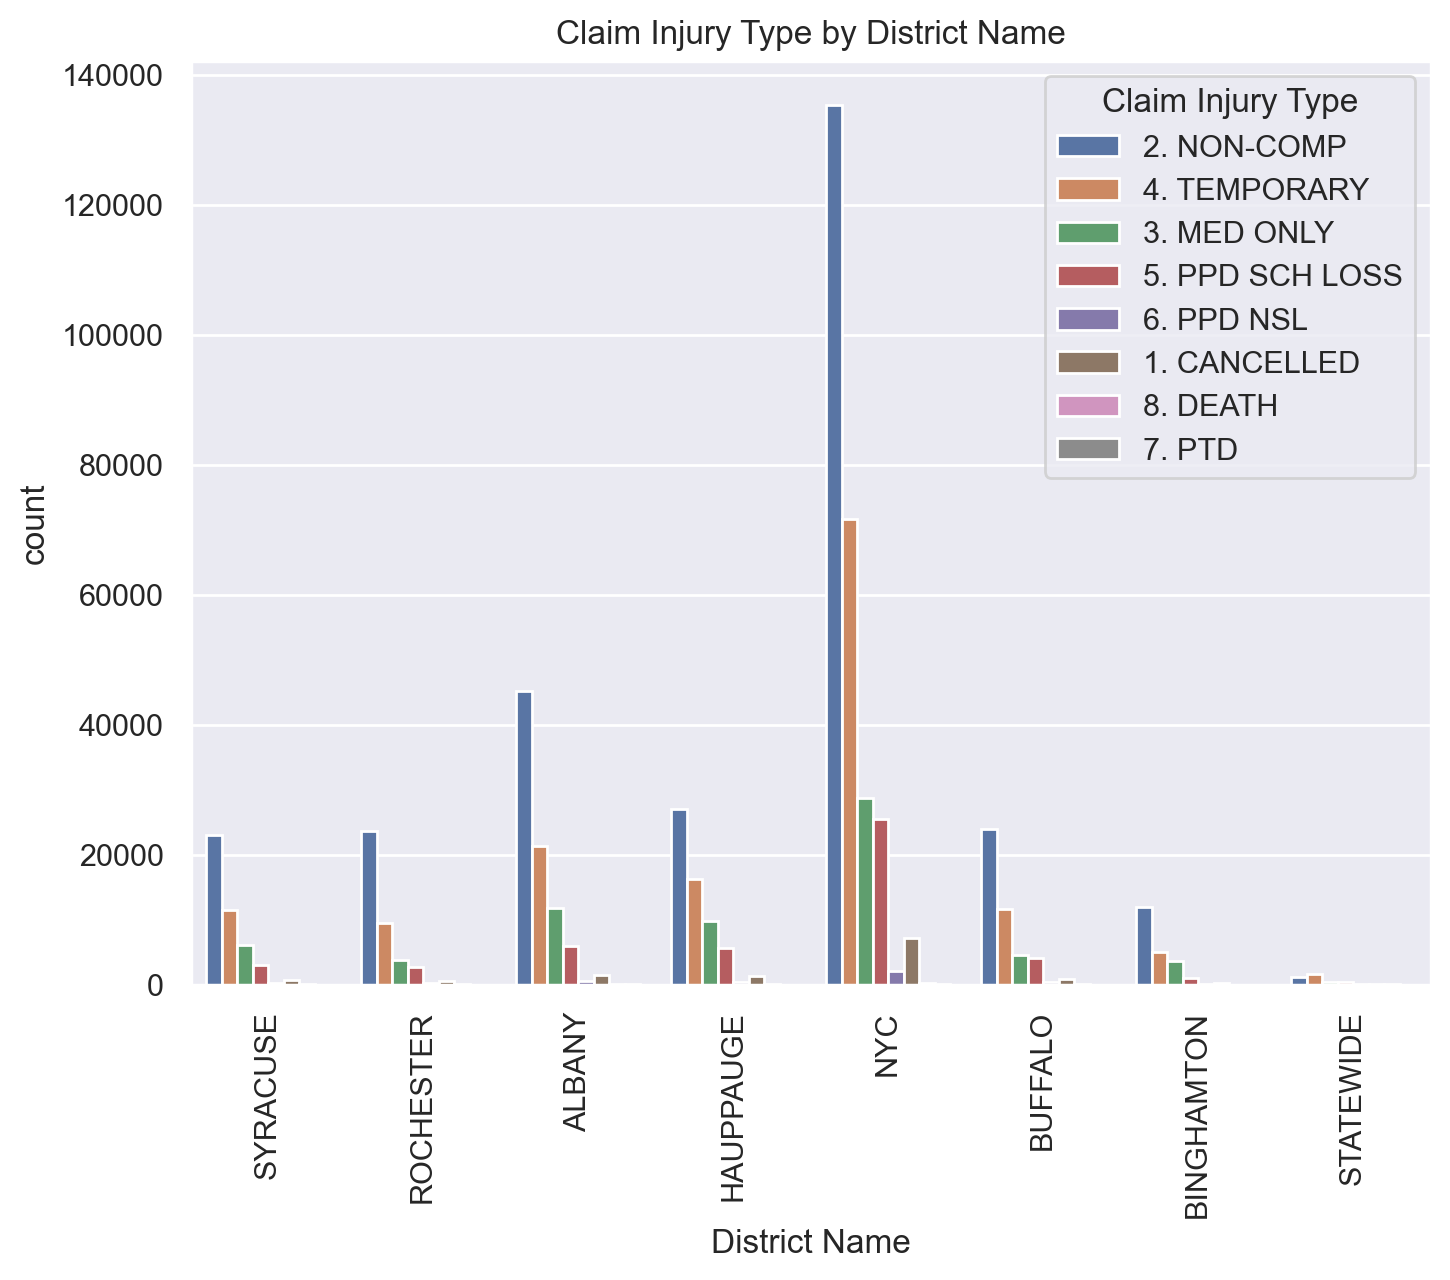

In [41]:
# Count plot for County of Injury and Claim Injury Type
plt.figure(figsize=(8, 6))
sns.countplot(x='District Name', hue='Claim Injury Type', data=df)
plt.title("Claim Injury Type by District Name")
plt.xticks(rotation=90)
plt.show()

## 3.2.3.3. Correlation between Categorical and Numerical Features
### Remarks
[High correlation]
- *Alternative Dispute Resolution* and *Carrier Name*
- *Assembley Date* and *C-2 Date*
- *Carrier Name* and *Carrier Type*
- *County of Injury* and *District Name*
- *County of Injury* and *Zip Code*
- *COVID 19 Indicator* and *WCIO Cause of Injury Description* 
- *COVID 19 Indicator* and *WCIO Nature of Injury Code*
- *COVID 19 Indicator* and *WCIO Nature of Injury Description*
- *COVID 19 Indicator* and *WCIO Part of Body Code*
- *COVID 19 Indicator* and *WCIO Part of Body Description*
- *District Name* and *Zip Code*
- *Industry Code* and *Industry Code Description*
- *Zip Code* and *Medical Fee Region*
- *WCIO Cause of Injury Code* and *WCIO Cause of Injury Description*
- *WCIO Nature of Injury Code* and *WCIO Nature of Injury Description*
- *WCIO Part of Body Code* and *WCIO Part of Body Description*

### Heatmap of the Categorical Features:

In [42]:
# Define the Cramér's V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

/var/folders/5m/jst39_tx1sbb3kmt0vyf82lw0000gq/T/ipykernel_609/3416987414.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = correlation_matrix.astype(float).applymap(lambda x: f"{x:.2f}" if abs(x) >= 0.7 else "")


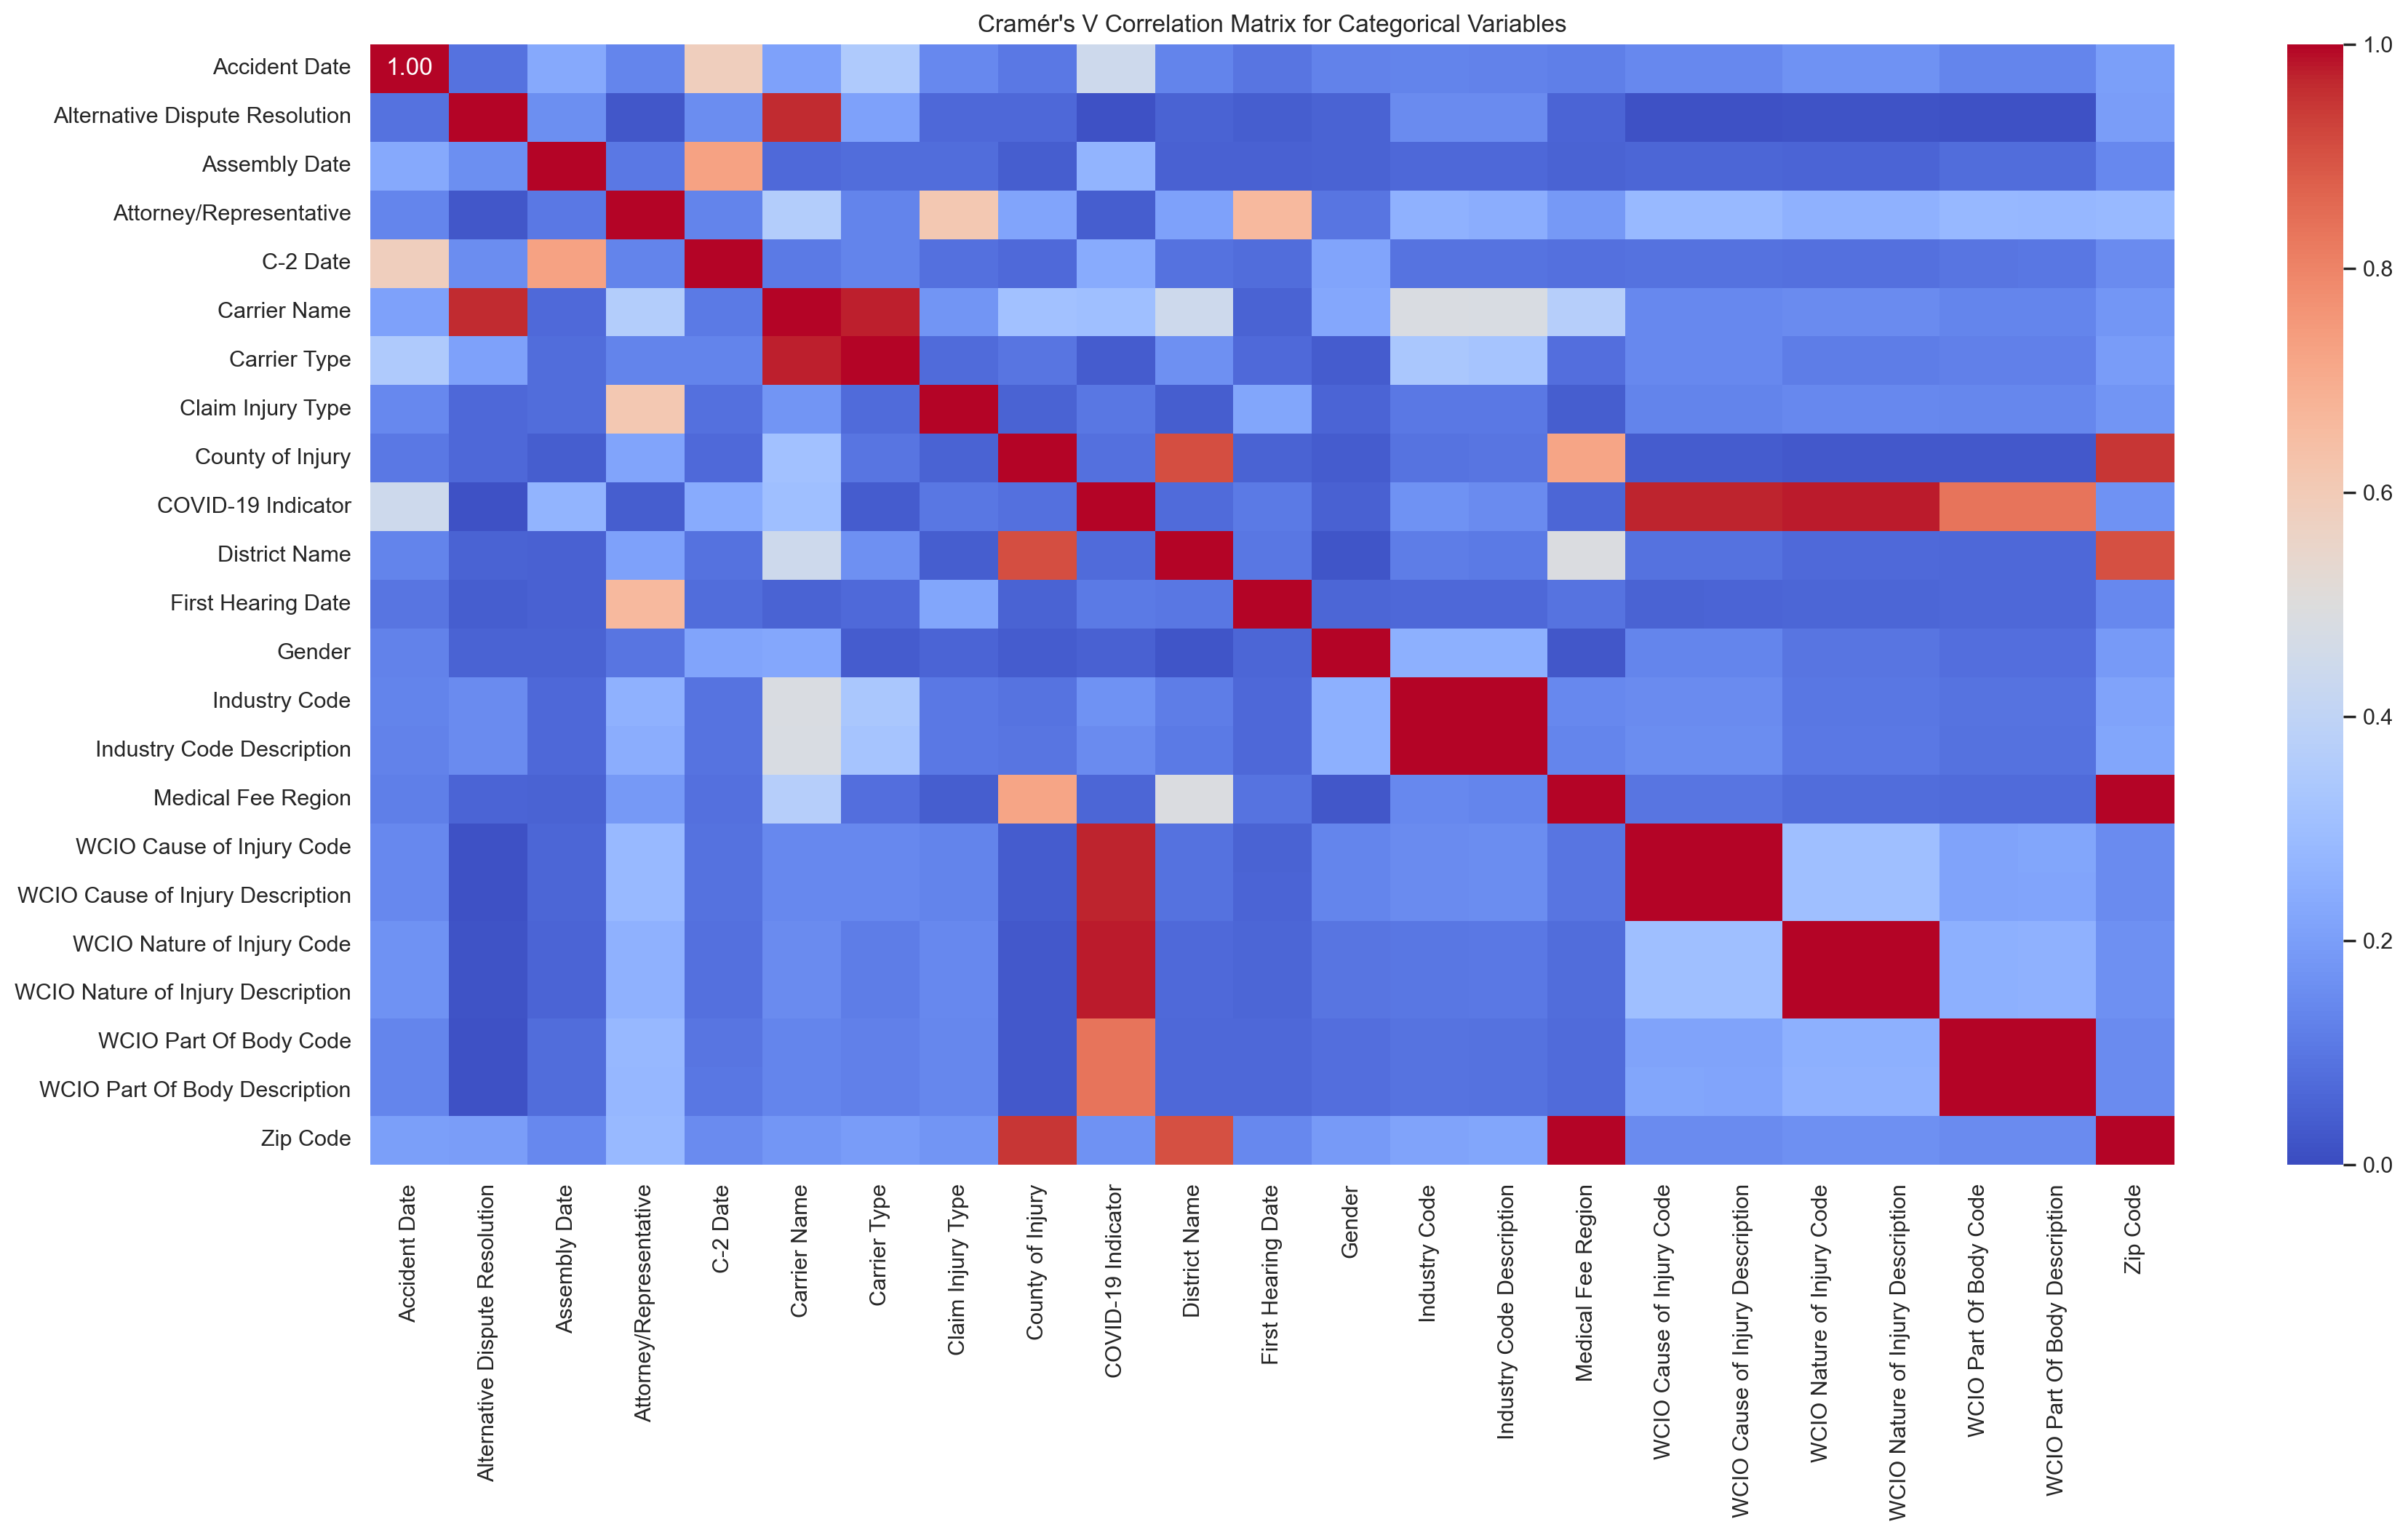

In [43]:
# Calculate the Cramér's V correlation matrix for the categorical variables
correlation_matrix = df[non_metric_features].apply(lambda x: df[non_metric_features].apply(lambda y: cramers_v(x, y)))

# Create an annotation matrix to display only values >= 0.7
annot_matrix = correlation_matrix.astype(float).applymap(lambda x: f"{x:.2f}" if abs(x) >= 0.7 else "")

# Plotting the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix.astype(float), annot=annot_matrix, cmap='coolwarm', vmin=0, vmax=1, fmt="")
plt.title("Cramér's V Correlation Matrix for Categorical Variables")
plt.show()

According to the Correlation Matrix and the ability to use the feature in the model, we decided to drop:
- *Carrier Name*
- *Covid Indicator* (after filling the missing values for other features)
- *Zip Code*
- *County of Injury*

## 3.3. Drop The Features: *Carrier Name*, *Zip Code* and *County of Injury*

In [44]:
df.drop("Carrier Name", axis=1, inplace=True)
df.drop("Zip Code", axis=1, inplace=True)
df.drop("County of Injury", axis=1, inplace=True)

# __`4. Data Processing　- Phase 2`__

## 4.1. Outliers
We deciced threshold as follows:
- *Birth Year*: We considered outliers all values that fall outside of the interval **[1920 ; 2022]** as the visualization of the feature showed split outliers from 1920 bellow.
- *Age at Injury*: We considered outliers all values that fall outside of the interval **[14 ; 78]** since according to the US law, the general minimum age to work is 14. Moreover, although the retiring age is usually between 67 and 68 years old, it is not mandatory to retire. Thus, it is possible to have work injuries after retiring age, even though it is possible to work until death, it is unlikely. So, we consider that all values that surpass the average life expectancy in the US (77,43 yo) are outliers.
- *Average Weekly Wage*: We considered outliers all values that fall outside of the interval **[0 ; 6500]** as the visualization of the feature showed split outliers from 6500 above.

We converted the outliers to NAN and treat them as missing values, so that these will not impact negatively the predictive model.

### Treat outliers in *Birth Year*

<Axes: xlabel='Birth Year'>

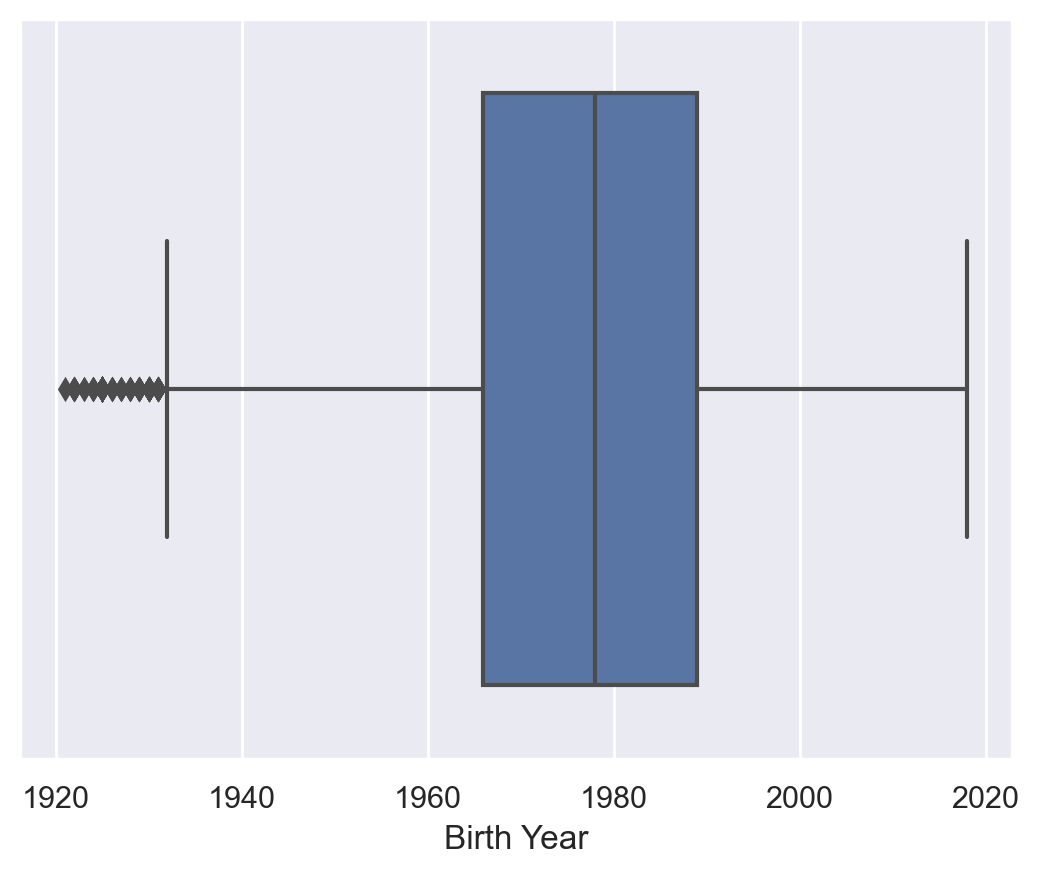

In [45]:
birth_year = df.loc[df['Birth Year'] > 1920]
df['Birth Year'] = df['Birth Year'].where(df['Birth Year'] <= 1920, np.nan)

sns.boxplot(x=birth_year['Birth Year'])

### Treat outliers in *Age at Injury*

<Axes: xlabel='Age at Injury'>

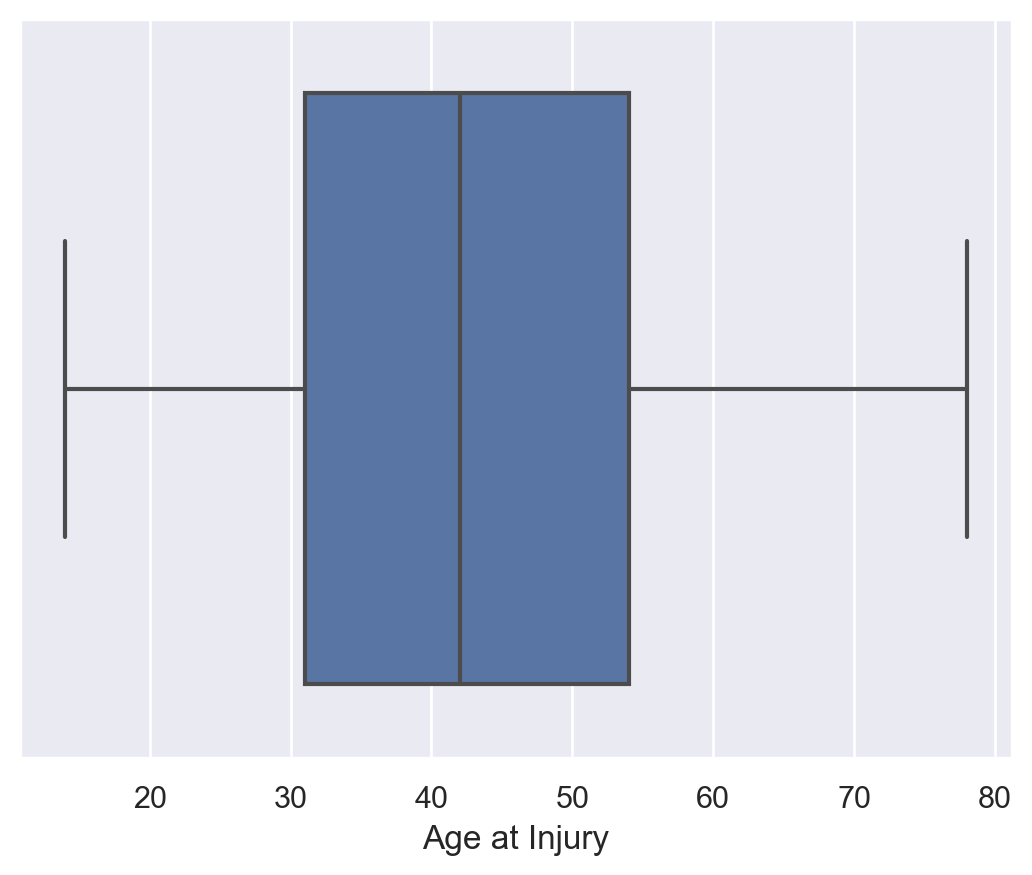

In [46]:
age_at_injury = df.loc[(df['Age at Injury'] >= 14) & (df['Age at Injury']<=78)]
df['Age at Injury'] = df['Age at Injury'].where((df['Age at Injury'] >= 14) & (df['Age at Injury']<=78), np.nan)

sns.boxplot(x=age_at_injury['Age at Injury'])

### Treat outliers in *Average Weekly Wage*

<Axes: xlabel='Average Weekly Wage'>

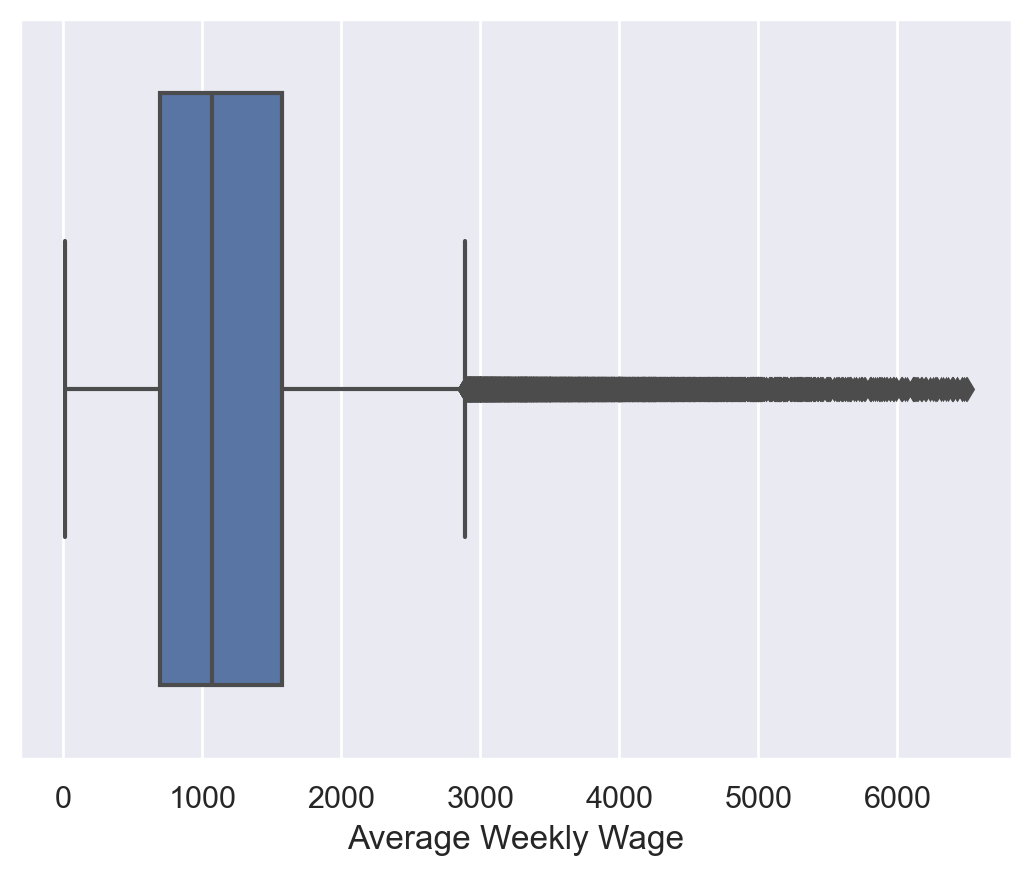

In [47]:
average_weekly_wage = df.loc[(df['Average Weekly Wage'] > 0) & (df['Average Weekly Wage']<=6500)] 
df['Average Weekly Wage'] = df['Average Weekly Wage'].where((df['Average Weekly Wage'] >= 0) & (df['Average Weekly Wage']<=7500), np.nan)

sns.boxplot(x=average_weekly_wage['Average Weekly Wage'])

First, we checked the percentage of values "0" in *Average Weekly Wage*.

In [48]:
# 574026 is the total number of values in the feature Average Weekly Wage and 28651 is the number of missing values
all_values_wage = 574026-28651 
null_wage = df[df['Average Weekly Wage']==0]['Average Weekly Wage'].value_counts().iloc[0]

print( f'The Percentage of "0" values in the feature Average Weekly Wage is {round((null_wage/all_values_wage)*100,2)}%')

The Percentage of "0" values in the feature Average Weekly Wage is 61.51%


According to american law, people born in 1954 or before can retire at 66 yo while those born during/after 1955 can retire at 67.

In [49]:
# Define variable "retirees" of people who are 66 years old or more that made a claim
retirees = ((df['Birth Year']<=1954) & (df['Assembly Date']>='2020-01-01') & (df['Average Weekly Wage']==0))
retirees_condition = df[retirees]

#people with 67 that made a claim
#print(df[(df['Birth Year']==1955) & (df['Assembly Date']>'2022-01-01') & (df['Average Weekly Wage']==0)]['Average Weekly Wage'].value_counts().iloc[0])
##since there are no claims with 1955 as birth year, we will leave the line commented

# Print the number of people that might have retired due to age
print(retirees_condition['Average Weekly Wage'].value_counts().iloc[0]) 

16232


In [50]:
#Print the number of people that might have retired due to age as a percentage of total 0 values
print(f"Retirees explain {round((retirees_condition['Average Weekly Wage'].value_counts().iloc[0]/null_wage)*100,2)}% of null values in Average Weekly Wage")

# U.S. unemployment rate for 2020, 2021 and 2022 was 8.06%, 5.35% and 3.65%, respectively
# Create the variables for the number of people that might have lost their jobs
unemployed_2020 = ((df['Assembly Date']>='2020-01-01') & (df['Assembly Date']<'2021-01-01') & (df['Average Weekly Wage']==0))
unemployed_2021 = ((df['Assembly Date']>='2021-01-01') & (df['Assembly Date']<'2022-01-01') & (df['Average Weekly Wage']==0))
unemployed_2022 = ((df['Assembly Date']>='2022-01-01') & (df['Average Weekly Wage']==0))

# Print the number of people that might have lost jobs as a percentage of total 0 values
print(f"Unemployment explains {round((df[unemployed_2020]['Average Weekly Wage'].value_counts().iloc[0]*(8.06/100))/null_wage*100+(df[unemployed_2021]['Average Weekly Wage'].value_counts().iloc[0]*(5.35/100))/null_wage*100+(df[unemployed_2022]['Average Weekly Wage'].value_counts().iloc[0]*(3.65/100))/null_wage*100,2)}% of null values in Average Weekly Wage")

# Print the number of people that we could not explain as a percentage of total 0 values
print(f"{61.51 - (round((retirees_condition['Average Weekly Wage'].value_counts().iloc[0]/null_wage)*100, 2)) - round((df[unemployed_2020]['Average Weekly Wage'].value_counts().iloc[0]*(8.06/100))/null_wage*100+(df[unemployed_2021]['Average Weekly Wage'].value_counts().iloc[0]*(5.35/100))/null_wage*100+(df[unemployed_2022]['Average Weekly Wage'].value_counts().iloc[0]*(3.65/100))/null_wage*100,2)}% of null values in Average Weekly Wage are unexplained")

Retirees explain 4.84% of null values in Average Weekly Wage
Unemployment explains 5.52% of null values in Average Weekly Wage
51.150000000000006% of null values in Average Weekly Wage are unexplained


Thus, we will take the **unexplained '0' values in 'Average Weekly Wage' as outliers**

In [51]:
df['Professional Status'] = np.where(retirees, 'Retiree', np.nan)

unemployed_2020_sample = df[unemployed_2020].sample(frac=0.0806, random_state=42).index
df.loc[unemployed_2020_sample, 'Professional Status'] = 'Unemployed'

unemployed_2021_sample = df[unemployed_2021].sample(frac=0.0535, random_state=42).index
df.loc[unemployed_2021_sample, 'Professional Status'] = 'Unemployed'

unemployed_2022_sample = df[unemployed_2022].sample(frac=0.0365, random_state=42).index
df.loc[unemployed_2022_sample, 'Professional Status'] = 'Unemployed'

employed_sample = df[df['Average Weekly Wage']!=0].index
df.loc[employed_sample, 'Professional Status'] = 'Employed'

df['Professional Status'].fillna('Missing', inplace=True)

df.loc[df['Professional Status'] == 'Missing', 'Average Weekly Wage'] = np.nan


# Also for the test dataset
retirees_test = ((test['Birth Year']<=1954) & (test['Assembly Date']>='2020-01-01') & (test['Average Weekly Wage']==0))

unemployed_2020_test = ((test['Assembly Date']>='2020-01-01') & (test['Assembly Date']<'2021-01-01') & (test['Average Weekly Wage']==0))
unemployed_2021_test = ((test['Assembly Date']>='2021-01-01') & (test['Assembly Date']<'2022-01-01') & (test['Average Weekly Wage']==0))
unemployed_2022_test = ((test['Assembly Date']>='2022-01-01') & (test['Average Weekly Wage']==0))

test['Professional Status'] = np.where(retirees_test, 'Retiree', np.nan)

unemployed_2020_test_sample = test[unemployed_2020_test].sample(frac=0.0806, random_state=42).index
test.loc[unemployed_2020_test_sample, 'Professional Status'] = 'Unemployed'

unemployed_2021_test_sample = test[unemployed_2021_test].sample(frac=0.0535, random_state=42).index
test.loc[unemployed_2021_test_sample, 'Professional Status'] = 'Unemployed'

unemployed_2022_test_sample = test[unemployed_2022_test].sample(frac=0.0365, random_state=42).index
test.loc[unemployed_2022_test_sample, 'Professional Status'] = 'Unemployed'

employed_test_sample = test[test['Average Weekly Wage']!=0].index
test.loc[employed_test_sample, 'Professional Status'] = 'Employed'

test['Professional Status'].fillna('Missing', inplace=True)

test.loc[test['Professional Status'] == 'Missing', 'Average Weekly Wage'] = np.nan

In [52]:
# Change Professional Status to Employed, after filtering the outliers
df.loc[df['Professional Status'] == 'Missing', 'Professional Status'] = 'Employed'

# Also for the test dataset
test.loc[test['Professional Status'] == 'Missing', 'Professional Status'] = 'Employed'

Compare *Average Weekly Wage* by *Claim Injury Type* by *Claim Injury Type*

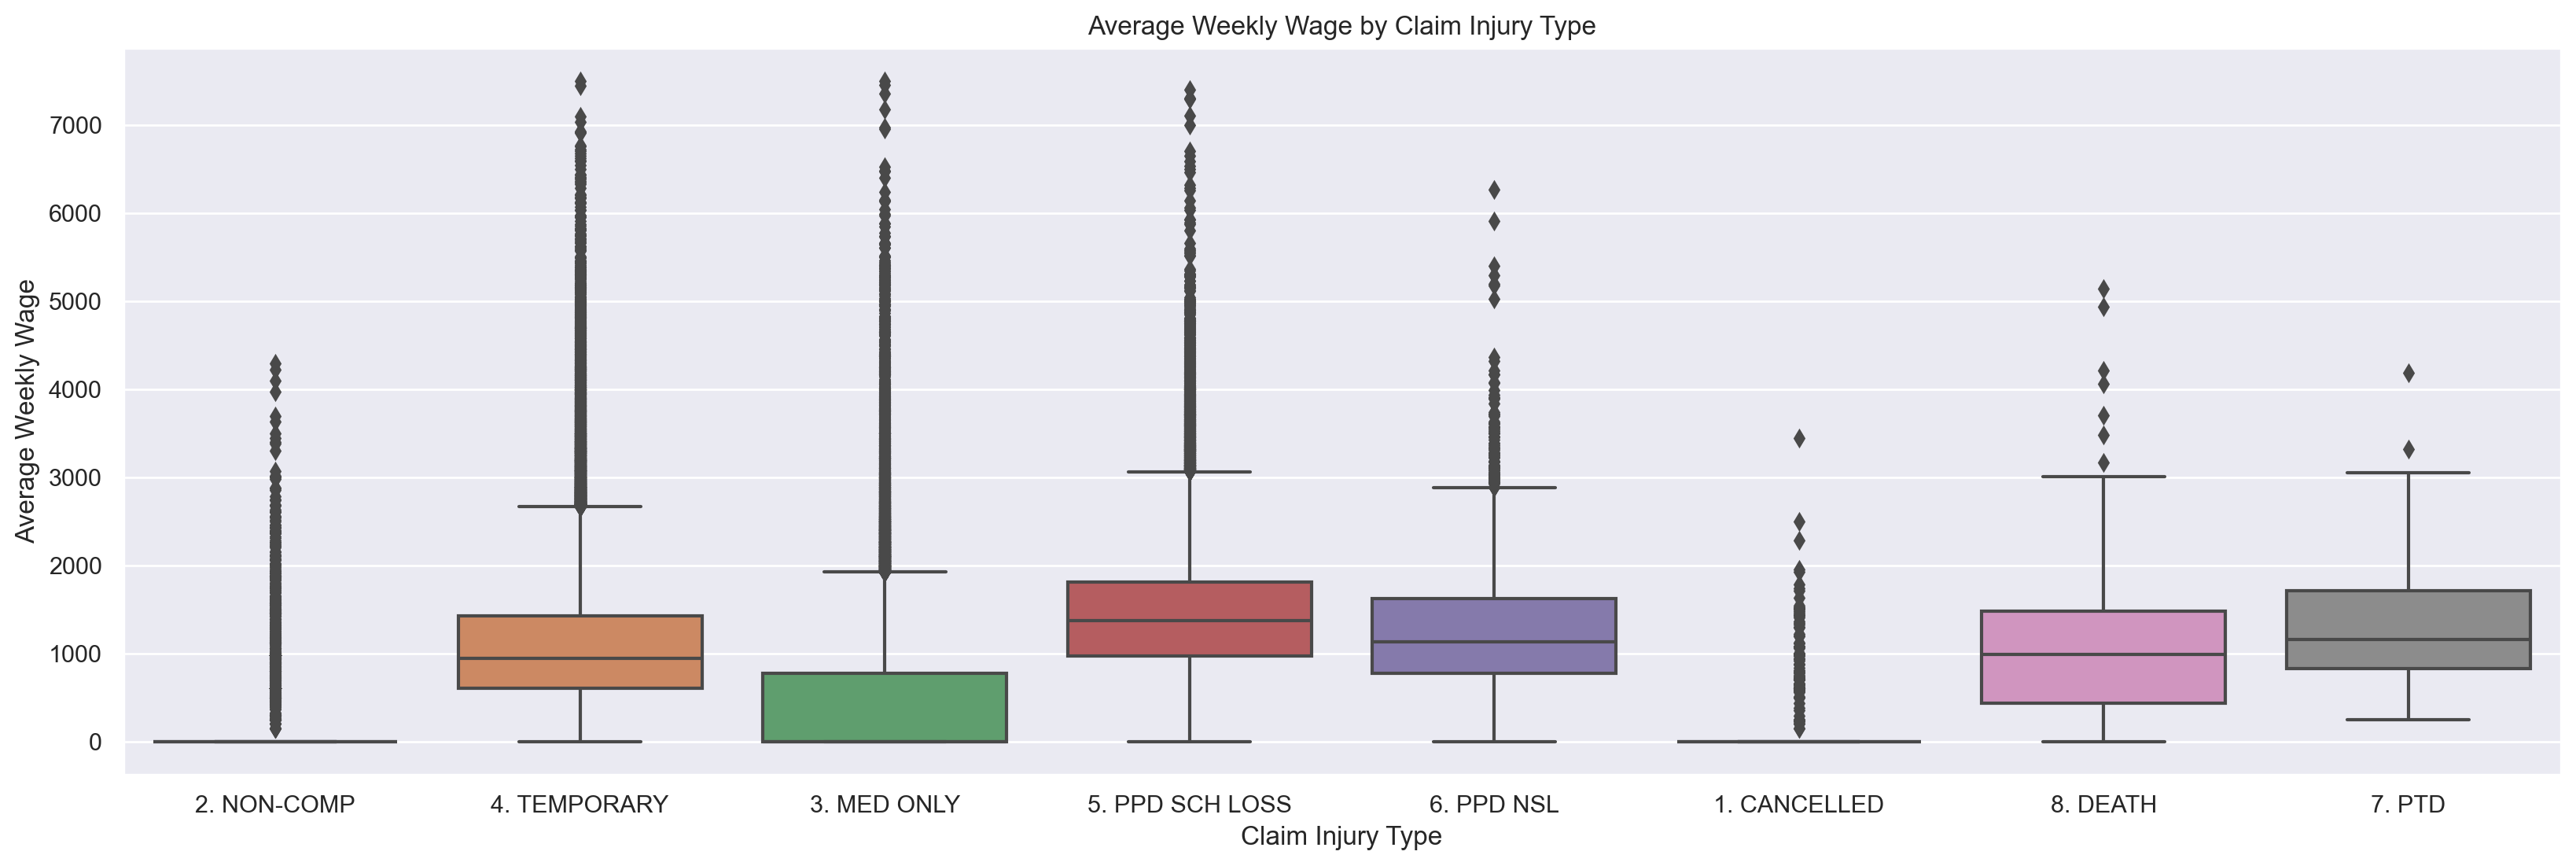

In [53]:
for feature in ["Average Weekly Wage"]:
    plt.figure(figsize=(20, 6))
    sns.boxplot(x='Claim Injury Type', y=feature, data=df)
    plt.title(f"{feature} by Claim Injury Type")
    plt.show()

Remarks:
- **Average Weekly Wage by Claim Injury Type**: It is interesting that "PPD SCH LOSS" has the highest median and both "NON_COMP" and "CANCELLED" have the lowest. It is possibly insinuating that individuals with a higher payout get injury claims that are more complex or serious. Potentially because they can afford legal representatives, since we drew a similar conclusion.

## 4.2. Re-Treat Missing values

In [54]:
# Check the missing values after converting the outliers to NAN
df.isna().sum()

Accident Date                          3689
Age at Injury                          6780
Alternative Dispute Resolution            0
Assembly Date                             0
Attorney/Representative                   0
Average Weekly Wage                   28758
Birth Year                           548795
C-2 Date                              14560
Carrier Type                              0
Claim Injury Type                         0
COVID-19 Indicator                        0
District Name                             0
First Hearing Date                        0
Gender                                    0
Industry Code                          9958
Industry Code Description              9958
Medical Fee Region                        0
WCIO Cause of Injury Code             15640
WCIO Cause of Injury Description      15640
WCIO Nature of Injury Code            15657
WCIO Nature of Injury Description     15657
WCIO Part Of Body Code                17082
WCIO Part Of Body Description   

In [55]:
# Change it to percentage 
(df.isna().sum()/len(df))*100

Accident Date                         0.642654
Age at Injury                         1.181131
Alternative Dispute Resolution        0.000000
Assembly Date                         0.000000
Attorney/Representative               0.000000
Average Weekly Wage                   5.009878
Birth Year                           95.604554
C-2 Date                              2.536470
Carrier Type                          0.000000
Claim Injury Type                     0.000000
COVID-19 Indicator                    0.000000
District Name                         0.000000
First Hearing Date                    0.000000
Gender                                0.000000
Industry Code                         1.734765
Industry Code Description             1.734765
Medical Fee Region                    0.000000
WCIO Cause of Injury Code             2.724615
WCIO Cause of Injury Description      2.724615
WCIO Nature of Injury Code            2.727577
WCIO Nature of Injury Description     2.727577
WCIO Part Of 

We decided to drop the feature *Birth Year* a few steps down since it has the huge amount of missing values (95% of values).<br>

## 4.3. Anomalies

## 4.3.1. Between *WCIO Cause of Injury Code* and *WCIO Cause of Injury Description*

We searched for duplicated descriptions for different codes and duplicated codes for different descriptions in *WCIO Cause of Injury Description* and *WCIO Cause of Injury Code*.

In [56]:
# Group by the WCIO Cause of Injury Description and count unique WCIO Cause of Injury Codes
duplicates_cause_injury_descriptions = df.groupby('WCIO Cause of Injury Description')['WCIO Cause of Injury Code'].nunique()
# Group by the WCIO Cause of Injury Code and count unique WCIO Cause of Injury Descriptions
duplicates_cause_injury_codes = df.groupby('WCIO Cause of Injury Code')['WCIO Cause of Injury Description'].nunique()

# Filter for descriptions associated with more than one code 
duplicates_cause_injury_descriptions = duplicates_cause_injury_descriptions[duplicates_cause_injury_descriptions > 1]
# Filter for codes associated with more than one description
duplicates_cause_injury_codes = duplicates_cause_injury_codes[duplicates_cause_injury_codes > 1]

# Print the results
print(duplicates_cause_injury_descriptions)
print(duplicates_cause_injury_codes)

WCIO Cause of Injury Description
OBJECT BEING LIFTED OR HANDLED    3
REPETITIVE MOTION                 2
Name: WCIO Cause of Injury Code, dtype: int64
Series([], Name: WCIO Cause of Injury Description, dtype: int64)


The descriptions above have different codes for the same description. There are no cases in which the same code refers to different descriptions. Below we want to count the number of entries of each code for the same description.

In [57]:
# Count the number of different WCIO Cause of Injury Codes for the same WCIO Cause of Injury Description
print(df[df['WCIO Cause of Injury Description'] == 'OBJECT BEING LIFTED OR HANDLED']['WCIO Cause of Injury Code'].value_counts())
print(df[df['WCIO Cause of Injury Description'] == 'REPETITIVE MOTION']['WCIO Cause of Injury Code'].value_counts())

WCIO Cause of Injury Code
79.0    12371
17.0    10148
66.0     2772
Name: count, dtype: int64
WCIO Cause of Injury Code
97.0    11735
94.0      705
Name: count, dtype: int64


In [58]:
# Since 79 was the most used code for the description, we replaced the other codes with it
df.loc[df['WCIO Cause of Injury Description'] == 'OBJECT BEING LIFTED OR HANDLED', 'WCIO Cause of Injury Code'] = 79
test.loc[test['WCIO Cause of Injury Description'] == 'OBJECT BEING LIFTED OR HANDLED', 'WCIO Cause of Injury Code'] = 79

# Since 97 was the most used code for the description, we replaced the other code with it
df.loc[df['WCIO Cause of Injury Description'] == 'REPETITIVE MOTION', 'WCIO Cause of Injury Code'] = 97
test.loc[test['WCIO Cause of Injury Description'] == 'REPETITIVE MOTION', 'WCIO Cause of Injury Code'] = 97

# Check if the replacement was successful 
print(df[df['WCIO Cause of Injury Description'] == 'OBJECT BEING LIFTED OR HANDLED']['WCIO Cause of Injury Code'].value_counts())
print(df[df['WCIO Cause of Injury Description'] == 'REPETITIVE MOTION']['WCIO Cause of Injury Code'].value_counts())

WCIO Cause of Injury Code
79    25291
Name: count, dtype: int64
WCIO Cause of Injury Code
97    12440
Name: count, dtype: int64


## 4.3.2. Between *WCIO Part Of Body Code* and *WCIO Part Of Body Description*

We searched for duplicated descriptions for different codes and duplicated codes for different descriptions of *WCIO Part Of Body Description* and *WCIO Part Of Body Code*.

In [59]:
# Group by the WCIO Part of Body Description and count unique WCIO Part of Body Codes
duplicates_part_of_body_descriptions = df.groupby('WCIO Part Of Body Description')['WCIO Part Of Body Code'].nunique()
# Group by the WCIO Part of Body Code and count unique WCIO Part of Body Descriptions
duplicates_part_of_body_code = df.groupby('WCIO Part Of Body Code')['WCIO Part Of Body Description'].nunique()

# Filter for descriptions associated with more than one code
duplicates_with_multiple_descriptions = duplicates_part_of_body_descriptions[duplicates_part_of_body_descriptions > 1]
# Filter for codes associated with more than one description
duplicates_with_multiple_codes = duplicates_part_of_body_code[duplicates_part_of_body_code > 1]

# Print the results
print(duplicates_with_multiple_descriptions)
print(duplicates_with_multiple_codes)

WCIO Part Of Body Description
DISC           2
SOFT TISSUE    2
SPINAL CORD    2
Name: WCIO Part Of Body Code, dtype: int64
Series([], Name: WCIO Part Of Body Description, dtype: int64)


The descriptions above have different codes for the same description. There are no cases in which the same code refers to different descriptions. Below we want to count the number of entries of each code for the same description.

In [60]:
# Count the number of different WCIO Cause of Injury Codes for the same WCIO Cause of Injury Description
print(df[df['WCIO Part Of Body Description'] == 'DISC']['WCIO Part Of Body Code'].value_counts())
print(df[df['WCIO Part Of Body Description'] == 'SOFT TISSUE']['WCIO Part Of Body Code'].value_counts())
print(df[df['WCIO Part Of Body Description'] == 'SPINAL CORD']['WCIO Part Of Body Code'].value_counts())

WCIO Part Of Body Code
43.0    1893
22.0    1103
Name: count, dtype: int64
WCIO Part Of Body Code
18.0    13765
25.0     5938
Name: count, dtype: int64
WCIO Part Of Body Code
23.0    477
47.0    402
Name: count, dtype: int64


In [61]:
# Since 43 was the most used code for the description, we replaced the other codes with it
df.loc[df['WCIO Part Of Body Description'] == 'DISC', 'WCIO Part Of Body Code'] = 43
test.loc[test['WCIO Part Of Body Description'] == 'DISC', 'WCIO Part Of Body Code'] = 43

# Since 18 was the most used code for the description, we replaced the other codes with it
df.loc[df['WCIO Part Of Body Description'] == 'SOFT TISSUE', 'WCIO Part Of Body Code'] = 18
test.loc[test['WCIO Part Of Body Description'] == 'SOFT TISSUE', 'WCIO Part Of Body Code'] = 18

# Since 23 was the most used code for the description, we replaced the other codes with it
df.loc[df['WCIO Part Of Body Description'] == 'SPINAL CORD', 'WCIO Part Of Body Code'] = 23
test.loc[test['WCIO Part Of Body Description'] == 'SPINAL CORD', 'WCIO Part Of Body Code'] = 23

# checking if the replacement was successful 
print(df[df['WCIO Part Of Body Description'] == 'DISC']['WCIO Part Of Body Code'].value_counts())
print(df[df['WCIO Part Of Body Description'] == 'SOFT TISSUE']['WCIO Part Of Body Code'].value_counts())
print(df[df['WCIO Part Of Body Description'] == 'SPINAL CORD']['WCIO Part Of Body Code'].value_counts())

WCIO Part Of Body Code
43    2996
Name: count, dtype: int64
WCIO Part Of Body Code
18    19703
Name: count, dtype: int64
WCIO Part Of Body Code
23    879
Name: count, dtype: int64


## 4.3.3. Between *Industry Code* and *Industry Code Description*

We searched for duplicated descriptions for different codes and duplicated codes for different descriptions of *Industry Code Description* and *Industry Code*.

In [62]:
# Group by the Industry Code Description and count unique Industry Code Codes
duplicates_industry_code_descriptions = df.groupby('Industry Code Description')['Industry Code'].nunique()
# Group by the Industry Code and count unique Industry Code Descriptions
duplicates_industry_code_codes = df.groupby('Industry Code')['Industry Code Description'].nunique()

# Filter for descriptions associated with more than one code
duplicates_industry_code_descriptions = duplicates_industry_code_descriptions[duplicates_industry_code_descriptions > 1]
# Filter for codes associated with more than one description
duplicates_industry_code = duplicates_industry_code_codes[duplicates_industry_code_codes > 1]

# Print the results
print(duplicates_industry_code_descriptions)
print(duplicates_industry_code)

Industry Code Description
MANUFACTURING                     3
RETAIL TRADE                      2
TRANSPORTATION AND WAREHOUSING    2
Name: Industry Code, dtype: int64
Series([], Name: Industry Code Description, dtype: int64)


The descriptions above have different codes for the same description. There are no cases in which the same code refers to different descriptions. Below we want to count the number of entries of each code for the same description.

In [63]:
# Count the number of different Industry Code Codes for the same Industry Code Description
print(df[df['Industry Code Description'] == 'RETAIL TRADE']['Industry Code'].value_counts())
print(df[df['Industry Code Description'] == 'TRANSPORTATION AND WAREHOUSING']['Industry Code'].value_counts())
print(df[df['Industry Code Description'] == 'MANUFACTURING']['Industry Code'].value_counts())

Industry Code
44.0    43685
45.0    17953
Name: count, dtype: int64
Industry Code
48.0    37319
49.0    16704
Name: count, dtype: int64
Industry Code
33.0    17232
32.0    10804
31.0    10114
Name: count, dtype: int64


In [64]:
# Since 44 was the most used code for the description, we replaced the other codes with it
df.loc[df['Industry Code Description'] == 'RETAIL TRADE', 'Industry Code'] = 44
test.loc[test['Industry Code Description'] == 'RETAIL TRADE', 'Industry Code'] = 44

# Since 48 was the most used code for the description, we replaced the other codes with it
df.loc[df['Industry Code Description'] == 'TRANSPORTATION AND WAREHOUSING', 'Industry Code'] = 48
test.loc[test['Industry Code Description'] == 'TRANSPORTATION AND WAREHOUSING', 'Industry Code'] = 48

# Since 33 was the most used code for the description, we replaced the other codes with it
df.loc[df['Industry Code Description'] == 'MANUFACTURING', 'Industry Code'] = 33
test.loc[test['Industry Code Description'] == 'MANUFACTURING', 'Industry Code'] = 33

# Check if the replacement was successful 
print(df[df['Industry Code Description'] == 'RETAIL TRADE']['Industry Code'].value_counts())
print(df[df['Industry Code Description'] == 'TRANSPORTATION AND WAREHOUSING']['Industry Code'].value_counts())
print(df[df['Industry Code Description'] == 'MANUFACTURING']['Industry Code'].value_counts())

Industry Code
44    61638
Name: count, dtype: int64
Industry Code
48    54023
Name: count, dtype: int64
Industry Code
33    38150
Name: count, dtype: int64


## 4.3.4. Between *WCIO Nature of Injury Code* and *WCIO Nature of Injury Description*

We searched for duplicated descriptions for different codes and duplicated codes for different descriptions of *WCIO Nature of Injury Description* and *WCIO Nature of Injury Code*.

In [65]:
# Group by the WCIO Nature of Injury Description and count unique WCIO Nature of Injury Codes
duplicates_nature_injury_descriptions = df.groupby('WCIO Nature of Injury Description')['WCIO Nature of Injury Code'].nunique()
# Group by the WCIO Nature of Injury and count unique WCIO Nature of Injury Descriptions
duplicates_nature_injury_codes = df.groupby('WCIO Nature of Injury Code')['WCIO Nature of Injury Description'].nunique()

# Filter for descriptions associated with more than one code
duplicates_nature_injury_descriptions = duplicates_nature_injury_descriptions[duplicates_nature_injury_descriptions > 1]
# Filter for codes associated with more than one description
duplicates_nature_injury_codes = duplicates_nature_injury_codes[duplicates_nature_injury_codes > 1]

# Print the results
print(duplicates_nature_injury_descriptions)
print(duplicates_nature_injury_codes)

Series([], Name: WCIO Nature of Injury Code, dtype: int64)
Series([], Name: WCIO Nature of Injury Description, dtype: int64)


It seems that there isn't different WCIO Nature of Injury Code for the same WCIO Nature of Injury Description neither vice-versa.

## 4.3.5. Drop features: *WCIO Cause of Injury Description*, *WCIO Part Of Body Description*, *Industry Code Description* and *WCIO Nature of Injury Description*

By this time, we have dropped the feature below:
- *OIICS Nature of Injury Description*
- *WCB Decision*
- *IME-4 Count*
- *C-3 Date*
- *Carrier Name*
- *Zip Code*
- *County of Injury*

We decided to drop the features *_Description* below (see Section 3.2.3.3.)
- *WCIO Cause of Injury Description*
- *WCIO Part Of Body Description*
- *Industry Code Description*
- *WCIO Nature of Injury Description*

In [66]:
# Drop _Description features
df.drop("WCIO Cause of Injury Description", axis=1, inplace=True)
df.drop("WCIO Part Of Body Description", axis=1, inplace=True)
df.drop("Industry Code Description", axis=1, inplace=True)
df.drop("WCIO Nature of Injury Description", axis=1, inplace=True)

# Also in the test set
test.drop("WCIO Cause of Injury Description", axis=1, inplace=True)
test.drop("WCIO Part Of Body Description", axis=1, inplace=True)
test.drop("Industry Code Description", axis=1, inplace=True)
test.drop("WCIO Nature of Injury Description", axis=1, inplace=True)

## 4.3.6. Change dtype of The Target Feature *Claim Injury Type*
We decided to change the dtype of the target feature *Claim Injury Type* to Integer for correlation purposes. 

In [67]:
df['Claim Injury Type'] = df['Claim Injury Type'].apply(lambda x: int(x.split('.')[0]))

# **III. Multiclass Classification**

# __`5. Split The Dataset into Training and Validation Sets`__ 

We decided to split the dataset into Training set (70%) and Validation set (30%).

In [68]:
# X = Independent variables
X = df.drop('Claim Injury Type', axis = 1) 
# y = Target variable
y = df['Claim Injury Type'] 

# Split dataset into traing and validation
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                  random_state = 0, 
                                                  stratify = y, 
                                                  shuffle = True)

# __`6. Fill in and Treat Missing Values`__ 

In [69]:
# Check missing values in the train set
X_train.isna().sum()

Accident Date                       2586
Age at Injury                       4759
Alternative Dispute Resolution         0
Assembly Date                          0
Attorney/Representative                0
Average Weekly Wage                20125
Birth Year                        384183
C-2 Date                           10195
Carrier Type                           0
COVID-19 Indicator                     0
District Name                          0
First Hearing Date                     0
Gender                                 0
Industry Code                       6937
Medical Fee Region                     0
WCIO Cause of Injury Code          10956
WCIO Nature of Injury Code         10970
WCIO Part Of Body Code             11952
Number of Dependents                   0
Professional Status                    0
dtype: int64

In [70]:
# Check missing values in the validation set
X_val.isna().sum()

Accident Date                       1103
Age at Injury                       2021
Alternative Dispute Resolution         0
Assembly Date                          0
Attorney/Representative                0
Average Weekly Wage                 8633
Birth Year                        164612
C-2 Date                            4365
Carrier Type                           0
COVID-19 Indicator                     0
District Name                          0
First Hearing Date                     0
Gender                                 0
Industry Code                       3021
Medical Fee Region                     0
WCIO Cause of Injury Code           4684
WCIO Nature of Injury Code          4687
WCIO Part Of Body Code              5130
Number of Dependents                   0
Professional Status                    0
dtype: int64

In [71]:
# Check missing values in the test set
test.isna().sum()

Accident Date                           2444
Age at Injury                              0
Alternative Dispute Resolution             0
Assembly Date                              0
Attorney/Representative                    0
Average Weekly Wage                    19204
Birth Year                             19470
C-2 Date                                9134
C-3 Date                              302759
Carrier Name                               0
Carrier Type                               0
County of Injury                           0
COVID-19 Indicator                         0
District Name                              0
First Hearing Date                         0
Gender                                     0
IME-4 Count                           352726
Industry Code                           7736
Medical Fee Region                         0
OIICS Nature of Injury Description    387975
WCIO Cause of Injury Code              10348
WCIO Nature of Injury Code             10560
WCIO Part 

### Features with missing values are as follows:
 - *Accident Date* (datetime)
 - *Age at Injury* (float)
 - *Average Weekly Wage* (float) 
 - *Birth Year* (float) 
 - *C-2 Date* (datetime) 
 - *Industry Code* (object)
 - *WCIO Cause of Injury Code* (object)
 - *WCIO Nature of Injury Code* (object)
 - *WCIO Part Of Body Code* (object)

## 6.1. Fill in Missing Values in *Age at Injury*
We decided to fill in missing values in *Age at Injury* with its median as it is the least likely measure to bias the data.

In [72]:
X_train['Age at Injury'].fillna(X_train['Age at Injury'].median(), inplace=True)
X_val['Age at Injury'].fillna(X_train['Age at Injury'].median(), inplace=True)
test['Age at Injury'].fillna(X_train['Age at Injury'].median(), inplace=True)

## 6.2. Fill in Missing Values in *Average Weekly Wage*
We decided to fill in missing values in *Average Weekly Wage* with its median as it is the least likely measure to bias the data.

In [73]:
median_wage_train = X_train['Average Weekly Wage'].median()

# Inpute missing values in Average Weekly Wage with the calculated median in both sets
X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].fillna(median_wage_train)
X_val['Average Weekly Wage'] = X_val['Average Weekly Wage'].fillna(median_wage_train)
test['Average Weekly Wage'] = test['Average Weekly Wage'].fillna(median_wage_train)

## 6.3. Drop The Feature: *Birth Year*
We decided to drop *Birth Year* due to the **95% of missing values**.

In [74]:
X_train.drop("Birth Year", axis=1, inplace=True)
X_val.drop("Birth Year", axis=1, inplace=True)

## 6.4. Fill in Missing Values in *WCIO Cause of Injury Code* - phase 1
We decided to fill in missing values in *WCIO Cause of Injury Code* with 83 when *COVID-19 Indicator* is True due to the 90% probability that, when *COVID-19 Indicator* is True, the *WCIO Cause of Injury Code* is 83.

In [75]:
# Count the number of rows with missing values in WCIO Cause of Injury Code where Covid-19 Indicator is True
covid_true_cause_missing = df[df['COVID-19 Indicator'] == True].shape[0] - df[df['COVID-19 Indicator'] == True]['WCIO Cause of Injury Code'].value_counts().sum()
print(f'There are {covid_true_cause_missing} rows with missing values for WCIO Cause of Injury Code where Covid-19 Indicator is True')

# Calculate the percentage of the rows where Covid-19 Indicator is True have the WCIO Cause of Injury Code as 83
percentage_pandemic = (round(df[(df['COVID-19 Indicator'] == True) & (df['WCIO Cause of Injury Code']==83)]['WCIO Cause of Injury Code'].value_counts()/df[df['COVID-19 Indicator'] == True].shape[0],2)*100).iloc[0]
print(f'{percentage_pandemic}% of rows where Covid-19 Indicator is True have the WCIO Cause of Injury Code as 83.0')

There are 981 rows with missing values for WCIO Cause of Injury Code where Covid-19 Indicator is True
90.0% of rows where Covid-19 Indicator is True have the WCIO Cause of Injury Code as 83.0


Since 83 was the most used code for *WCIO Cause of Injury Code*, we filled in missing values with it.

In [76]:
# Fill in the missing values when Covid-19 Indicator is True with the most common code
# for X_train
X_train.loc[X_train['COVID-19 Indicator'] == True, 'WCIO Cause of Injury Code'] = X_train.loc[X_train['COVID-19 Indicator'] == True, 'WCIO Cause of Injury Code'].fillna(83)

# for X_val 
X_val.loc[X_val['COVID-19 Indicator'] == True, 'WCIO Cause of Injury Code'] = X_val.loc[X_val['COVID-19 Indicator'] == True, 'WCIO Cause of Injury Code'].fillna(83)

# for test
test.loc[test['COVID-19 Indicator'] == True, 'WCIO Cause of Injury Code'] = test.loc[test['COVID-19 Indicator'] == True, 'WCIO Cause of Injury Code'].fillna(83)

## 6.5. Drop The Feature: *COVID-19 Indicator*
As it was mentioned in 3.2.3.3., we decided to drop *COVID-19 Indicator* because of the Correlation Matrix and the ability to use the feature in the model.

In [77]:
X_train.drop('COVID-19 Indicator', axis=1, inplace=True)
X_val.drop('COVID-19 Indicator', axis=1, inplace=True)

## 6.4. Fill in Missing Values in *WCIO Cause of Injury Code* - phase 2
We decided to fill in the rest of missing values in *WCIO Cause of Injury Code* with the mode of *Industry Code*, keeping in mind the specificities of each industry and the likelihood that the most common injury varies between them.

In [78]:
industry_mode_train = {}

for industry in X_train['Industry Code'].unique():
    mode_value = X_train[X_train['Industry Code'] == industry]['WCIO Cause of Injury Code'].mode()
    if not mode_value.empty:
        industry_mode_train[industry] = mode_value.iloc[0]
    else:
        industry_mode_train[industry] = None

industry_mode_train

{44: 56.0,
 51.0: 60.0,
 62.0: 74.0,
 53.0: 56.0,
 22.0: 60.0,
 81.0: 31.0,
 61.0: 74.0,
 92.0: 57.0,
 42.0: 56.0,
 33: 56.0,
 56.0: 56.0,
 nan: None,
 72.0: 29.0,
 55.0: 99.0,
 23.0: 26.0,
 54.0: 85.0,
 48: 45.0,
 71.0: 60.0,
 52.0: 29.0,
 11.0: 85.0,
 21.0: 79}

In [79]:
# Fill in missing values in WCIO Cause of Injury Code with the mode of Industry Code
for industry, mode_value in industry_mode_train.items():
    X_train.loc[(X_train['Industry Code'] == industry) & (X_train['WCIO Cause of Injury Code'].isna()), 'WCIO Cause of Injury Code'] = mode_value

for industry, mode_value in industry_mode_train.items():
    X_val.loc[(X_val['Industry Code'] == industry) & (X_val['WCIO Cause of Injury Code'].isna()), 'WCIO Cause of Injury Code'] = mode_value

for industry, mode_value in industry_mode_train.items():
    test.loc[(X_val['Industry Code'] == industry) & (test['WCIO Cause of Injury Code'].isna()), 'WCIO Cause of Injury Code'] = mode_value

In [80]:
claim_type_mode_train = {}

for injury_type in y_train.unique():
    mode_value = X_train[y_train == injury_type]['WCIO Cause of Injury Code'].mode()
    if not mode_value.empty:
        claim_type_mode_train[injury_type] = mode_value.iloc[0]
    else:
        claim_type_mode_train[injury_type] = None

claim_type_mode_train

{3: 56.0, 4: 56.0, 2: 74.0, 5: 57.0, 6: 56.0, 1: 56.0, 8: 83.0, 7: 83.0}

In [81]:
# Fill in the missing values for WCIO Cause of Injury Code by Claim Injury type mode
for injury_type, mode_value in claim_type_mode_train.items():
    X_train.loc[(y_train == injury_type) & (X_train['WCIO Cause of Injury Code'].isna()), 'WCIO Cause of Injury Code'] = mode_value

for injury_type, mode_value in claim_type_mode_train.items():
    X_val.loc[(y_val == injury_type) & (X_val['WCIO Cause of Injury Code'].isna()), 'WCIO Cause of Injury Code'] = mode_value

# Since 'Claim Injury Type' is not part of the test dataset, we've opted to impute
# Calculate the overall mode for WCIO Cause of Injury Code in X_train
overall_mode_cause_injury = X_train['WCIO Cause of Injury Code'].mode()[0]

# Fill missing values in WCIO Cause of Injury Code in test with the overall mode
test['WCIO Cause of Injury Code'] = test['WCIO Cause of Injury Code'].fillna(overall_mode_cause_injury)

## 6.5. Fill in Missing Values in *Industry Code* 
In an initial instance, we decided to fill in the missing values of *Industry Code* with the mode of WCIO Cause of Injury Code,  keeping in mind the specificities of each industry and the likelihood that the most common injury varies between them.

For the rest of missing values, we decided to fill them in using the industry by gender mode, as different genders present different industry preferences.

In [82]:
# Fill in the missing values for Industry Code by WCIO Cause of Injury Code mode
for cause_code, industry in industry_mode_train.items():
    X_train.loc[(X_train['Industry Code'].isna()) & (X_train['WCIO Cause of Injury Code'] == cause_code), 'Industry Code'] = industry

for cause_code, industry in industry_mode_train.items():
    X_val.loc[(X_val['Industry Code'].isna()) & (X_val['WCIO Cause of Injury Code'] == cause_code), 'Industry Code'] = industry

for cause_code, industry in industry_mode_train.items():
    test.loc[(test['Industry Code'].isna()) & (test['WCIO Cause of Injury Code'] == cause_code), 'Industry Code'] = industry

In [83]:
gender_industry_mode_train = {}

for gender in X_train['Gender'].unique():
    mode_value = X_train[X_train['Gender'] == gender]['Industry Code'].mode()
    if not mode_value.empty:
        gender_industry_mode_train[gender] = mode_value.iloc[0]
    else:
        gender_industry_mode_train[gender] = None

gender_industry_mode_train

{'M': 92.0, 'F': 62.0, 'U': 62.0, 'X': 92.0}

In [84]:
# Fill in the missing values for Industry Code Code by Gender mode
for gender, mode_value in gender_industry_mode_train.items():
    X_train.loc[(X_train['Gender'] == gender) & (X_train['Industry Code'].isna()), 'Industry Code'] = mode_value

for gender, mode_value in gender_industry_mode_train.items():
    X_val.loc[(X_val['Gender'] == gender) & (X_val['Industry Code'].isna()), 'Industry Code'] = mode_value

for gender, mode_value in gender_industry_mode_train.items():
    test.loc[(test['Gender'] == gender) & (test['Industry Code'].isna()), 'Industry Code'] = mode_value

## 6.6. Fill in Missing Values in *WCIO Nature of Injury Code*
We decided to fill in missing values in *WCIO Nature of Injury Code* with the mode of *WCIO Cause of Injury Code* departing from the assumption that different causes of injury tend to result in different types of physical harm.

In [85]:
cause_injury_nature_injury_mode_train = {}

for cause_injury in X_train['WCIO Cause of Injury Code'].unique():
    mode_value = X_train[X_train['WCIO Cause of Injury Code'] == cause_injury]['WCIO Nature of Injury Code'].mode()
    if not mode_value.empty:
        cause_injury_nature_injury_mode_train[cause_injury] = mode_value.iloc[0]
    else:
        cause_injury_nature_injury_mode_train[cause_injury] = None

cause_injury_nature_injury_mode_train

{57.0: 52.0,
 60.0: 52.0,
 99.0: 59.0,
 74.0: 10.0,
 58.0: 52.0,
 29.0: 10.0,
 53.0: 52.0,
 79: 40.0,
 76.0: 10.0,
 45.0: 49.0,
 97: 52.0,
 33.0: 52.0,
 55.0: 52.0,
 56.0: 52.0,
 5.0: 4.0,
 83.0: 83.0,
 15.0: 40.0,
 75.0: 10.0,
 77.0: 10.0,
 90.0: 1.0,
 81.0: 10.0,
 31.0: 10.0,
 19.0: 40.0,
 18.0: 40.0,
 12.0: 10.0,
 50.0: 52.0,
 26.0: 10.0,
 2.0: 4.0,
 27.0: 10.0,
 6.0: 65.0,
 85.0: 43.0,
 13.0: 10.0,
 82.0: 59.0,
 54.0: 52.0,
 68.0: 10.0,
 70.0: 10.0,
 89.0: 10.0,
 1.0: 4.0,
 28.0: 52.0,
 32.0: 10.0,
 95.0: 40.0,
 25.0: 10.0,
 20.0: 10.0,
 9.0: 59.0,
 16.0: 40.0,
 59.0: 52.0,
 98.0: 52.0,
 80.0: 10.0,
 87.0: 25.0,
 10.0: 40.0,
 8.0: 4.0,
 96.0: 74.0,
 46.0: 10.0,
 30.0: 52.0,
 48.0: 10.0,
 65.0: 10.0,
 88.0: 83.0,
 4.0: 4.0,
 86.0: 4.0,
 41.0: 69.0,
 11.0: 4.0,
 78.0: 10.0,
 69.0: 43.0,
 52.0: 31.0,
 3.0: 32.0,
 84.0: 19.0,
 61.0: 52.0,
 67.0: 40.0,
 93.0: 59.0,
 40.0: 52.0,
 91.0: 65.0,
 7.0: 4.0,
 14.0: 31.0,
 47.0: 28.0}

In [86]:
# Fill in the missing values for WCIO Nature of Injury Code by WCIO Cause of Injury Code mode
for cause_injury, mode_value in cause_injury_nature_injury_mode_train.items():
    X_train.loc[(X_train['WCIO Cause of Injury Code'] == cause_injury) & (X_train['WCIO Nature of Injury Code'].isna()), 'WCIO Nature of Injury Code'] = mode_value

for cause_injury, mode_value in cause_injury_nature_injury_mode_train.items():
    X_val.loc[(X_val['WCIO Cause of Injury Code'] == cause_injury) & (X_val['WCIO Nature of Injury Code'].isna()), 'WCIO Nature of Injury Code'] = mode_value

for cause_injury, mode_value in cause_injury_nature_injury_mode_train.items():
    test.loc[(test['WCIO Cause of Injury Code'] == cause_injury) & (test['WCIO Nature of Injury Code'].isna()), 'WCIO Nature of Injury Code'] = mode_value

## 6.7. Fill in Missig Values in *WCIO Part Of Body Code*
We decided to fill in the missing values in *WCIO Part Of Body Code* with the mode of *WCIO Nature of Injury Code* departing from the assumption that different types of physical harm are more likely to affect specific parts of the body.

In [87]:
nature_injury_part_body_mode_train = {}

for nature_injury in X_train['WCIO Nature of Injury Code'].unique():
    mode_value = X_train[X_train['WCIO Nature of Injury Code'] == nature_injury]['WCIO Part Of Body Code'].mode()
    if not mode_value.empty:
        nature_injury_part_body_mode_train[nature_injury] = mode_value.iloc[0]
    else:
        nature_injury_part_body_mode_train[nature_injury] = None

nature_injury_part_body_mode_train

{49.0: 55.0,
 68.0: 35.0,
 59.0: 53.0,
 52.0: 42.0,
 28.0: 36.0,
 43.0: 36.0,
 40.0: 36.0,
 10.0: 53.0,
 4.0: 35.0,
 83.0: 60.0,
 46.0: 38.0,
 71.0: -9.0,
 90.0: 90.0,
 69.0: 66.0,
 37.0: 53.0,
 1.0: 66.0,
 13.0: 36.0,
 65.0: 60.0,
 66.0: 14.0,
 25.0: 14.0,
 7.0: 18,
 78.0: 34.0,
 91.0: 90.0,
 72.0: 13.0,
 16.0: 38.0,
 80.0: 38.0,
 34.0: 61.0,
 19.0: 35.0,
 53.0: 66.0,
 2.0: 36.0,
 30.0: 35.0,
 31.0: 13.0,
 77.0: 66.0,
 73.0: 36.0,
 3.0: 44.0,
 41.0: 49.0,
 38.0: 91.0,
 58.0: 14.0,
 32.0: 91.0,
 42.0: 91.0,
 55.0: 12.0,
 36.0: 36.0,
 74.0: 91.0,
 47.0: 36.0,
 60.0: 60.0,
 54.0: 60.0,
 64.0: 60.0,
 61.0: 60.0,
 75.0: 99.0,
 67.0: 91.0,
 70.0: 33.0,
 76.0: 14.0,
 62.0: 42.0,
 22.0: 38.0,
 79.0: 18,
 63.0: 32.0}

In [88]:
# Fill in the missing values for WCIO Part Of Body Code by WCIO Nature of Injury Code mode
for nature_injury, mode_value in nature_injury_part_body_mode_train.items():
    X_train.loc[(X_train['WCIO Nature of Injury Code'] == nature_injury) & (X_train['WCIO Part Of Body Code'].isna()), 'WCIO Part Of Body Code'] = mode_value

for nature_injury, mode_value in nature_injury_part_body_mode_train.items():
    X_val.loc[(X_val['WCIO Nature of Injury Code'] == nature_injury) & (X_val['WCIO Part Of Body Code'].isna()), 'WCIO Part Of Body Code'] = mode_value

for nature_injury, mode_value in nature_injury_part_body_mode_train.items():
    test.loc[(test['WCIO Nature of Injury Code'] == nature_injury) & (test['WCIO Part Of Body Code'].isna()), 'WCIO Part Of Body Code'] = mode_value

## 6.8. Fill in Missing Values in *Accident Date* and *C-2 Date*

In [89]:
# Calculate the median days between Accident Date and C-2 Date in the training set
median_accident_c2 = (X_train['C-2 Date'] - X_train['Accident Date']).dt.days.median()

# Fill the missing values in Accident Date based on C-2 Date in the training set
X_train['Accident Date'] = X_train.apply(
    lambda row: row['C-2 Date'] - pd.Timedelta(days=median_accident_c2) 
    if pd.isna(row['Accident Date']) and pd.notna(row['C-2 Date']) else row['Accident Date'],
    axis=1
)

# Calculate the median days between C-2 Date and Assembly Date in the training set
median_c2_assembly = (X_train['Assembly Date'] - X_train['C-2 Date']).dt.days.median()

# fill the missing values in C-2 Date based on Assembly Date in the training set
X_train['C-2 Date'] = X_train.apply(
    lambda row: row['Assembly Date'] - pd.Timedelta(days=median_c2_assembly) 
    if pd.isna(row['C-2 Date']) and pd.notna(row['Assembly Date']) else row['C-2 Date'],
    axis=1
)

# For any remaining missing Accident Dates in the training set, use Assembly Date directly
# Calculate median days between Assembly Date and Accident Date in the training set
median_assembly_accident = (X_train['Assembly Date'] - X_train['Accident Date']).dt.days.median()

# Fill remaining missing Accident Date using Assembly Date in the training set
X_train['Accident Date'] = X_train.apply(
    lambda row: row['Assembly Date'] - pd.Timedelta(days=median_assembly_accident)
    if pd.isna(row['Accident Date']) and pd.notna(row['Assembly Date']) else row['Accident Date'],
    axis=1
)

# Now applying the same median values to the validation set
# Fill the missing values in Accident Date based on C-2 Date in the validation set
X_val['Accident Date'] = X_val.apply(
    lambda row: row['C-2 Date'] - pd.Timedelta(days=median_accident_c2) 
    if pd.isna(row['Accident Date']) and pd.notna(row['C-2 Date']) else row['Accident Date'],
    axis=1
)

# Fill the missing values in C-2 Date based on Assembly Date in the validation set
X_val['C-2 Date'] = X_val.apply(
    lambda row: row['Assembly Date'] - pd.Timedelta(days=median_c2_assembly) 
    if pd.isna(row['C-2 Date']) and pd.notna(row['Assembly Date']) else row['C-2 Date'],
    axis=1
)

# Fill remaining missing Accident Date using Assembly Date in the validation set
X_val['Accident Date'] = X_val.apply(
    lambda row: row['Assembly Date'] - pd.Timedelta(days=median_assembly_accident)
    if pd.isna(row['Accident Date']) and pd.notna(row['Assembly Date']) else row['Accident Date'],
    axis=1
)

# Finally, applying the same median values to the test set
# Fill the missing values in Accident Date based on C-2 Date in the test set
test['Accident Date'] = test.apply(
    lambda row: row['C-2 Date'] - pd.Timedelta(days=median_accident_c2) 
    if pd.isna(row['Accident Date']) and pd.notna(row['C-2 Date']) else row['Accident Date'],
    axis=1
)

# Fill the missing values in C-2 Date based on Assembly Date in the test set
test['C-2 Date'] = test.apply(
    lambda row: row['Assembly Date'] - pd.Timedelta(days=median_c2_assembly) 
    if pd.isna(row['C-2 Date']) and pd.notna(row['Assembly Date']) else row['C-2 Date'],
    axis=1
)

# Fill remaining missing Accident Date using Assembly Date in the test set
test['Accident Date'] = test.apply(
    lambda row: row['Assembly Date'] - pd.Timedelta(days=median_assembly_accident)
    if pd.isna(row['Accident Date']) and pd.notna(row['Assembly Date']) else row['Accident Date'],
    axis=1
)

To impute missing values in the date variables, we used the sequential nature of Accident Date, C-2 Date and Assembly Date. Specifically, we calculated the median number of days between Accident Date and C-2 Date to fill in missing values in Accident Date. Similarly, we used the median days between C-2 Date and Assembly Date to impute missing values in C-2 Date.

For cases where both Accident Date and C-2 Date were missing, we implemented an additional step by calculating the median interval between Assembly Date and Accident Date, using this interval to impute Accident Date directly from Assembly Date as a fallback. This approach helped to maximize data completeness while preserving the temporal sequence among the dates.

In [90]:
# Check if there is no missing values anymore
X_train.isna().sum()

Accident Date                     0
Age at Injury                     0
Alternative Dispute Resolution    0
Assembly Date                     0
Attorney/Representative           0
Average Weekly Wage               0
C-2 Date                          0
Carrier Type                      0
District Name                     0
First Hearing Date                0
Gender                            0
Industry Code                     0
Medical Fee Region                0
WCIO Cause of Injury Code         0
WCIO Nature of Injury Code        0
WCIO Part Of Body Code            0
Number of Dependents              0
Professional Status               0
dtype: int64

# __`7. Create New Features`__ 
We decided to group dates per quarters and create new features: *Accident Quarter*, *Assembly Quarter* and *C-2 Quarter*; that will return a number representing the quarter ehrn it ocurred (with 1 representing the first quarter of the dataset - 01-01-2020 to 31-03-2020)

In [91]:
# Create quarters for the training set
X_train['Accident Quarter'] = pd.PeriodIndex(X_train['Accident Date'], freq='Q').quarter
X_train['Assembly Quarter'] = pd.PeriodIndex(X_train['Assembly Date'], freq='Q').quarter
X_train['C-2 Quarter'] = pd.PeriodIndex(X_train['C-2 Date'], freq='Q').quarter

# Adjust quarters to be consistent with starting point in 2020
X_train['Accident Quarter'] += (X_train['Accident Date'].dt.year - 2020) * 4
X_train['Assembly Quarter'] += (X_train['Assembly Date'].dt.year - 2020) * 4
X_train['C-2 Quarter'] += (X_train['C-2 Date'].dt.year - 2020) * 4

# Create quarters for the validation set
X_val['Accident Quarter'] = pd.PeriodIndex(X_val['Accident Date'], freq='Q').quarter
X_val['Assembly Quarter'] = pd.PeriodIndex(X_val['Assembly Date'], freq='Q').quarter
X_val['C-2 Quarter'] = pd.PeriodIndex(X_val['C-2 Date'], freq='Q').quarter

# Adjust quarters to be consistent with starting point in 2020
X_val['Accident Quarter'] += (X_val['Accident Date'].dt.year - 2020) * 4
X_val['Assembly Quarter'] += (X_val['Assembly Date'].dt.year - 2020) * 4
X_val['C-2 Quarter'] += (X_val['C-2 Date'].dt.year - 2020) * 4

# Create quarters for the test set
test['Accident Quarter'] = pd.PeriodIndex(test['Accident Date'], freq='Q').quarter
test['Assembly Quarter'] = pd.PeriodIndex(test['Assembly Date'], freq='Q').quarter
test['C-2 Quarter'] = pd.PeriodIndex(test['C-2 Date'], freq='Q').quarter

# Adjust quarters to be consistent with starting point in 2020
test['Accident Quarter'] += (test['Accident Date'].dt.year - 2020) * 4
test['Assembly Quarter'] += (test['Assembly Date'].dt.year - 2020) * 4
test['C-2 Quarter'] += (test['C-2 Date'].dt.year - 2020) * 4

# Display the first few rows of the training set to verify the changes
X_train.head()

Accident Date  Age at Injury  Alternative Dispute Resolution  \
Claim Identifier                                                                
5728830             2021-05-16           41.0                           False   
5868764             2021-11-20           23.0                           False   
5880132             2021-12-13           25.0                           False   
5665055             2021-01-20           59.0                           False   
6104256             2022-10-01           55.0                           False   

                 Assembly Date  Attorney/Representative  Average Weekly Wage  \
Claim Identifier                                                               
5728830             2021-05-24                    False               1085.0   
5868764             2021-12-01                    False                284.9   
5880132             2021-12-17                    False                  0.0   
5665055             2021-02-23                    False                  0.0   
6104256             2022-10-10                    False                  0.0   

                   C-2 Date      Carrier Type District Name  \
Claim Identifier                                              
5728830          2021-05-24  4A. SELF PRIVATE        ALBANY   
5868764          2021-12-01       1A. PRIVATE           NYC   
5880132          2021-12-17  4A. SELF PRIVATE           NYC   
5665055          2021-02-22       1A. PRIVATE     HAUPPAUGE   
6104256          2022-10-10       1A. PRIVATE       BUFFALO   

                   First Hearing Date Gender Industry Code Medical Fee Region  \
Claim Identifier                                                                
5728830           1900-01-01 00:00:00      M            44                  I   
5868764           1900-01-01 00:00:00      M          51.0                 IV   
5880132           1900-01-01 00:00:00      F          62.0                 IV   
5665055           1900-01-01 00:00:00      F          62.0                 IV   
6104256           1900-01-01 00:00:00      F          53.0                  I   

                 WCIO Cause of Injury Code WCIO Nature of Injury Code  \
Claim Identifier                                                        
5728830                               57.0                       49.0   
5868764                               60.0                       49.0   
5880132                               99.0                       68.0   
5665055                               74.0                       59.0   
6104256                               58.0                       52.0   

                 WCIO Part Of Body Code  Number of Dependents  \
Claim Identifier                                                
5728830                            38.0                   3.0   
5868764                            55.0                   3.0   
5880132                            35.0                   5.0   
5665055                            40.0                   1.0   
6104256                            38.0                   2.0   

                 Professional Status  Accident Quarter  Assembly Quarter  \
Claim Identifier                                                           
5728830                     Employed                 6                 6   
5868764                     Employed                 8                 8   
5880132                          nan                 8                 8   
5665055                          nan                 5                 5   
6104256                          nan                12                12   

                  C-2 Quarter  
Claim Identifier               
5728830                     6  
5868764                     8  
5880132                     8  
5665055                     5  
6104256                    12

## 7.1. Visualization of the new features

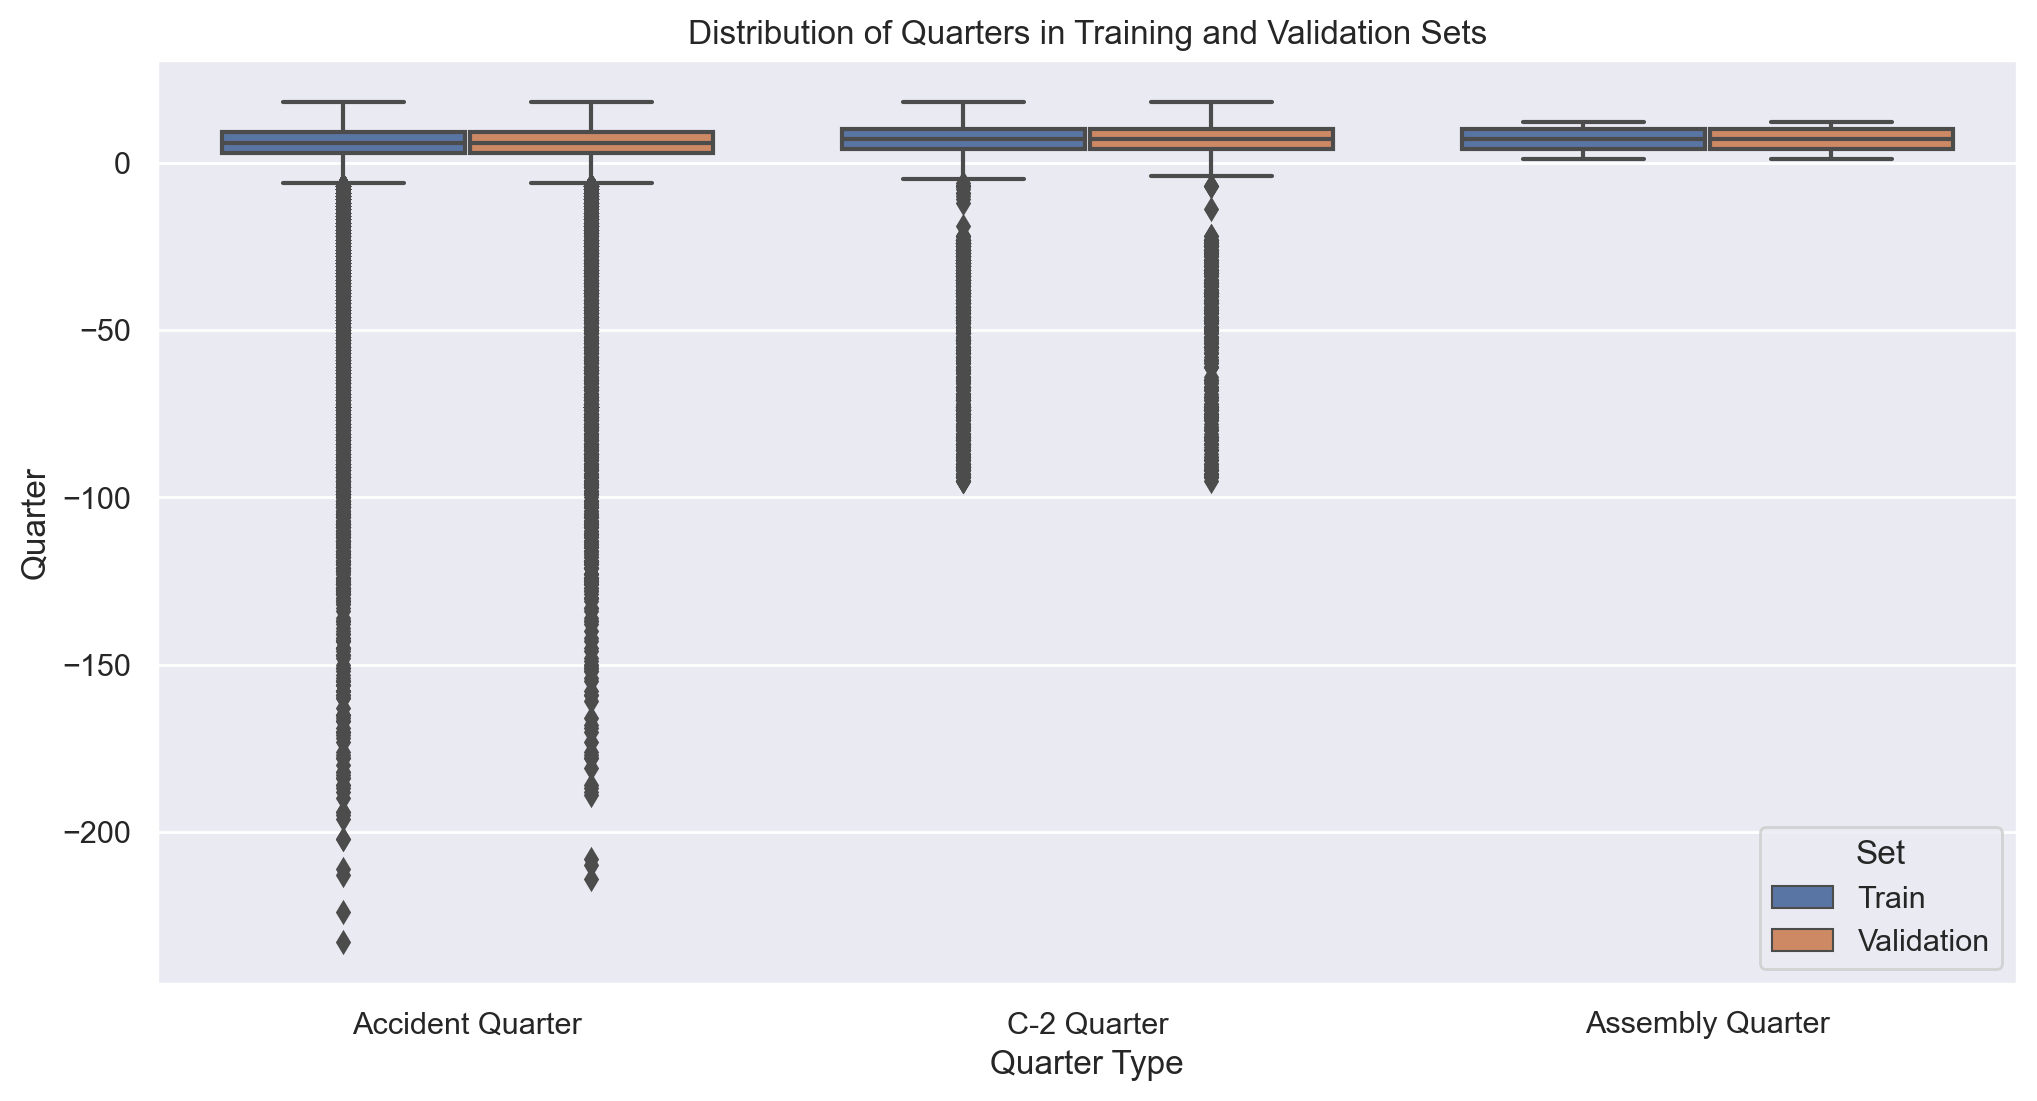

In [92]:
# Concate the training and validation sets too see them in the same plot
X_train['Set'] = 'Train'
X_val['Set'] = 'Validation'
data = pd.concat([X_train, X_val], ignore_index=True)

# Melt the DataFrame for Seaborn
melted_data = data.melt(id_vars=['Set'], value_vars=['Accident Quarter', 'C-2 Quarter', 'Assembly Quarter'],
                        var_name='Quarter Type', value_name='Quarter')

# Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x='Quarter Type', y='Quarter', hue='Set', data=melted_data)
plt.title("Distribution of Quarters in Training and Validation Sets")
plt.xlabel("Quarter Type")
plt.ylabel("Quarter")
plt.legend(title="Set")
plt.show()

# We don't need 'Set' anmore, let's drop it
X_train = X_train.drop(columns=['Set'])
X_val = X_val.drop(columns=['Set'])

As we can see clearly, our validation and training sets are very similarly distributed, with very similar range and median values for each quarter.

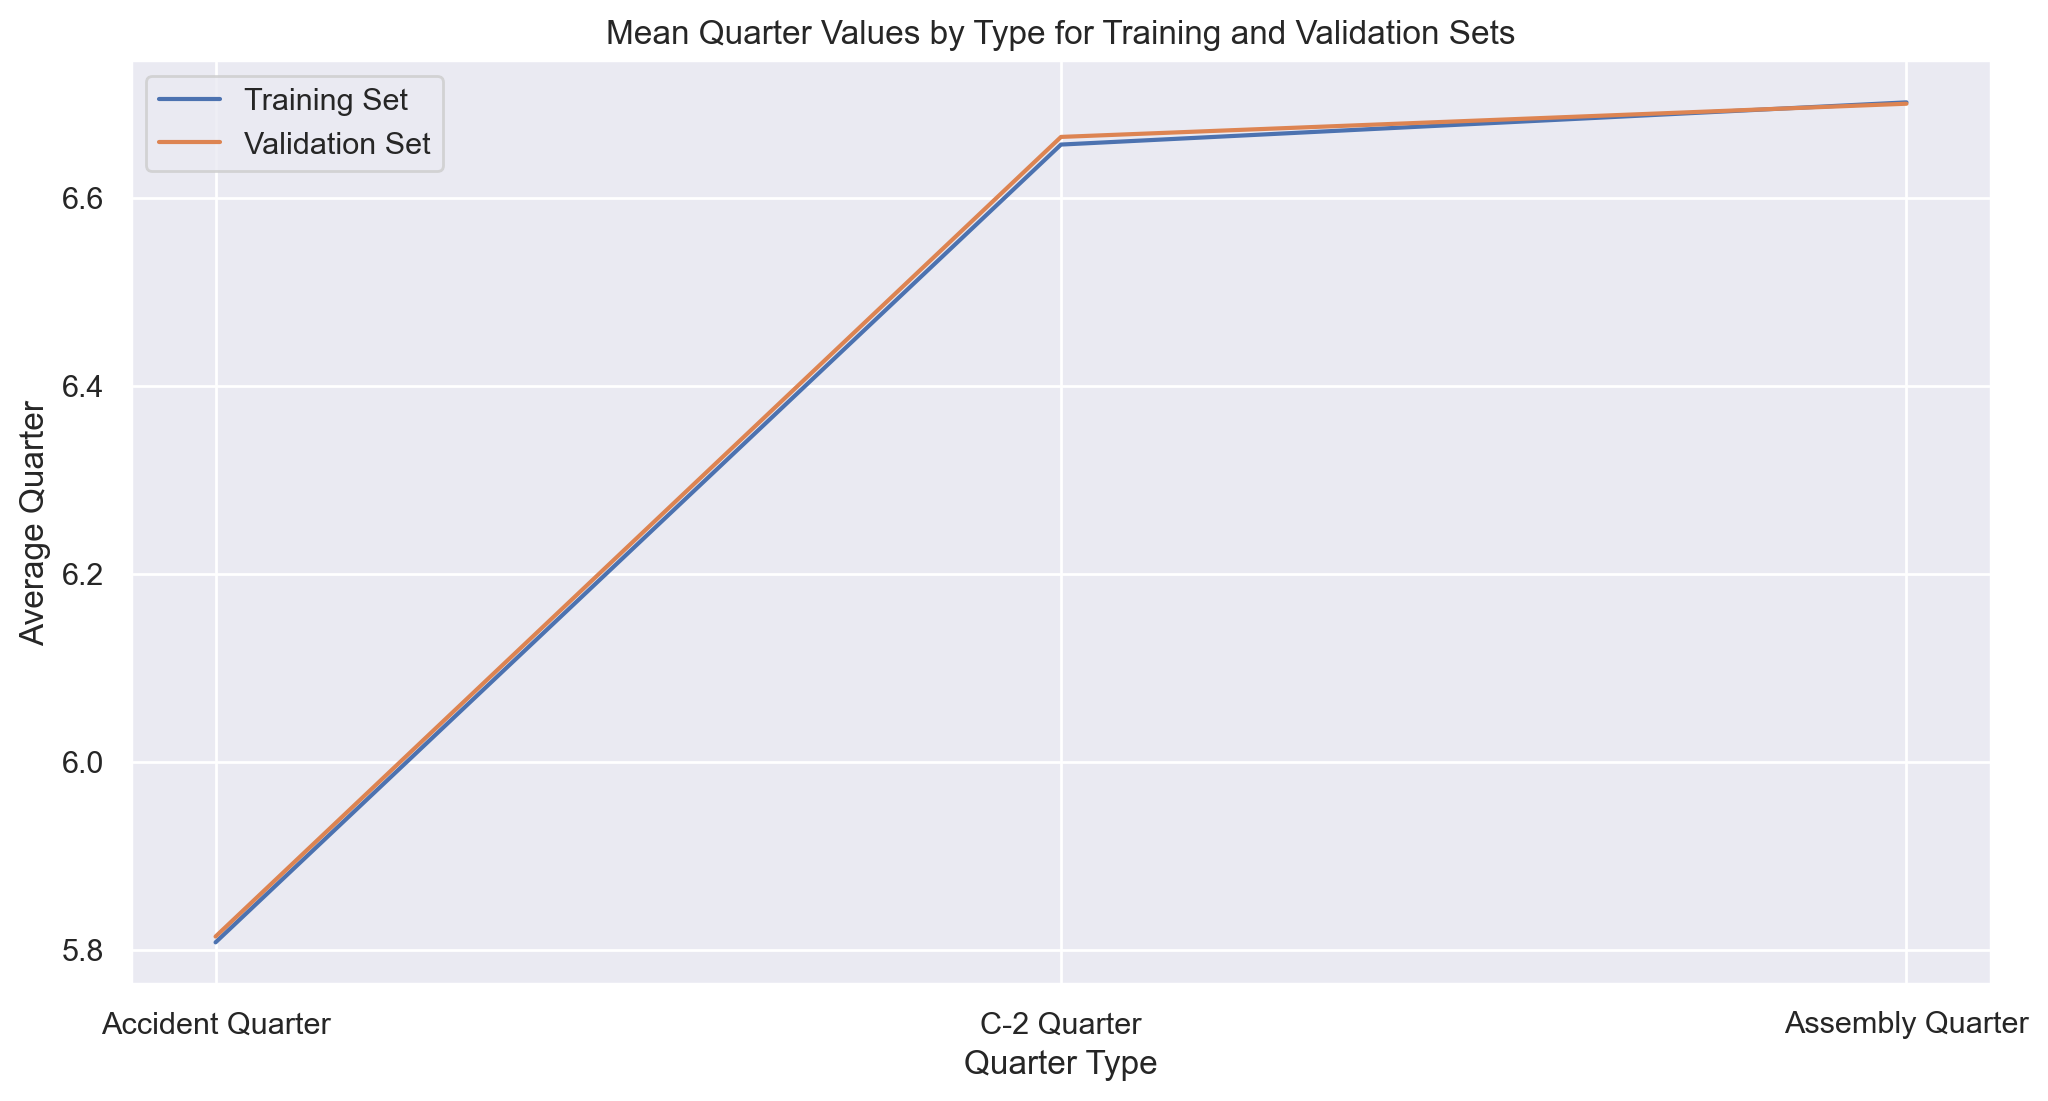

In [93]:
# Aggregate by quarter type and calculate mean
X_train_agg = X_train[['Accident Quarter', 'C-2 Quarter', 'Assembly Quarter']].mean()
X_val_agg = X_val[['Accident Quarter', 'C-2 Quarter', 'Assembly Quarter']].mean()

# Plot the aggregated data
plt.figure(figsize=(12, 6))
plt.plot(X_train_agg, label='Training Set')
plt.plot(X_val_agg, label='Validation Set')
plt.xlabel("Quarter Type")
plt.ylabel("Average Quarter")
plt.title("Mean Quarter Values by Type for Training and Validation Sets")
plt.legend()
plt.show()


As concluded from the previous set, the training and validation sets are very similarly distributed, fact shown by the closeness and form of the lines, although *Assembly Quarter* significantly later than *Accident Quarter*, and *C-2 Quarter* a bit earlier.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


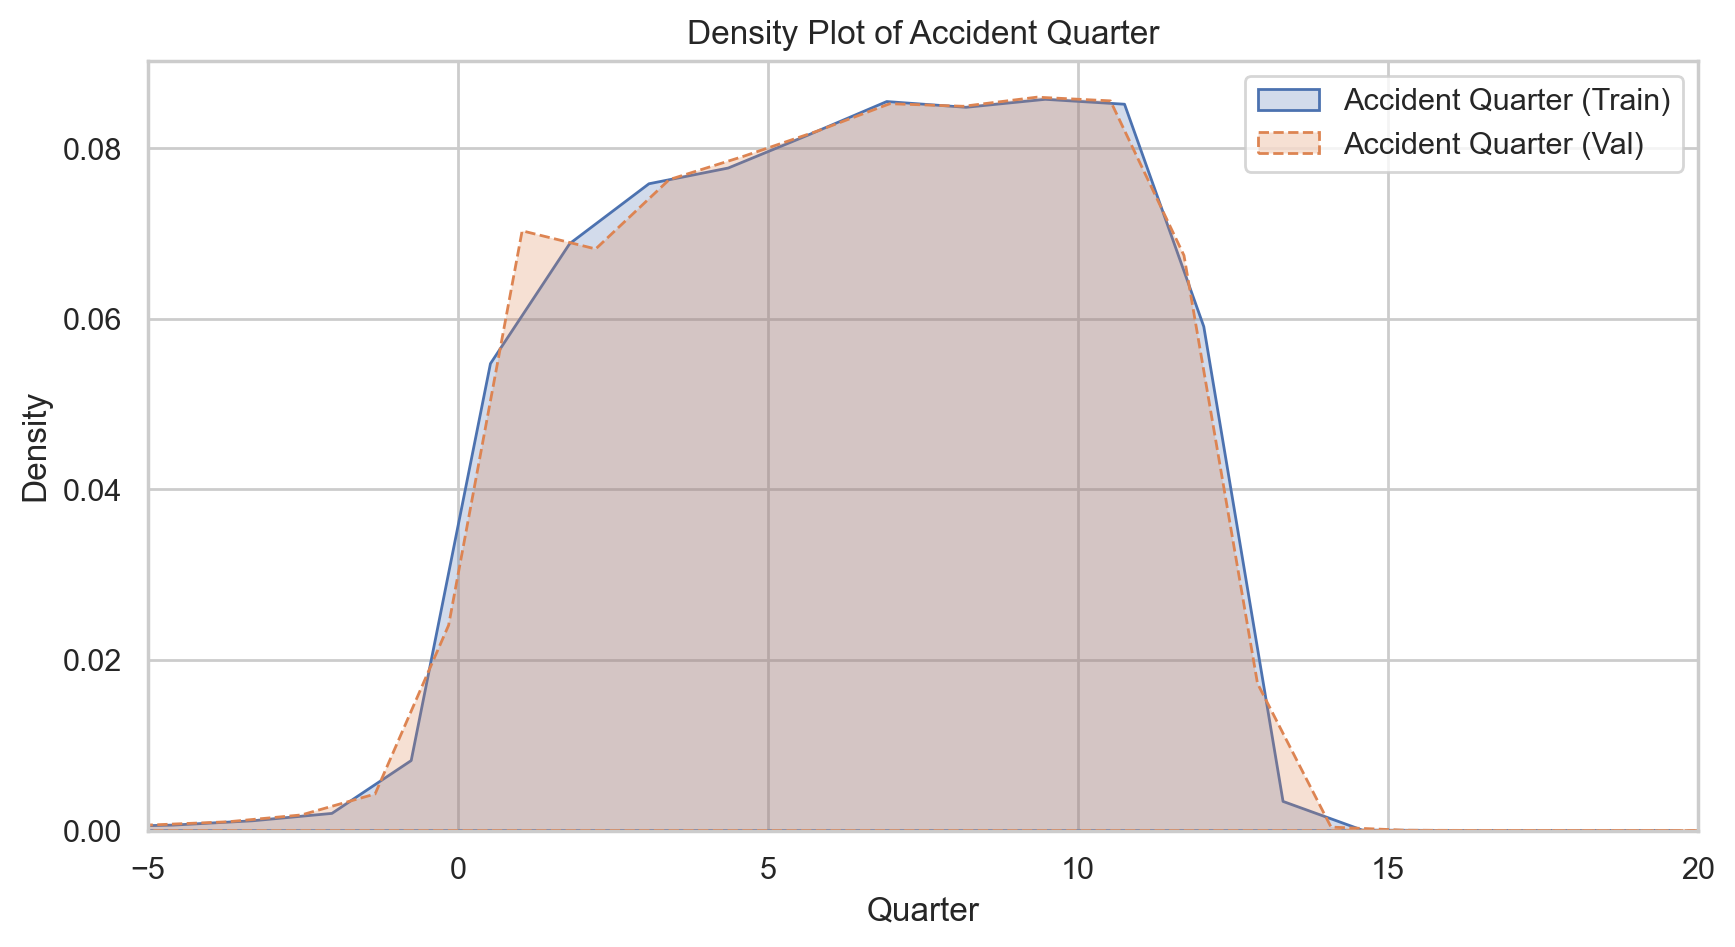

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


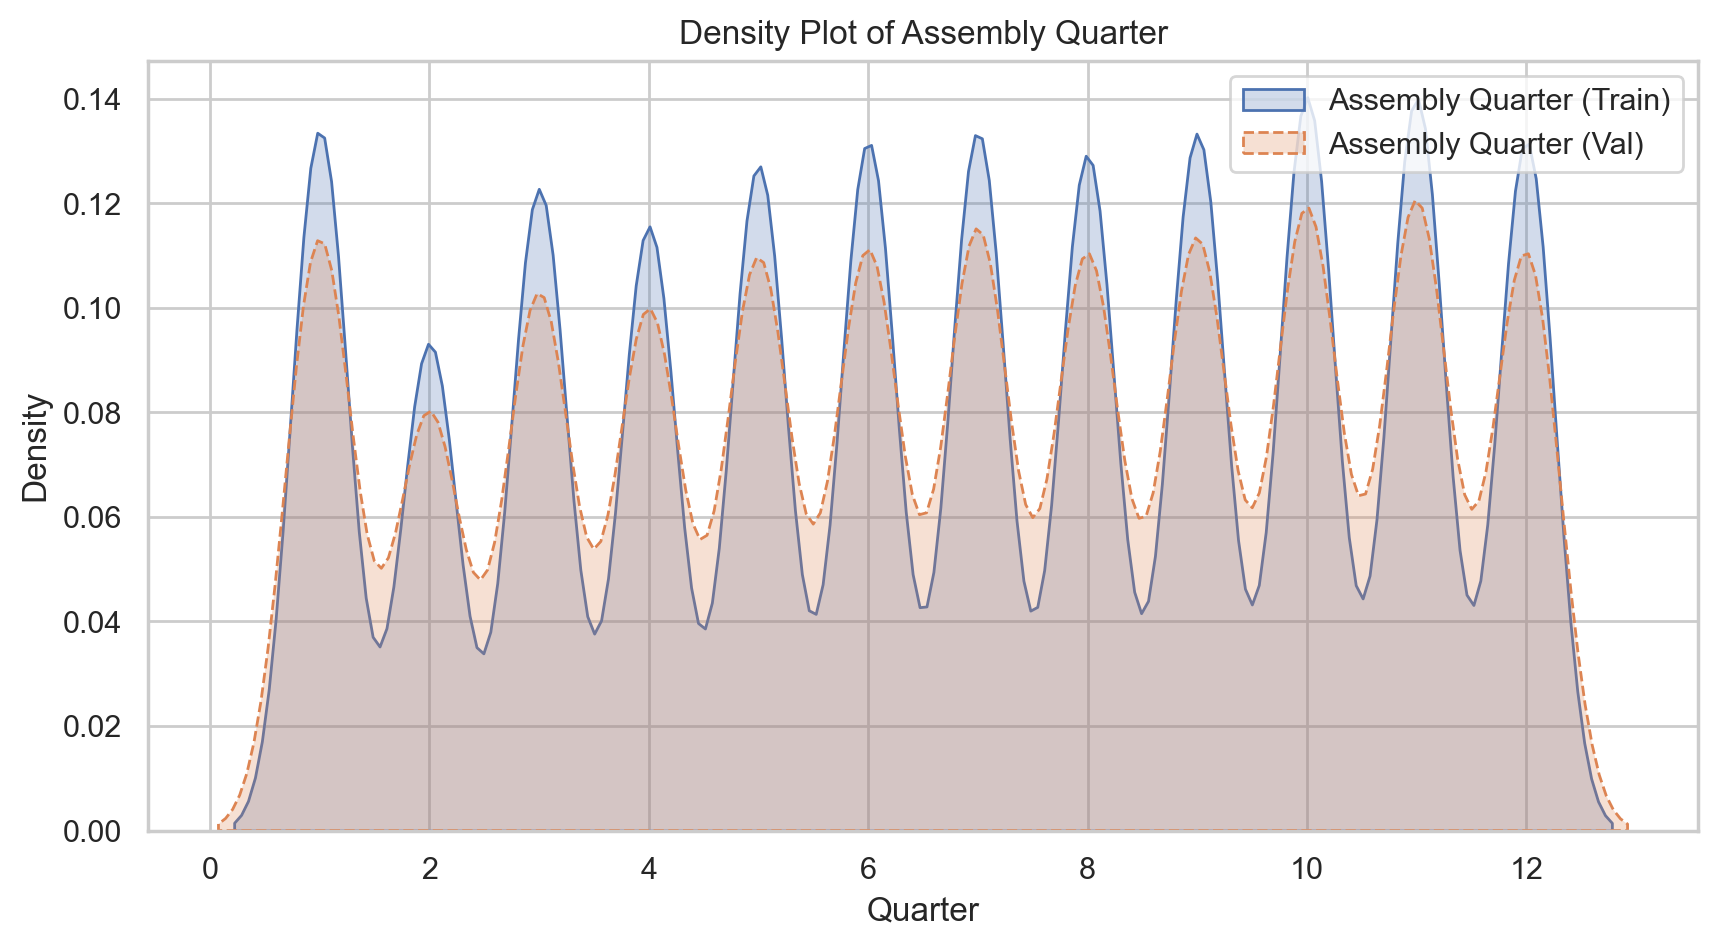

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


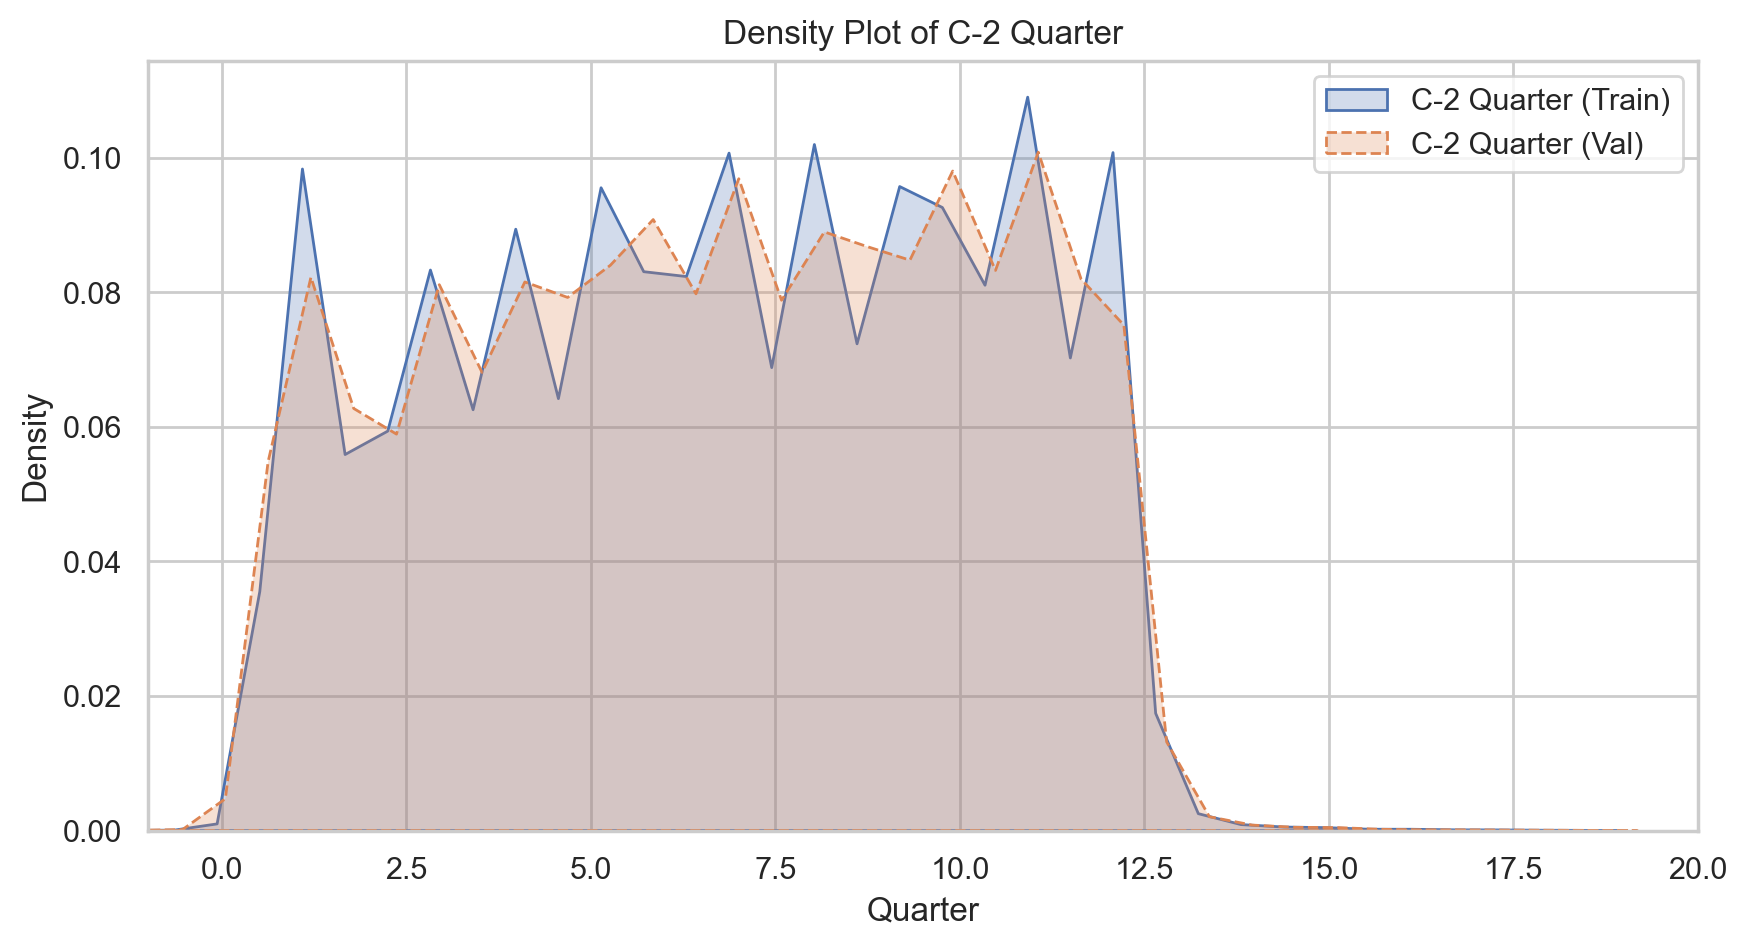

In [94]:
sns.set(style="whitegrid")

# Distribution for Accident Quarter
plt.figure(figsize=(10, 5))
sns.kdeplot(data=X_train, x="Accident Quarter", label="Accident Quarter (Train)", fill=True)
sns.kdeplot(data=X_val, x="Accident Quarter", label="Accident Quarter (Val)", linestyle="--", fill=True)
plt.title("Density Plot of Accident Quarter")
plt.xlim(-5, 20)
plt.xlabel("Quarter")
plt.ylabel("Density")
plt.legend()
plt.show()

# Distribution for Assembly Quarter
plt.figure(figsize=(10, 5))
sns.kdeplot(data=X_train, x="Assembly Quarter", label="Assembly Quarter (Train)", fill=True)
sns.kdeplot(data=X_val, x="Assembly Quarter", label="Assembly Quarter (Val)", linestyle="--", fill=True)
plt.title("Density Plot of Assembly Quarter")
plt.xlabel("Quarter")
plt.ylabel("Density")
plt.legend()
plt.show()

# Distribution for C-2 Quarter
plt.figure(figsize=(10, 5))
sns.kdeplot(data=X_train, x="C-2 Quarter", label="C-2 Quarter (Train)", fill=True)
sns.kdeplot(data=X_val, x="C-2 Quarter", label="C-2 Quarter (Val)", linestyle="--", fill=True)
plt.title("Density Plot of C-2 Quarter")
plt.xlim(-1, 20)
plt.xlabel("Quarter")
plt.ylabel("Density")
plt.legend()
plt.show()

# Since Accident date and C2 data have a ton of outliers, we will limit the x axis for a better visualization

In terms of distributions, both our validation and training sets are very similarly distributed in all 3 features. More specifically:
- **Density for Accident Quarter:** we can see that this feature is almost normally distributed, increasing progressively from 0 and reaching a peak at approximately quarter 7, decreasing from that point onwards.
- **Density for Assembly Quarter and C-2 Quarter:** Contrarily to the previous graph, both this features are, roughly speaking, quite similar distributed and fall in the same range of x-values, peaking in every quarter. The surges and drops are very clear, especially in Assembly Quarter, whose curves are very smooth and not as linear as C-2 Quarter.

## 7.2. Drop Original Features: *Accident Date*, *Assembly Date*, and *C-2 Date*

In [95]:
X_train.drop("Accident Date", axis=1, inplace=True)
X_train.drop("Assembly Date", axis=1, inplace=True)
X_train.drop("C-2 Date", axis=1, inplace=True)

X_val.drop("Accident Date", axis=1, inplace=True)
X_val.drop("Assembly Date", axis=1, inplace=True)
X_val.drop("C-2 Date", axis=1, inplace=True)

## 7.3. Create CSV Files for Following Processes

In [96]:
X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
test.to_csv('test.csv')

In [97]:
X_train = pd.read_csv('X_train.csv')
X_val = pd.read_csv('X_val.csv')
y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')
test = pd.read_csv('test.csv')

In [98]:
# Set claim identifier as index and check the dataset
test.set_index("Claim Identifier", inplace=True)
test.head() 

Accident Date  Age at Injury  Alternative Dispute Resolution  \
Claim Identifier                                                                
6165911             2022-12-24             19                           False   
6166141             2022-11-20             19                           False   
6165907             2022-12-26             59                           False   
6166047             2022-12-28             55                           False   
6166102             2022-12-20             25                           False   

                 Assembly Date  Attorney/Representative  Average Weekly Wage  \
Claim Identifier                                                               
6165911             2023-01-02                    False                  0.0   
6166141             2023-01-02                    False                  0.0   
6165907             2023-01-02                    False                  0.0   
6166047             2023-01-02                    False                  0.0   
6166102             2023-01-02                    False                  0.0   

                  Birth Year    C-2 Date C-3 Date  \
Claim Identifier                                    
6165911               2003.0  2023-01-02      NaN   
6166141               2003.0  2023-01-02      NaN   
6165907               1963.0  2022-12-31      NaN   
6166047                  0.0  2023-01-02      NaN   
6166102               1997.0  2022-12-31      NaN   

                                 Carrier Name Carrier Type County of Injury  \
Claim Identifier                                                              
6165911             INDEMNITY INSURANCE CO OF  1A. PRIVATE            BRONX   
6166141               A I U INSURANCE COMPANY  1A. PRIVATE           QUEENS   
6165907             AMGUARD INSURANCE COMPANY  1A. PRIVATE      WESTCHESTER   
6166047           INDEMNITY INS. OF N AMERICA  1A. PRIVATE           QUEENS   
6166102            NEW HAMPSHIRE INSURANCE CO  1A. PRIVATE            KINGS   

                  COVID-19 Indicator District Name   First Hearing Date  \
Claim Identifier                                                          
6165911                        False           NYC  1900-01-01 00:00:00   
6166141                        False           NYC  1900-01-01 00:00:00   
6165907                        False           NYC  1900-01-01 00:00:00   
6166047                        False           NYC  1900-01-01 00:00:00   
6166102                        False           NYC  1900-01-01 00:00:00   

                 Gender  IME-4 Count  Industry Code Medical Fee Region  \
Claim Identifier                                                         
6165911               M          NaN           48.0                 IV   
6166141               F          NaN           44.0                 IV   
6165907               F          NaN           56.0                III   
6166047               F          NaN           48.0                 IV   
6166102               M          NaN           55.0                 IV   

                  OIICS Nature of Injury Description  \
Claim Identifier                                       
6165911                                          NaN   
6166141                                          NaN   
6165907                                          NaN   
6166047                                          NaN   
6166102                                          NaN   

                  WCIO Cause of Injury Code  WCIO Nature of Injury Code  \
Claim Identifier                                                          
6165911                                31.0                        10.0   
6166141                                75.0                        10.0   
6165907                                68.0                        49.0   
6166047                                25.0                        10.0   
6166102                                79.0                        40.0   

# __`8. Data Scaling`__ 

## 8.1. Label Encoder for Categorical Feature

In order to prevent issues that might arise during scaling or feature selection, having in mind those steps generally don’t support non-numeric inputs, we proceeded to label encode all categorical variables.

In [99]:
# Update the feature non_metric_features and metric_features
non_metric_features = X_train.select_dtypes(include=['object']).columns
metric_features = X_train.select_dtypes(include=['number']).columns

# LabelEncoder
label_encoder = LabelEncoder()

# Create a Loop that will apply LabelEncoder to every categorical feature 
for feature in non_metric_features:
    X_train[feature] = label_encoder.fit_transform(X_train[feature])
    X_val[feature] = label_encoder.fit_transform(X_val[feature])
    test[feature] = label_encoder.fit_transform(test[feature])

# Verification
for feature in non_metric_features:
    print(f"{feature} value counts:")
    print(X_train[feature].value_counts())

Carrier Type value counts:
Carrier Type
0    199662
2     85284
1     77886
3     37004
7      1262
6       715
4         4
5         1
Name: count, dtype: int64
District Name value counts:
District Name
4    189771
0     60062
3     42378
2     31824
7     31318
5     28275
1     15404
6      2786
Name: count, dtype: int64
First Hearing Date value counts:
First Hearing Date
0       296254
494        303
512        300
554        291
329        259
222        247
633        233
758        227
398        223
337        220
591        215
430        212
756        210
429        209
428        204
751        202
447        198
759        196
184        195
760        193
735        193
753        193
490        192
516        192
761        192
515        190
159        189
435        188
727        188
754        185
426        185
814        184
425        182
439        181
549        181
541        181
785        180
517        180
575        180
471        180
454        179
462    

## 8.2. Normalize The Numerical Data
We decided to use StandardScaler() because we're dealing with a very large dataset. This scaler ensures rather quickly that all features are on a similar scale, contrarily to other scalers like MinMaxScaler() that are computational expensive since they need to calculate the minimum and maximum values for every feature. 
Therefore, StandardScaler() contributes to the model stability, convergence speed, and the accuracy of feature selection.

In [100]:
# Scale the train set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [101]:
# Scale the validation set
X_val_scaled = scaler.transform(X_val) 
X_val_scaled = pd.DataFrame(X_val_scaled, columns = X_val.columns)
X_val_scaled.head()

Age at Injury  Alternative Dispute Resolution  Attorney/Representative  \
0      -0.476540                       -0.067584                -0.681077   
1      -0.328372                       -0.067584                 1.468263   
2       1.079225                       -0.067584                -0.681077   
3      -0.402456                       -0.067584                -0.681077   
4      -1.587800                       -0.067584                -0.681077   

   Average Weekly Wage  Carrier Type  District Name  First Hearing Date  \
0            -0.609266     -0.836162       0.883528           -0.523958   
1            -0.609266     -0.836162       0.350871           -0.523958   
2            -0.609266     -0.836162       0.350871           -0.523958   
3            -0.609266      0.967247       0.350871           -0.523958   
4            -0.609266      0.967247      -1.247100           -0.523958   

     Gender  Industry Code  Medical Fee Region  WCIO Cause of Injury Code  \
0  0.786698       0.156884           -1.464171                  -1.050181   
1  0.786698       0.614215            0.778340                   0.915506   
2  0.786698      -0.402076            1.525844                   0.011290   
3 -1.185904       0.106070            0.778340                   0.718937   
4 -1.185904       0.106070           -1.464171                  -0.106651   

   WCIO Nature of Injury Code  WCIO Part Of Body Code  Number of Dependents  \
0                   -0.572850                0.723765              -1.00416   
1                   -0.169048               -0.222714               0.99428   
2                    0.503957                0.092779              -1.00416   
3                   -1.380456               -0.222714              -0.00494   
4                    0.503957                0.588554              -1.00416   

   Professional Status  Accident Quarter  Assembly Quarter  C-2 Quarter  
0             0.918827         -0.375405         -1.076443    -0.822398  
1             0.918827          0.827976          1.540689     1.201644  
2            -0.460004          0.025722         -0.204066    -0.147717  
3             0.918827          0.560558          1.249896     0.976750  
4             0.918827          0.694267          1.249896     0.976750

# __`9. Feature Selection`__ 

## 9.1. Filter Methods

Create Heatmap to check the correlation between features.

In [102]:
cor_spearman = X_train_scaled.corr(method ='spearman')
cor_spearman

Age at Injury  Alternative Dispute Resolution  \
Age at Injury                        1.000000                        0.019534   
Alternative Dispute Resolution       0.019534                        1.000000   
Attorney/Representative              0.132324                       -0.026232   
Average Weekly Wage                  0.117863                       -0.049592   
Carrier Type                         0.059749                        0.111856   
District Name                       -0.003097                        0.010635   
First Hearing Date                   0.116074                       -0.039450   
Gender                              -0.035600                        0.049092   
Industry Code                        0.000552                        0.029548   
Medical Fee Region                   0.020598                        0.055943   
WCIO Cause of Injury Code           -0.029213                        0.001836   
WCIO Nature of Injury Code           0.044086                       -0.082652   
WCIO Part Of Body Code               0.015912                        0.050937   
Number of Dependents                 0.000211                       -0.000408   
Professional Status                 -0.094387                        0.045677   
Accident Quarter                    -0.025212                       -0.003133   
Assembly Quarter                    -0.019543                       -0.001641   
C-2 Quarter                         -0.019745                       -0.002301   

                                Attorney/Representative  Average Weekly Wage  \
Age at Injury                                  0.132324             0.117863   
Alternative Dispute Resolution                -0.026232            -0.049592   
Attorney/Representative                        1.000000             0.524714   
Average Weekly Wage                            0.524714             1.000000   
Carrier Type                                   0.090988             0.070102   
District Name                                  0.036767             0.006781   
First Hearing Date                             0.651952             0.497004   
Gender                                         0.085008             0.081441   
Industry Code                                  0.024556             0.040971   
Medical Fee Region                             0.181862             0.074385   
WCIO Cause of Injury Code                      0.001704            -0.038303   
WCIO Nature of Injury Code                     0.059676             0.044195   
WCIO Part Of Body Code                        -0.028313            -0.003513   
Number of Dependents                          -0.000698            -0.000698   
Professional Status                           -0.487511            -0.839187   
Accident Quarter                              -0.050062            -0.013884   
Assembly Quarter                              -0.035108            -0.034631   
C-2 Quarter                                   -0.008332            -0.016572   

                                Carrier Type  District Name  \
Age at Injury                       0.059749      -0.003097   
Alternative Dispute Resolution      0.111856       0.010635   
Attorney/Representative             0.090988       0.036767   
Average Weekly Wage                 0.070102       0.006781   
Carrier Type                        1.000000       0.030654   
District Name                       0.030654       1.000000   
First Hearing Date                  0.033434       0.028675   
Gender                             -0.014630      -0.010166   
Industry Code                       0.315810      -0.006182   
Medical Fee Region                 -0.006033       0.181506   
WCIO Cause of Injury Code           0.023781       0.001473   
WCIO Nature of Injury Code         -0.063026      -0.006726   
WCIO Part Of Body Code             -0.047281      -0.009975   
Number of Dependents               -0.000133       0.000662   
Professional Status       

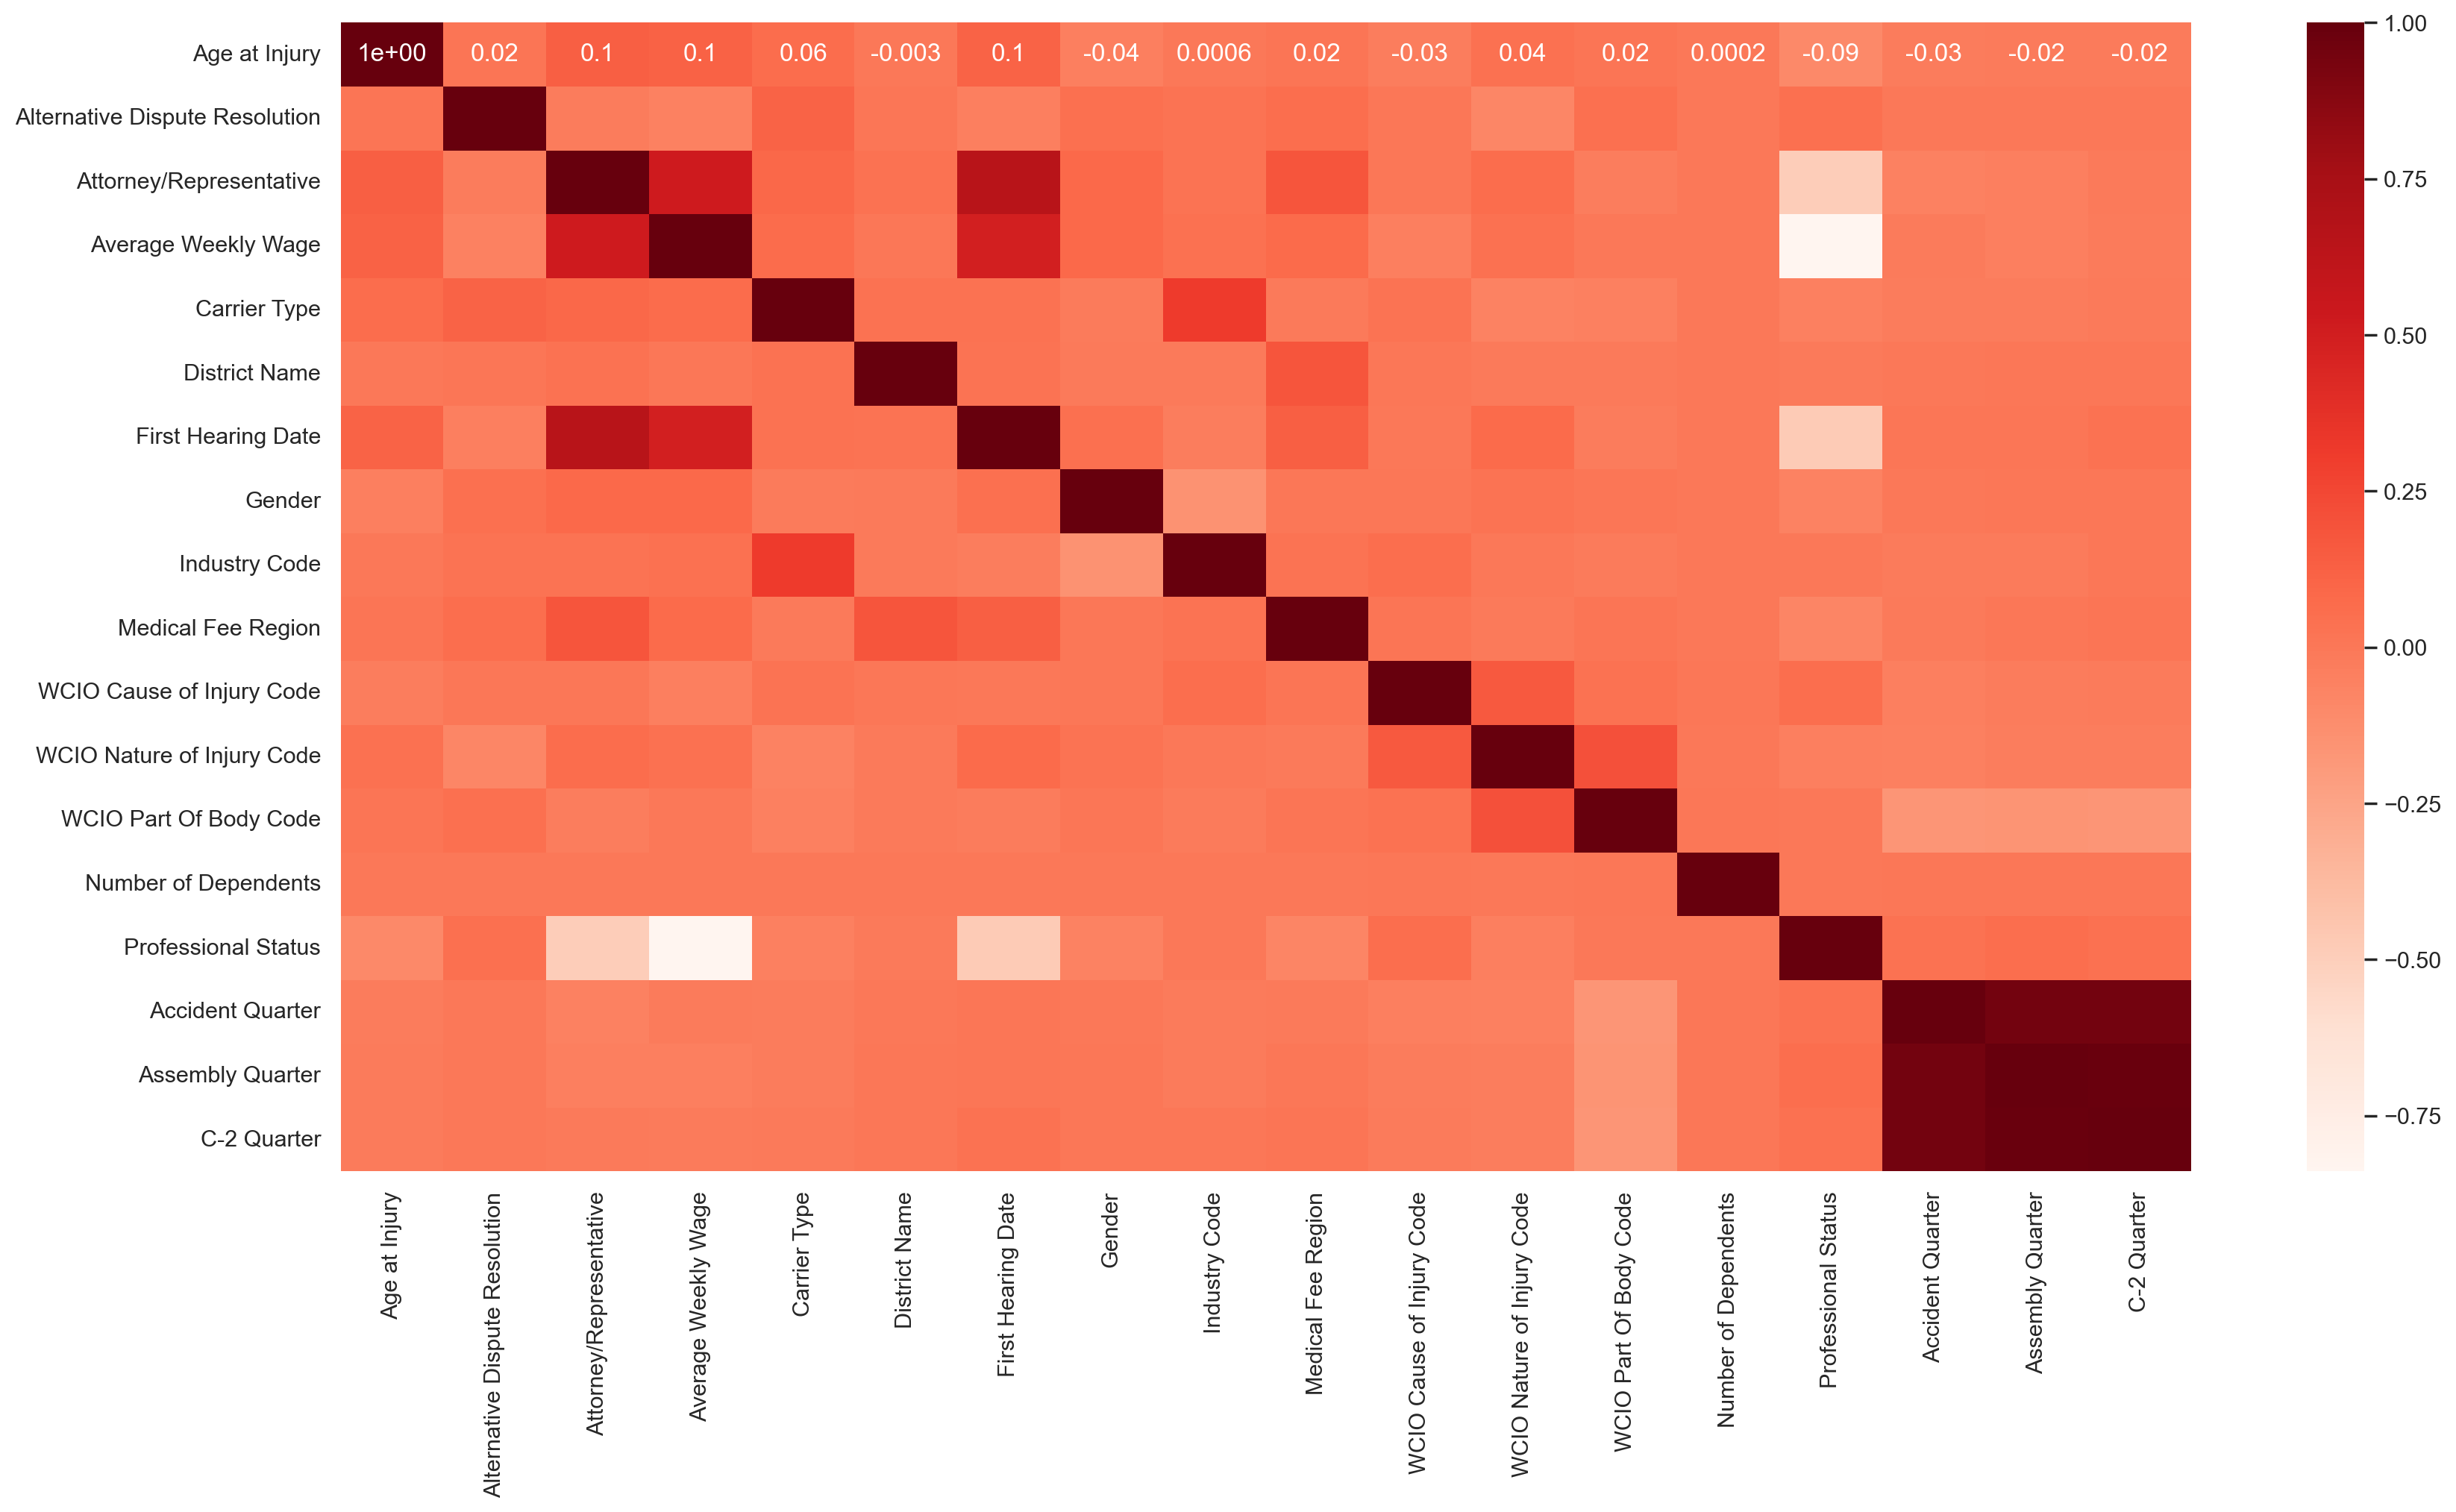

In [103]:
def cor_heatmap(cor):
    plt.figure(figsize=(20,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

cor_heatmap(cor_spearman)

After analysing the heatmap, we see that there are three pairs of vfeatures highly correlated, namely:
* *Accident Quarter* vs. *Assembly Quarter* (1)
* *Accident Quarter* vs. *C-2 Quarter* (1)
* *Assembly Quarter* vs. *C-2 Quarter* (1)
* *Average Weekly Wage* vs. *Professional Status* (-0.8)
* *First Hearing Date* vs. *Attorney/Representative* (-0.7) <br>

We need to use other techniques of feature selection to decide which features we should keep.

Let's take a closer look at our target feature *Claim Injury Type*:

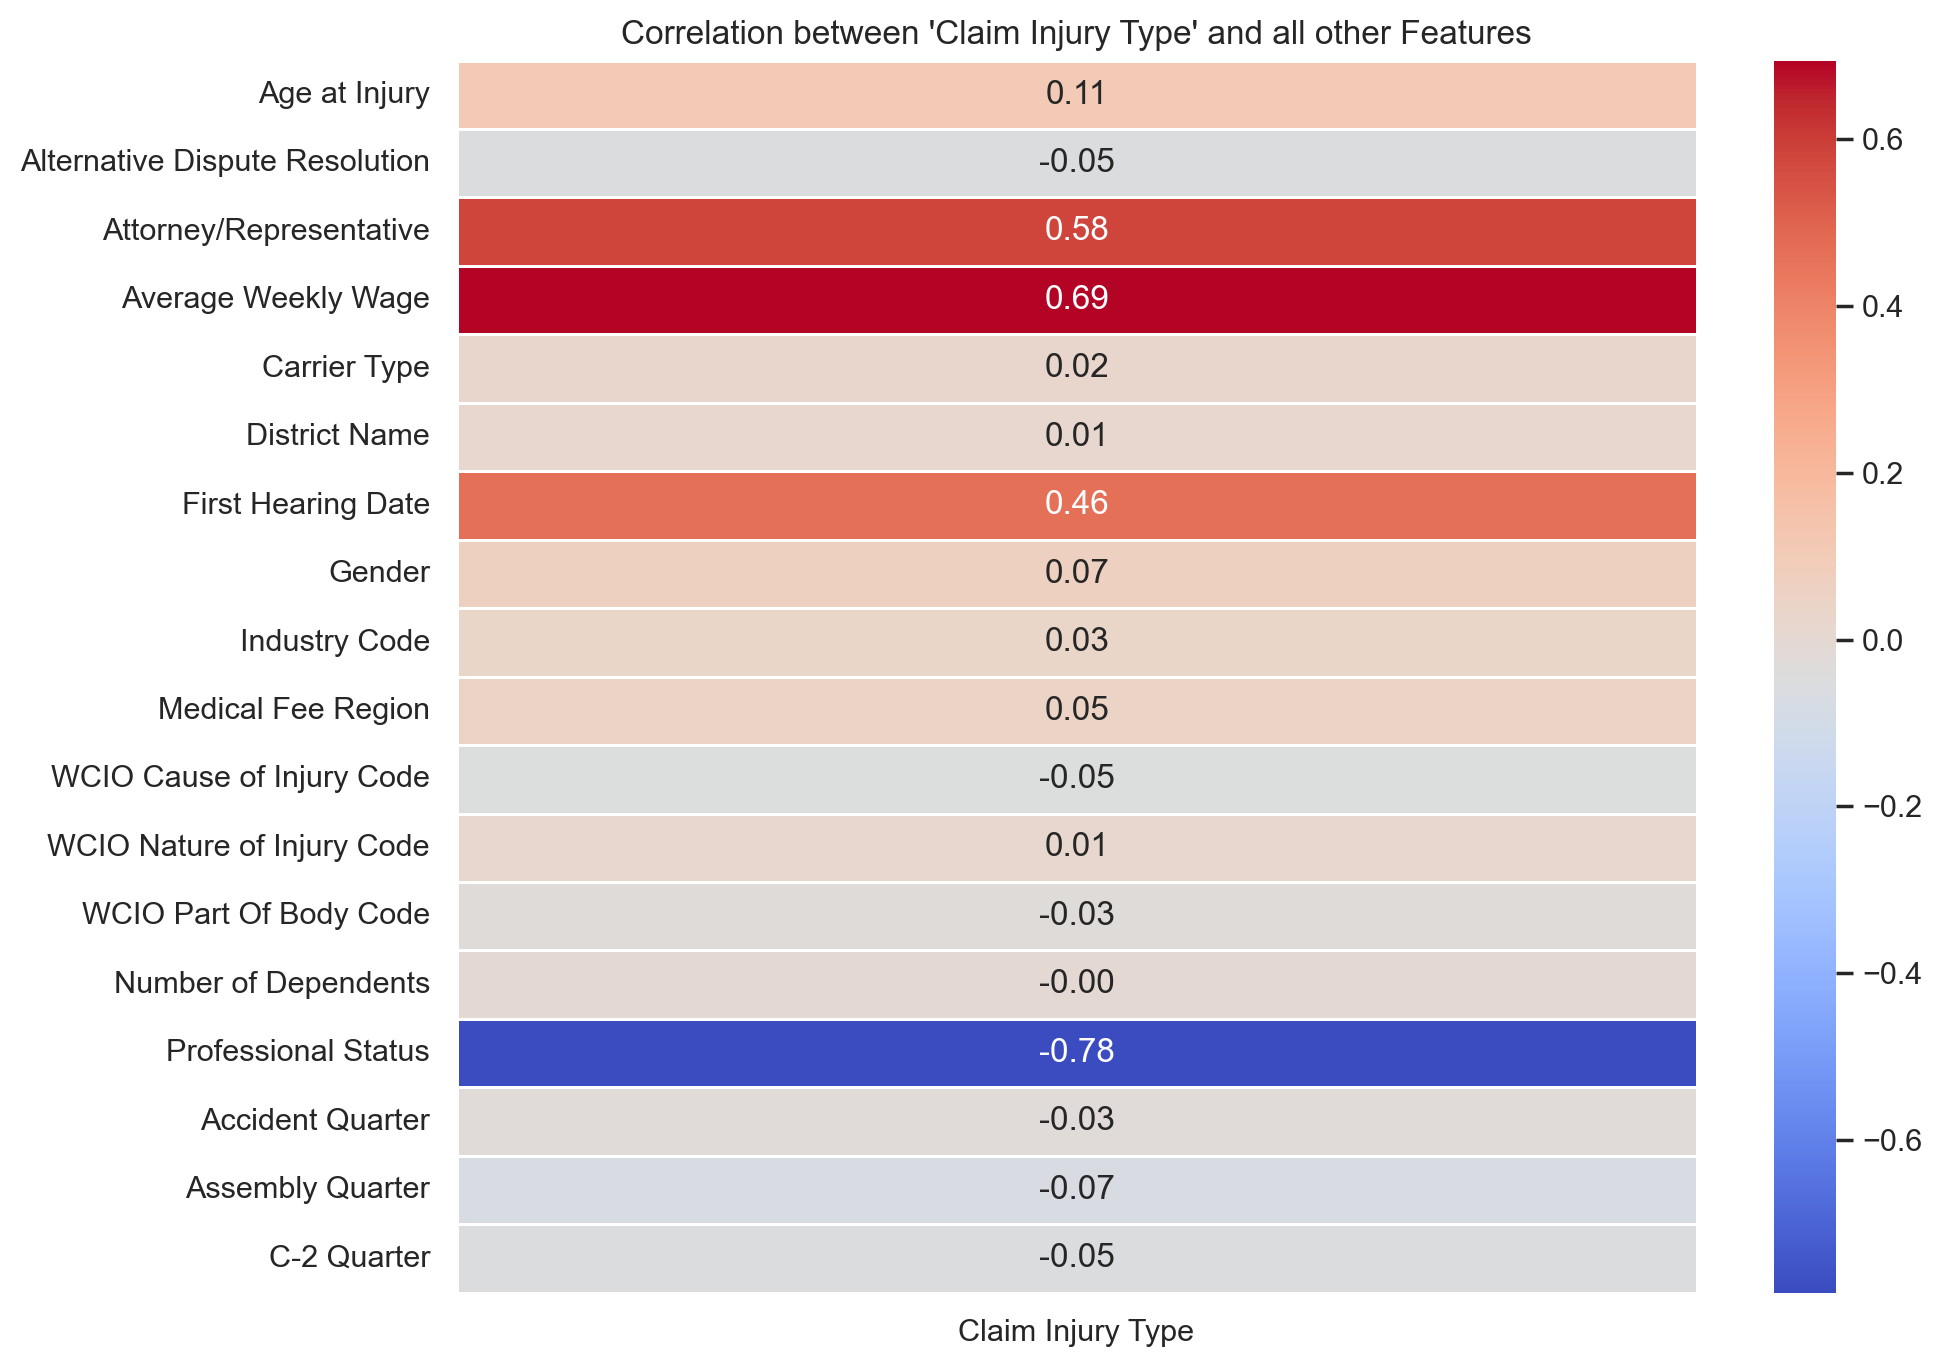

In [104]:
train_data = X_train.copy()
train_data['Claim Injury Type'] = y_train

# Calculate the correlation matrix
correlations = train_data.corr()[['Claim Injury Type']].drop('Claim Injury Type')  # Check correlation with Claim Injury Type, but don't calculate the correlation with itself

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', linewidths=0.5)
plt.title("Correlation between 'Claim Injury Type' and all other Features")
plt.show()

It is important to emphasize:
* **Attorney/Representative** (0.58): There is a moderate positive correlation between the presence of an attorney/representative and the type of claim injury, which suggests that the presence of an attorney makes it more likely for the person to be related with some specific *claim injury types*.
* **Average Weekly Wage** (0.69): Standing out as the strongest positive correlation with *Claim Injury Type*, this value indicates that a higher weekly wage may be associated with determinated claim injury types, possibly claiming more severe injuries.
* **First Hearing Date** (0.46): It indicates a moderately negative correlation, which could mean, e.g., that certain, more complex injury type cases may take longer to get a hearing.
* **Age at Injury** (0.11): This feature presents a weak positive correlation with the *claim injury types*, which means it holds some influence, but not much.
* **Alternative Dispute Resolution** (-0.05), **Carrier Type** (0.02), **Gender** (0.07), **District Name** (0.01), **Industry Code** (0.03), **Medical Fee Region** (0.05), **WCIO Cause of Injury Code** (-0.05), **WCIO Nature of Injury Code** (0.01), **WCIO Part Of Body Code** (-0.03), and **Number of Dependents** (-0.00): Significantly weak correlations with the *Claim Injury Type*, implying an absence of any kind of association with the injury claim type.
* **Professional Status** (-0,78): Major negative correlation, which means that the employment state of the individual will have an inverse relationship with the *Claim Injury Type* they have.
* **Accident Quarter** (-0.03), **Assembly Quarter** (-0.07), and **C-2 Quarter** (-0.05): Weak negative correlations with the *Claim Injury Type*, suggesting that the time periods during which the accident occurred might have very little impact on the type of injury.

Using a [ |0.2|, |0.8| ] treshold, we conclude we should keep:
* *First Hearing Date*
* *Average Weekly Wage* or *Professional Status*
* *Attorney/Representative*


## 9.2. Wrapper Methods: RFE

We selected Random Forest for our model because it is able to reduce overfitting by averaging multiple decision trees and opperates smoothly with large datasets. We also enabled parallel computation (n_jobs=-1) in order to speed up training.

In [105]:
nof_list=np.arange(1,19)    
high_score=0

# Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    # Enable parallel computation, which will speed up training by utilizing multiple CPU cores.This will train each tree in parallel, dramatically reducing the training time
    model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1) 
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_val_rfe = rfe.transform(X_val)
    model.fit(X_train_rfe,y_train)
    
    # Store results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    # Store results on training data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    # Check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score)) 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:299: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:299: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:299: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:299: DataConversionWarning: A column-vector y was passed when

Optimum number of features: 18
Score with 18 features: 0.785236


RFE suggests we keep 18 features. Let's check which ones:

In [106]:
rfe = RFE(estimator = model, n_features_to_select = 18)
X_rfe = rfe.fit_transform(X = X_train_scaled, y = y_train)
rfe.support_

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_rfe.py:326: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y, **fit_params)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [107]:
selected_features = pd.Series(rfe.support_, index = X_train_scaled.columns)
selected_features

Age at Injury                     True
Alternative Dispute Resolution    True
Attorney/Representative           True
Average Weekly Wage               True
Carrier Type                      True
District Name                     True
First Hearing Date                True
Gender                            True
Industry Code                     True
Medical Fee Region                True
WCIO Cause of Injury Code         True
WCIO Nature of Injury Code        True
WCIO Part Of Body Code            True
Number of Dependents              True
Professional Status               True
Accident Quarter                  True
Assembly Quarter                  True
C-2 Quarter                       True
dtype: bool

According to RFE, we should keep all features, including both Average Weekly Wage and Professional Status. This result contradicts the ones we took with filter methods, that indicating we should only keep 1 of these 2 features, since they're highly correlated. <br>
Let's check how training accuracy and validation accuracy vary with the number of features:

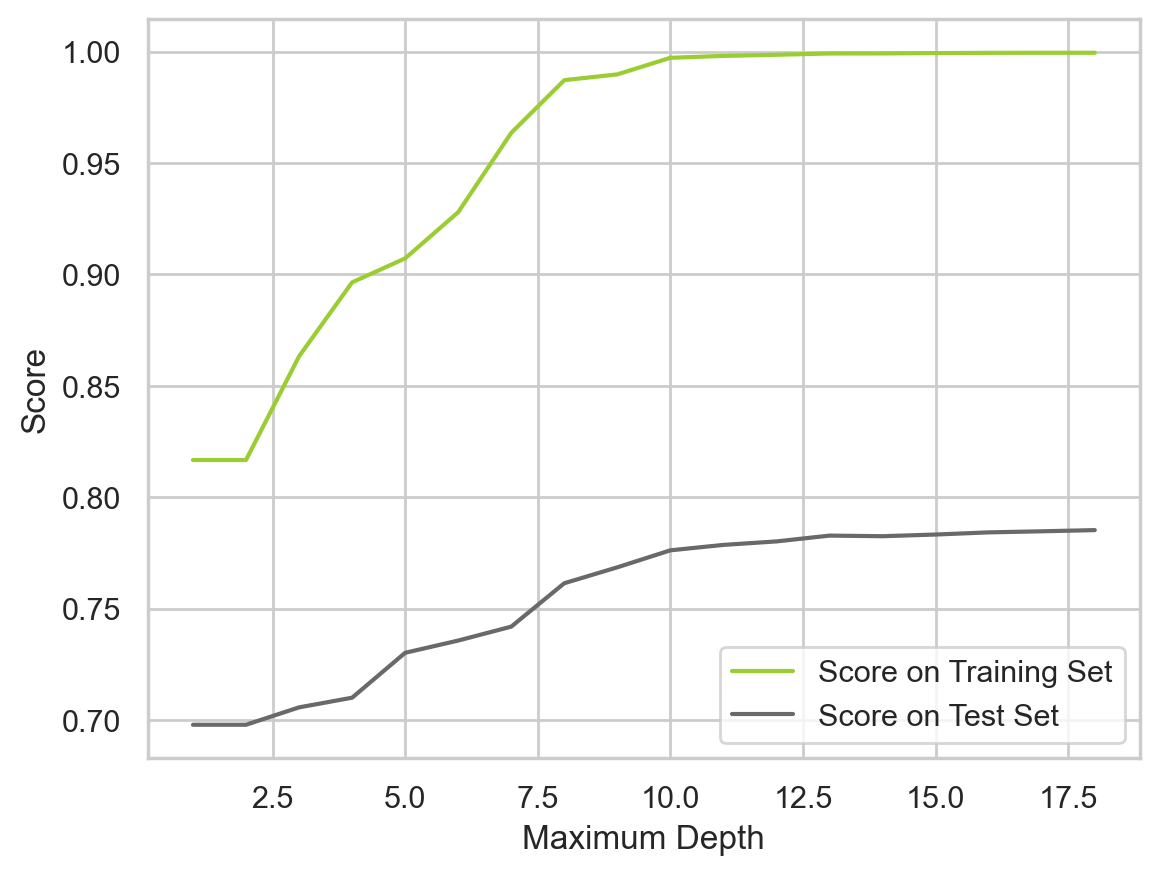

In [108]:
# Plot how training accuracy and validation accuracy vary with the number of features
plt.plot(list(range(1,19)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,19)), val_score_list, label="Score on Test Set", color='dimgray')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

The graph shows that the optimal number of features is something between 5 and 7, since it's the best score we can get without the training set reaching 1.

## 9.3 Embedded Methods: Lasso Regression

In [109]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [110]:
reg = LassoCV()
reg.fit(X_train, y_train)

coef = pd.Series(reg.coef_, index = X_train.columns)
coef.sort_values()

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables\n")
print(pd.Series(reg.coef_, index = X_train_scaled.columns))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso picked 4 variables and eliminated the other 14 variables

Age at Injury                     0.000000
Alternative Dispute Resolution   -0.000000
Attorney/Representative           0.000000
Average Weekly Wage               0.000938
Carrier Type                     -0.000000
District Name                     0.000000
First Hearing Date                0.000939
Gender                            0.000000
Industry Code                    -0.000000
Medical Fee Region               -0.000000
WCIO Cause of Injury Code        -0.001102
WCIO Nature of Injury Code       -0.000000
WCIO Part Of Body Code            0.000000
Number of Dependents             -0.000000
Professional Status              -0.000000
Accident Quarter                 -0.000093
Assembly Quarter                 -0.000000
C-2 Quarter                      -0.000000
dtype: float64


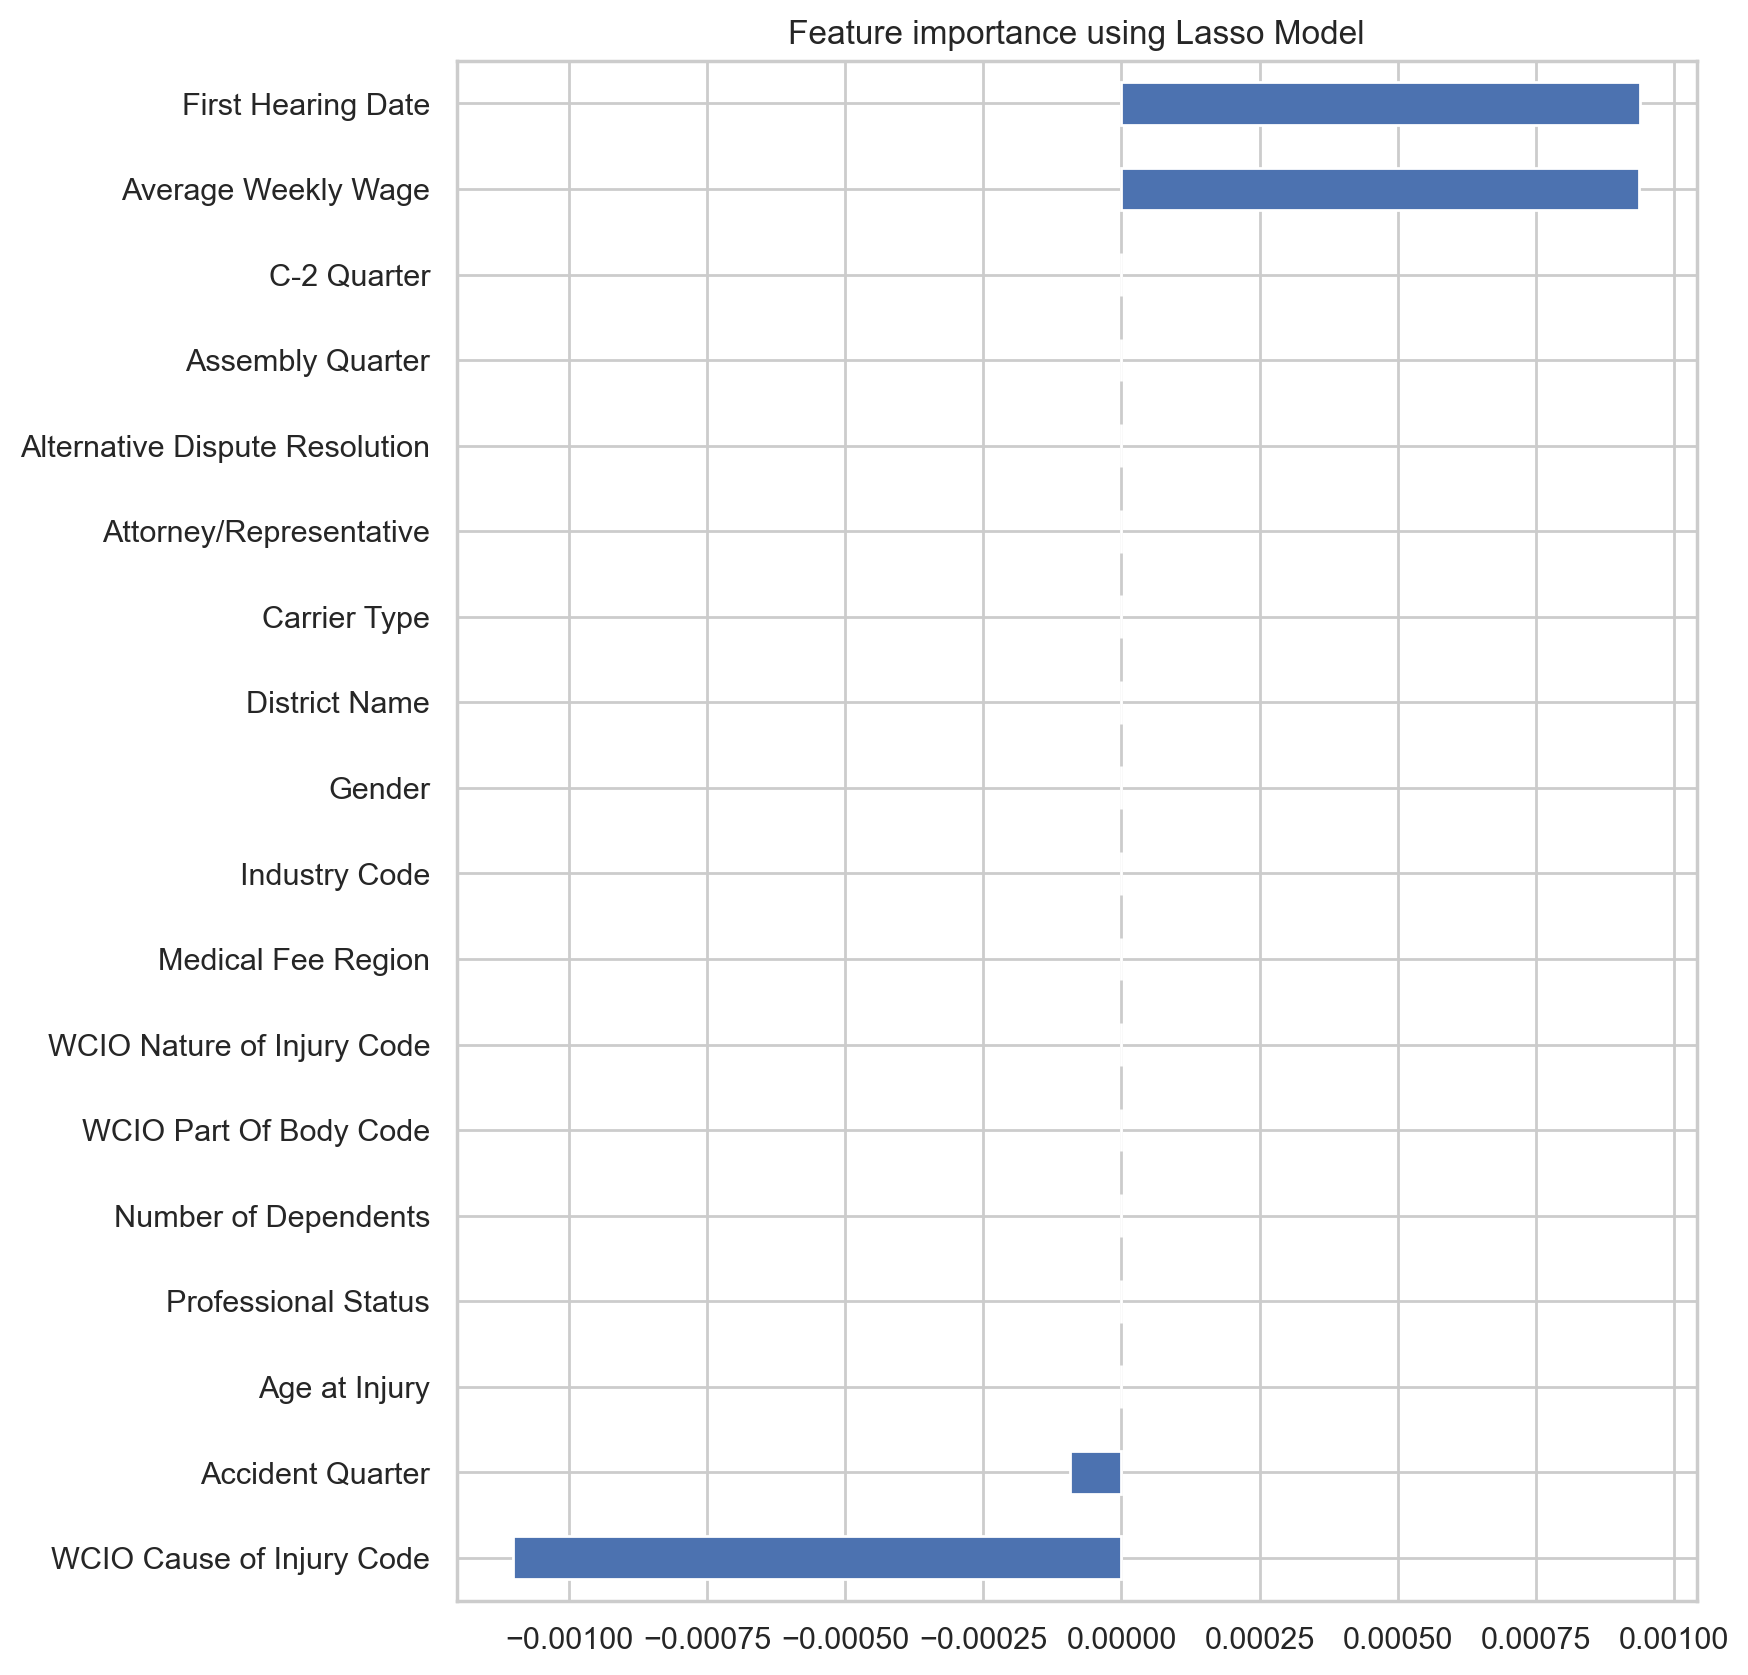

In [111]:
plot_importance(coef,'Lasso')

In terms of Lasso, we're reccomended to keep 3 features: Average Weekly Wage, WCIO Cause of Injury Code and First Hearing Date. It's important to notice, though, how low the significance coefficients are, even for the chosen features.

## 9.4. Final Insights
<hr>

### Numerical Data

| Predictor | Spearman | RFE RF | Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |--- |
| Age at Injury | Discard | Keep | Discard | Discard |
| Alternative Dispute Resolution | Discard | Keep |Discard| Discard |
| Attorney/Representative | Keep | Keep |Discard| Include in the model |
| Average Weekly Wage | Keep (if Professional Status is discarded) | Keep | Keep | Include in the model |
| Carrier Type | Discard | Keep | Discard | Discard |
| District Name | Discard | Keep | Discard | Discard |
| First Hearing Date | Keep |Keep | Keep |  Include in the model |
| Gender | Discard | Keep | Discard | Discard |
| Industry Code | Discard | Keep | Discard | Discard |
| Medical Fee Region | Discard | Keep | Discard | Discard |
| WCIO Cause of Injury Code | Discard | Keep | Keep | Include in the model |
| WCIO Nature of Injury Code | Discard | Keep | Keep | Discard |
| WCIO Part Of Body Code | Discard | Keep | Discard | Discard |
| Number of Dependents | Discard | Keep | Discard | Include in the model |
| Professional Status | Keep (if Average Weekly Wage is discarded) | Keep | Discard | Include in the model |
| Accident Quarter | Discard | Keep | Discard | Discard |
| Assembly Quarter | Discard | Keep | Discard | Discard |
| C-2 Quarter | Discard | Keep | Discard | Discard |

<hr>

According to the graph ploted after the RFE, the best number of features is between 5 to 7, thus we are keeping 6 features.

In [112]:
X_train.drop(['Assembly Quarter', 'C-2 Quarter', 'Accident Quarter', 'WCIO Part Of Body Code', 
              'Medical Fee Region', 'Industry Code', 'Gender', 'District Name', 
              'Carrier Type', 'Alternative Dispute Resolution', 'Age at Injury', 
              'WCIO Nature of Injury Code'], axis=1, inplace=True)

In [113]:
features_to_ignore = ['Assembly Quarter', 'C-2 Quarter', 'Accident Quarter', 'WCIO Part Of Body Code', 
              'Medical Fee Region', 'Industry Code', 'Gender', 'District Name', 
              'Carrier Type', 'Alternative Dispute Resolution', 'Age at Injury', 
              'WCIO Nature of Injury Code']

X_val_new = X_val.drop(columns=features_to_ignore)

# __`10. Modeling`__ 

## 10.1. Decision Tree Algorithm
After reading material related to predictive modelling, we suspect that, initially, we will attain better results by using the **Decision Tree algorithm**.

Sources <br/>
https://scikit-learn.org/1.5/modules/tree.html <br/>

(log regr. only predict binary targets)

In [114]:
dt_classifier = DecisionTreeClassifier()

dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [115]:
# Predict for the training set
y_train_pred = dt_classifier.predict(X_train)

In [116]:
# Predict for the validation set
y_val_pred = dt_classifier.predict(X_val_new)

## 10.2. Performance on Validation Dataset

In [117]:
confusion_matrix(y_val, y_val_pred)

array([[  679,  2699,   185,   160,    18,     2,     0,     0],
       [  664, 84559,  1091,   863,   123,     7,     1,    16],
       [  302, 11245,  2295,  5329,  1357,   118,     4,    22],
       [  296,  2766,  5882, 27604,  6988,   913,    23,    80],
       [   24,   121,  1430,  6626,  5889,   355,    12,    27],
       [    3,     9,   114,   750,   318,    66,     0,     3],
       [    0,     1,     1,    18,     7,     2,     0,     0],
       [    2,    20,    21,    74,    18,     2,     1,     3]])

In [118]:
accuracy_score(y_train, y_train_pred)

0.906487514247744

In [119]:
accuracy_score(y_val, y_val_pred)

0.7031903279754715

In [120]:
f1_score(y_train, y_train_pred, average='weighted')

0.8964542780027418

In [121]:
f1_score(y_val, y_val_pred, average='weighted')

0.6773306561218826

## 10.3. Performance on Test Dataset

Selecting the X_train columns from the test set

In [122]:
test = test[X_train.columns]

Predicting 'Claim Injury Type' for the test set

In [123]:
test['Claim Injury Type'] = dt_classifier.predict(test)

Exporting

In [124]:
label_mapping = {1: '1. CANCELLED', 
                 2: '2. NON-COMP', 
                 3: '3. MED ONLY', 
                 4: '4. TEMPORARY', 
                 5: '5. PPD SCH LOSS', 
                 6: '6. PPD NSL', 
                 7: '7. PTD', 
                 8: '8. DEATH'}

test['Claim Injury Type'] = test['Claim Injury Type'].replace(label_mapping)

Selecting 'Claim Injury Type' to predict

In [125]:
predictions = test['Claim Injury Type']

In [127]:
predictions.to_csv(f'dt_classifier_predictions.csv')